<a href="https://colab.research.google.com/github/Pipalipa/fastapi_project7/blob/master/project_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# !pip install session-info

In [7]:
!pip install xgboost
!pip install lightgbm
!pip install imbalanced-learn
!pip install fastapi
!pip install uvicorn
!pip install pydantic
!pip install pickle
!pip install requests
!pip install pypi-json
!pip show evidently
!pip install --upgrade --ignore-installed blinker==1.5
!pip install mlflow
!pip install dash
!pip install ngrok
!pip install pyngrok
!pip install mlflow dagshub
!pip install evidently
# !pip install imbalanced-learn
# !pip uninstall scikit-learn force -y
# !pip install scikit-learn
# !pip install imbalanced-learn

ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle
Name: evidently
Version: 0.5.1
Summary: Open-source tools to analyze, monitor, and debug machine learning model in production.
Home-page: https://github.com/evidentlyai/evidently
Author: Emeli Dral
Author-email: emeli.dral@gmail.com
License: UNKNOWN
Location: /usr/local/lib/python3.10/dist-packages
Requires: certifi, cryptography, deprecation, dynaconf, fsspec, iterative-telemetry, litestar, nltk, numpy, pandas, plotly, pydantic, PyYAML, requests, rich, scikit-learn, scipy, statsmodels, typer, typing-inspect, ujson, urllib3, uuid6, uvicorn, watchdog
Required-by: 
  Using cached blinker-1.5-py2.py3-none-any.whl.metadata (1.8 kB)
Using cached blinker-1.5-py2.py3-none-any.whl (12 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency confl

  Using cached blinker-1.9.0-py3-none-any.whl.metadata (1.6 kB)
Using cached blinker-1.9.0-py3-none-any.whl (8.5 kB)
  Attempting uninstall: blinker
    Found existing installation: blinker 1.5
    Uninstalling blinker-1.5:
      Successfully uninstalled blinker-1.5


Importation des packages et chargement des données

In [8]:
from pyngrok import ngrok
from numpy import argmax

from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from mlflow.models import infer_signature
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from lightgbm import LGBMClassifier
from lightgbm import plot_importance

from xgboost import XGBClassifier

from dash import dash_table
from dash.dependencies import Input, Output

from dagshub.notebook import save_notebook

from evidently import ColumnMapping
from evidently.report import Report
from evidently.metrics.base_metric import generate_column_metrics
from evidently.metric_preset import DataDriftPreset, TargetDriftPreset, DataQualityPreset, RegressionPreset
from evidently.metrics import *
from evidently.test_suite import TestSuite
from evidently.tests.base_test import generate_column_tests
from evidently.test_preset import DataStabilityTestPreset, NoTargetPerformanceTestPreset, RegressionTestPreset
from evidently.tests import *

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import lightgbm as lgbm
import joblib
import mlflow
import pickle
import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.graph_objects as go
import dagshub
import re

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Lire les fichiers csv importés, et les affecter à des DataFrames :

In [10]:
train = pd.read_csv("/content/drive/MyDrive/risk/application_train.csv")
# test = pd.read_csv(f"/kaggle/input/dataset98/application_test.csv")
bureau_balance = pd.read_csv("/content/drive/MyDrive/risk/bureau_balance.csv")
credit_card_balance = pd.read_csv("/content/drive/MyDrive/risk/credit_card_balance.csv")
installments_payments = pd.read_csv("/content/drive/MyDrive/risk/installments_payments.csv")
bureau = pd.read_csv("/content/drive/MyDrive/risk/bureau.csv")
pos_cash = pd.read_csv("/content/drive/MyDrive/risk/POS_CASH_balance.csv")
previeus_application = pd.read_csv("/content/drive/MyDrive/risk/previous_application.csv")

In [11]:
# Réduire l'utilisation de la mémoire
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

#Nettoyage et Investiguer les donnees:

In [12]:
#duplicate values
df_files = [train, bureau_balance, credit_card_balance, installments_payments, bureau, pos_cash, previeus_application]

df_names = ["train", "bureau_balance", "credit_card_balance", "installments_payments", "bureau", "pos_cash", "previeus_application"]

def duplicates(dataframes, names):
    for df, name in zip(dataframes, names):
        duplicates = df.duplicated().sum()
        print(name, "Duplicates count:", duplicates)

In [13]:
#duplicate values
duplicates(df_files, df_names)

train Duplicates count: 0
bureau_balance Duplicates count: 0
credit_card_balance Duplicates count: 0
installments_payments Duplicates count: 0
bureau Duplicates count: 0
pos_cash Duplicates count: 0
previeus_application Duplicates count: 0


## Verifier la Distribution de la variable Target

Le Target c'est ce la que ont veut predire. Sit 0 si le credit a ete paye a temps, soit 1 que indique que le client a des problemes pour le payment.

In [14]:
train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

In [15]:
train['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

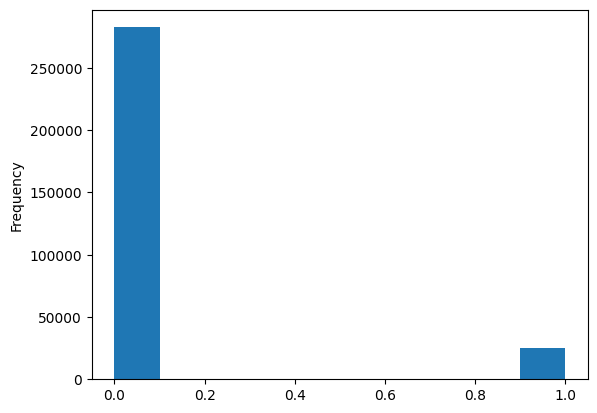

In [16]:
train['TARGET'].astype(int).plot.hist()

Les données sont très déséquilibrées, données biaisées

> Add blockquote



In [17]:
def shape(dataframes, names):
    for df, name in zip(dataframes, names):
        shape = df.shape
        print(name, "shape:", shape)
shape(df_files, df_names)

train shape: (307511, 122)
bureau_balance shape: (14409059, 3)
credit_card_balance shape: (1789053, 23)
installments_payments shape: (3669392, 8)
bureau shape: (1716428, 17)
pos_cash shape: (4991063, 8)
previeus_application shape: (806853, 37)


## Valeurs Manquantes

In [18]:
# percentage null values
def findMiss(df):
    return round(df.isnull().sum()/df.shape[0]*100,2)

In [19]:
# df_files = [train, test, bureau_balance, credit_card_balance, description, installments_payments, bureau, pos_cash, previeus_application, sample_submission]
findMiss(train)

SK_ID_CURR                     0.0
TARGET                         0.0
NAME_CONTRACT_TYPE             0.0
CODE_GENDER                    0.0
FLAG_OWN_CAR                   0.0
                              ... 
AMT_REQ_CREDIT_BUREAU_DAY     13.5
AMT_REQ_CREDIT_BUREAU_WEEK    13.5
AMT_REQ_CREDIT_BUREAU_MON     13.5
AMT_REQ_CREDIT_BUREAU_QRT     13.5
AMT_REQ_CREDIT_BUREAU_YEAR    13.5
Length: 122, dtype: float64

In [20]:
# def findMiss(dataframes, names):
#     result = []  # Create a list to store the results
#     for df, name in zip(dataframes, names):
#         missing_percentage = round(df.isnull().sum() / df.shape[0] * 100, 2)
#         result.append((name, missing_percentage))  # Store the result as a tuple (name, missing_percentage)
#     return result  # Return the list of results

# missing_info = findMiss(df_files, df_names)

# # Print the results
# for name, percentage in missing_info:
#     print("DataFrame name:", name)
#     print("Percentage of missing values:", percentage, "%")


In [21]:
findMiss(bureau_balance)

SK_ID_BUREAU      0.0
MONTHS_BALANCE    0.0
STATUS            0.0
dtype: float64

In [22]:
findMiss(credit_card_balance)

SK_ID_PREV                     0.00
SK_ID_CURR                     0.00
MONTHS_BALANCE                 0.00
AMT_BALANCE                    0.00
AMT_CREDIT_LIMIT_ACTUAL        0.00
AMT_DRAWINGS_ATM_CURRENT      20.32
AMT_DRAWINGS_CURRENT           0.00
AMT_DRAWINGS_OTHER_CURRENT    20.32
AMT_DRAWINGS_POS_CURRENT      20.32
AMT_INST_MIN_REGULARITY        7.38
AMT_PAYMENT_CURRENT           20.64
AMT_PAYMENT_TOTAL_CURRENT      0.00
AMT_RECEIVABLE_PRINCIPAL       0.00
AMT_RECIVABLE                  0.00
AMT_TOTAL_RECEIVABLE           0.00
CNT_DRAWINGS_ATM_CURRENT      20.32
CNT_DRAWINGS_CURRENT           0.00
CNT_DRAWINGS_OTHER_CURRENT    20.32
CNT_DRAWINGS_POS_CURRENT      20.32
CNT_INSTALMENT_MATURE_CUM      7.38
NAME_CONTRACT_STATUS           0.00
SK_DPD                         0.00
SK_DPD_DEF                     0.00
dtype: float64

In [23]:
findMiss(installments_payments)

SK_ID_PREV                0.0
SK_ID_CURR                0.0
NUM_INSTALMENT_VERSION    0.0
NUM_INSTALMENT_NUMBER     0.0
DAYS_INSTALMENT           0.0
DAYS_ENTRY_PAYMENT        0.0
AMT_INSTALMENT            0.0
AMT_PAYMENT               0.0
dtype: float64

In [24]:
findMiss(bureau)

SK_ID_CURR                 0.00
SK_ID_BUREAU               0.00
CREDIT_ACTIVE              0.00
CREDIT_CURRENCY            0.00
DAYS_CREDIT                0.00
CREDIT_DAY_OVERDUE         0.00
DAYS_CREDIT_ENDDATE        6.15
DAYS_ENDDATE_FACT         36.92
AMT_CREDIT_MAX_OVERDUE    65.51
CNT_CREDIT_PROLONG         0.00
AMT_CREDIT_SUM             0.00
AMT_CREDIT_SUM_DEBT       15.01
AMT_CREDIT_SUM_LIMIT      34.48
AMT_CREDIT_SUM_OVERDUE     0.00
CREDIT_TYPE                0.00
DAYS_CREDIT_UPDATE         0.00
AMT_ANNUITY               71.47
dtype: float64

In [25]:
findMiss(installments_payments)

SK_ID_PREV                0.0
SK_ID_CURR                0.0
NUM_INSTALMENT_VERSION    0.0
NUM_INSTALMENT_NUMBER     0.0
DAYS_INSTALMENT           0.0
DAYS_ENTRY_PAYMENT        0.0
AMT_INSTALMENT            0.0
AMT_PAYMENT               0.0
dtype: float64

In [26]:
findMiss(bureau)

SK_ID_CURR                 0.00
SK_ID_BUREAU               0.00
CREDIT_ACTIVE              0.00
CREDIT_CURRENCY            0.00
DAYS_CREDIT                0.00
CREDIT_DAY_OVERDUE         0.00
DAYS_CREDIT_ENDDATE        6.15
DAYS_ENDDATE_FACT         36.92
AMT_CREDIT_MAX_OVERDUE    65.51
CNT_CREDIT_PROLONG         0.00
AMT_CREDIT_SUM             0.00
AMT_CREDIT_SUM_DEBT       15.01
AMT_CREDIT_SUM_LIMIT      34.48
AMT_CREDIT_SUM_OVERDUE     0.00
CREDIT_TYPE                0.00
DAYS_CREDIT_UPDATE         0.00
AMT_ANNUITY               71.47
dtype: float64

In [27]:
findMiss(pos_cash)

SK_ID_PREV               0.00
SK_ID_CURR               0.00
MONTHS_BALANCE           0.00
CNT_INSTALMENT           0.15
CNT_INSTALMENT_FUTURE    0.15
NAME_CONTRACT_STATUS     0.00
SK_DPD                   0.00
SK_DPD_DEF               0.00
dtype: float64

In [28]:
findMiss(previeus_application)

SK_ID_PREV                      0.00
SK_ID_CURR                      0.00
NAME_CONTRACT_TYPE              0.00
AMT_ANNUITY                    22.10
AMT_APPLICATION                 0.00
AMT_CREDIT                      0.00
AMT_DOWN_PAYMENT               52.95
AMT_GOODS_PRICE                22.83
WEEKDAY_APPR_PROCESS_START      0.00
HOUR_APPR_PROCESS_START         0.00
FLAG_LAST_APPL_PER_CONTRACT     0.00
NFLAG_LAST_APPL_IN_DAY          0.00
RATE_DOWN_PAYMENT              52.95
RATE_INTEREST_PRIMARY          99.65
RATE_INTEREST_PRIVILEGED       99.65
NAME_CASH_LOAN_PURPOSE          0.00
NAME_CONTRACT_STATUS            0.00
DAYS_DECISION                   0.00
NAME_PAYMENT_TYPE               0.00
CODE_REJECT_REASON              0.00
NAME_TYPE_SUITE                49.07
NAME_CLIENT_TYPE                0.00
NAME_GOODS_CATEGORY             0.00
NAME_PORTFOLIO                  0.00
NAME_PRODUCT_TYPE               0.00
CHANNEL_TYPE                    0.00
SELLERPLACE_AREA                0.00
NAME_SELLER_INDUSTRY            0.00
CNT_PAYMENT                    22.10
NAME_YIELD_GROUP                0.00
PRODUCT_COMBINATION             0.02
DAYS_FIRST_DRAWING             39.95
DAYS_FIRST_DUE                 39.95
DAYS_LAST_DUE_1ST_VERSION      39.95
DAYS_LAST_DUE                  39.95
DAYS_TERMINATION               39.95
NFLAG_INSURED_ON_APPROVAL      39.95
dtype: float64

## Regardons la cible (Target):

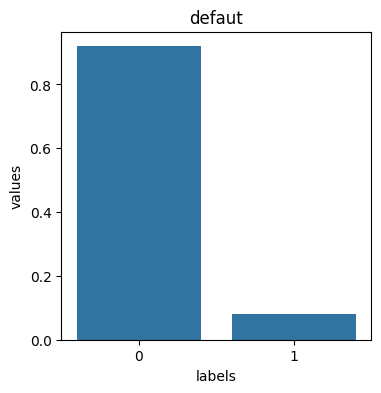

In [29]:
temp = train.TARGET.value_counts()
df1 = pd.DataFrame({'labels': temp.index,
                   'values': temp.values/len(train)})
plt.figure(figsize = (4,4))
plt.title('defaut')
sns.set_color_codes("pastel")
sns.barplot(x = 'labels', y="values", data=df1)
locs, labels = plt.xticks()
plt.show()

D'après le graphique de distribution de la colonne TARGET, nous remarquons que nos données souffrent de classes déséquilibrées.

## Nettoyage des donnees

In [30]:
bureau[bureau['SK_ID_CURR'].duplicated()].sort_values(by='SK_ID_CURR', ascending=True)

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
248485       100001       5896631        Closed      currency 1         -909   
248486       100001       5896632        Closed      currency 1         -879   
248490       100001       5896636        Active      currency 1         -320   
248489       100001       5896635        Active      currency 1          -49   
248487       100001       5896633        Closed      currency 1        -1572   
...             ...           ...           ...             ...          ...   
1010004      456255       5126328        Closed      currency 1         -970   
1010012      456255       5126336        Closed      currency 1        -2337   
1010011      456255       5126335        Closed      currency 1        -1512   
1010010      456255       5126334        Active      currency 1         -451   
1010008      456255       5126332        Active      currency 1         -378   

         CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
248485                    0               -179.0             -877.0   
248486                    0               -514.0             -544.0   
248490                    0                411.0                NaN   
248489                    0               1778.0                NaN   
248487                    0              -1329.0            -1328.0   
...                     ...                  ...                ...   
1010004                   0               -621.0             -712.0   
1010012                   0               8620.0             -779.0   
1010011                   0                315.0             -781.0   
1010010                   0                279.0                NaN   
1010008                   0              27320.0                NaN   

         AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
248485                      NaN                   0        279720.0   
248486                      NaN                   0         91620.0   
248490                      NaN                   0        168345.0   
248489                      NaN                   0        378000.0   
248487                      NaN                   0         85500.0   
...                         ...                 ...             ...   
1010004                     NaN                   0         27472.5   
1010012                2646.000                   1         38925.0   
1010011               25578.000                   0        900000.0   
1010010               15439.905                   0        450000.0   
1010008                     NaN                   0         90000.0   

         AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
248485                  0.00                   0.0                     0.0   
248486                  0.00                   0.0                     0.0   
248490             110281.50                   NaN                     0.0   
248489             373239.00                   0.0                     0.0   
248487                  0.00                   0.0                     0.0   
...                      ...                   ...                     ...   
1010004                 0.00                   0.0                     0.0   
1010012                  NaN                   NaN                     0.0   
1010011                  NaN                   NaN                     0.0   
1010010            191005.47                   0.0                     0.0   
1010008             61060.50                   NaN                     0.0   

             CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
248485   Consumer credit                -155          0.0  
248486   Consumer credit                -155          0.0  
248490   Consumer credit                 -10       9364.5  
248489   Consumer credit                 -16      10822.5  
248487   Consumer credit                -155          0.0  
...                  ...                 ... 

In [31]:
print(train.shape)
print(bureau.shape)

(307511, 122)
(1716428, 17)


Nettoyage de bureau_balance

In [32]:
# One-Hot encoder pour les colonnes catégorielles avec get_dummies
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = df.select_dtypes(["category", "object"]).columns.tolist()
    # categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [33]:
# One-Hot Encoder
bb, bb_cat = one_hot_encoder(bureau_balance, nan_as_category=False)

# Bureau balance: Perform aggregations and merge with bureau.csv
bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}

for col in bb_cat:
    bb_aggregations[col] = ['mean']

bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])

# Status Sum
bb_agg["STATUS_C0_MEAN_SUM"] = bb_agg[["STATUS_C_MEAN", "STATUS_0_MEAN"]].sum(axis = 1)
bb_agg["STATUS_12_MEAN_SUM"] = bb_agg[["STATUS_1_MEAN", "STATUS_2_MEAN"]].sum(axis = 1)
bb_agg["STATUS_345_MEAN_SUM"] = bb_agg[["STATUS_3_MEAN", "STATUS_4_MEAN", "STATUS_5_MEAN"]].sum(axis = 1)
bb_agg["STATUS_12345_MEAN_SUM"] = bb_agg[["STATUS_1_MEAN", "STATUS_2_MEAN", "STATUS_3_MEAN",
                                          "STATUS_4_MEAN", "STATUS_5_MEAN"]].sum(axis = 1)

# Retrouvez le premier mois où le crédit est clôturé !
closed = bureau_balance[bureau_balance.STATUS == "C"]
closed = closed.groupby("SK_ID_BUREAU").MONTHS_BALANCE.min().reset_index().rename({"MONTHS_BALANCE":"MONTHS_BALANCE_FIRST_C"}, axis = 1)
closed["MONTHS_BALANCE_FIRST_C"] = np.abs(closed["MONTHS_BALANCE_FIRST_C"])
bb_agg = pd.merge(bb_agg, closed, how = "left", on = "SK_ID_BUREAU")
bb_agg["MONTHS_BALANCE_CLOSED_DIF"] = np.abs(bb_agg.MONTHS_BALANCE_MIN) - bb_agg.MONTHS_BALANCE_FIRST_C

del closed, bb_aggregations, bureau_balance, bb_cat

In [34]:
print("BUREAU BALANCE SHAPE:", bb_agg.shape, "\n")

BUREAU BALANCE SHAPE: (434863, 18) 



In [35]:
bb_agg.head()

SK_ID_BUREAU  MONTHS_BALANCE_MIN  MONTHS_BALANCE_MAX  MONTHS_BALANCE_SIZE  \
0       5001710                 -82                   0                   83   
1       5001711                  -3                   0                    4   
2       5001712                 -18                   0                   19   
3       5001713                 -21                   0                   22   
4       5001714                 -14                   0                   15   

   STATUS_0_MEAN  STATUS_1_MEAN  STATUS_2_MEAN  STATUS_3_MEAN  STATUS_4_MEAN  \
0       0.060241            0.0            0.0            0.0            0.0   
1       0.750000            0.0            0.0            0.0            0.0   
2       0.526316            0.0            0.0            0.0            0.0   
3       0.000000            0.0            0.0            0.0            0.0   
4       0.000000            0.0            0.0            0.0            0.0   

   STATUS_5_MEAN  STATUS_C_MEAN  STATUS_X_MEAN  STATUS_C0_MEAN_SUM  \
0            0.0       0.578313       0.361446            0.638554   
1            0.0       0.000000       0.250000            0.750000   
2            0.0       0.473684       0.000000            1.000000   
3            0.0       0.000000       1.000000            0.000000   
4            0.0       0.000000       1.000000            0.000000   

   STATUS_12_MEAN_SUM  STATUS_345_MEAN_SUM  STATUS_12345_MEAN_SUM  \
0                 0.0                  0.0                    0.0   
1                 0.0                  0.0                    0.0   
2                 0.0                  0.0                    0.0   
3                 0.0                  0.0                    0.0   
4                 0.0                  0.0                    0.0   

   MONTHS_BALANCE_FIRST_C  MONTHS_BALANCE_CLOSED_DIF  
0                    47.0                       35.0  
1                     NaN                        NaN  
2                     8.0                       10.0  
3                     NaN                        NaN  
4                     NaN                        NaN

In [36]:
pd.set_option('display.max_columns', 500)

Merge Bureau Balance and Bureau

In [37]:
# LEFT JOIN WITH BUREAU
bureau = pd.merge(bureau, bb_agg, how='left', on='SK_ID_BUREAU')
# del bb_agg

print(bureau.shape, "\n")

bureau.head()

(1716428, 34) 



SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  MONTHS_BALANCE_MIN  \
0  Consumer credit                -131          NaN                 NaN   
1      Credit card                 -20          NaN                 NaN   
2  Consumer credit                 -16          NaN                 NaN   
3      Credit card                 -16          NaN                 NaN   
4  Consumer credit                 -21          NaN                 NaN   

   MONTHS_BALANCE_MAX  MONTHS_BALANCE_SIZE  STATUS_0_MEAN  STATUS_1_MEAN  \
0                 NaN                  NaN            NaN            NaN   
1                 NaN                  NaN            NaN            NaN   
2                 NaN                  NaN            NaN            NaN   
3                 NaN                  NaN            NaN            NaN   
4                 NaN                  NaN            NaN            NaN   

   STATUS_2_MEAN  STATUS_3_MEAN  STATUS_4_MEAN  STATUS_5_MEAN  STATUS_C_MEAN  \
0            NaN            NaN            NaN            NaN            NaN   
1            NaN            NaN            NaN            NaN            NaN   
2            NaN            NaN            NaN            NaN            NaN   
3            NaN            NaN            NaN            NaN            NaN   
4            NaN            NaN            NaN            NaN            NaN   

   STATUS_X_MEAN  STATUS_C0_MEAN_SUM  STATUS_12_MEAN_SUM  STATUS_345_MEAN_SUM  \
0            NaN                 NaN                 NaN                  NaN   
1            NaN                 NaN                 NaN                  NaN   
2            NaN                 NaN                 NaN                  NaN   
3            NaN                 NaN                 NaN                  NaN   
4            NaN                 NaN                 NaN                  NaN   

   STATUS_12345_MEAN_SUM  MONTHS_BALANCE_FIRST_C  MONTHS_BALANCE_CLOSED_DIF  
0                    NaN                     NaN                        NaN  
1                    NaN                     NaN                        NaN  
2                    NaN                     NaN                        NaN  
3                    NaN                     NaN                        NaN  
4                    NaN                     NaN                        NaN

In [38]:
bureau.CREDIT_ACTIVE

0          Closed
1          Active
2          Active
3          Active
4          Active
            ...  
1716423    Active
1716424    Closed
1716425    Closed
1716426    Closed
1716427    Closed
Name: CREDIT_ACTIVE, Length: 1716428, dtype: object

Le taux de valeurs manquantes en % de bureau

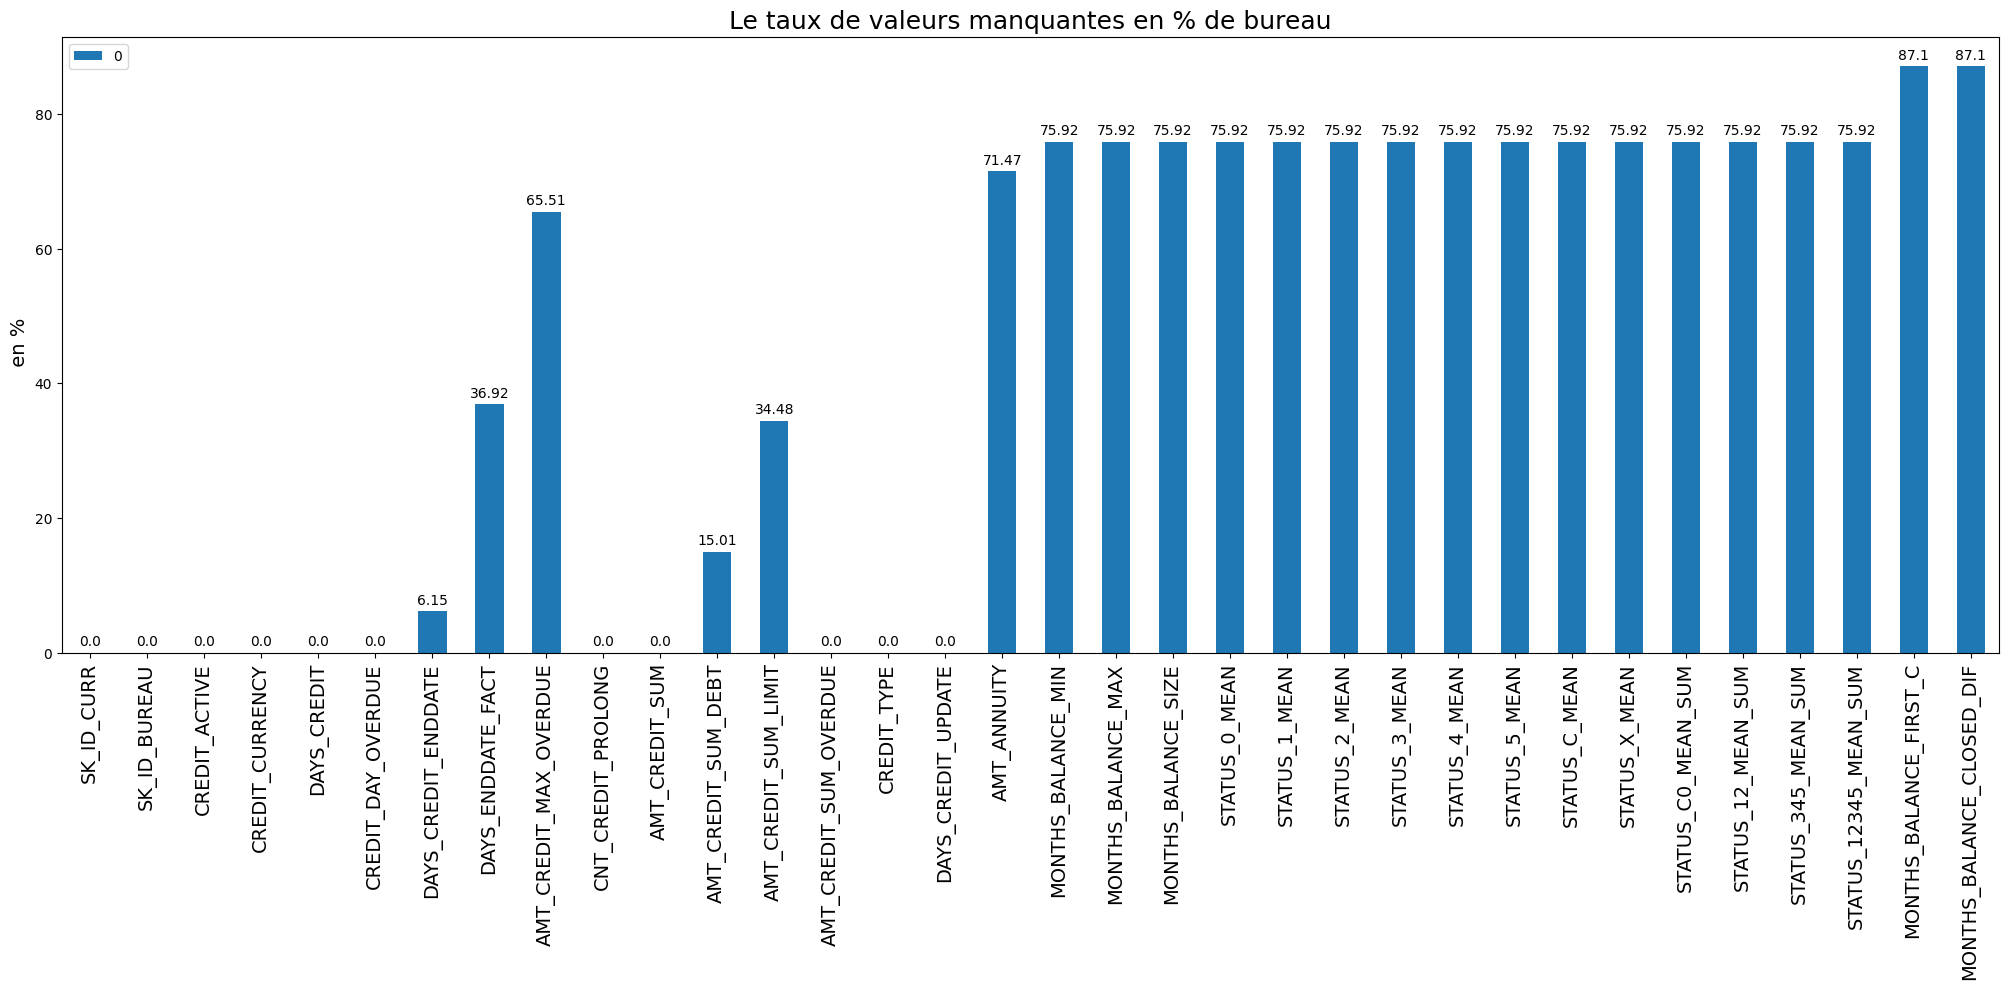

In [39]:
missing_rate = (bureau.isna().sum()/bureau.shape[0])*100
missing_rate

missing_rate = pd.DataFrame(missing_rate)
ax = missing_rate.plot.bar(figsize=(25,8))

ax.set_ylabel(" en %", fontsize=14)
plt.xticks(rotation='vertical', fontsize=14)
plt.title("Le taux de valeurs manquantes en % de bureau",fontsize=18)
# Ajouter les annotations sur les barres
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    plt.annotate(np.round(p.get_height(),decimals=2),
                (p.get_x()+p.get_width()/2, p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 8),
                textcoords='offset points',
                fontsize = 10,
                )


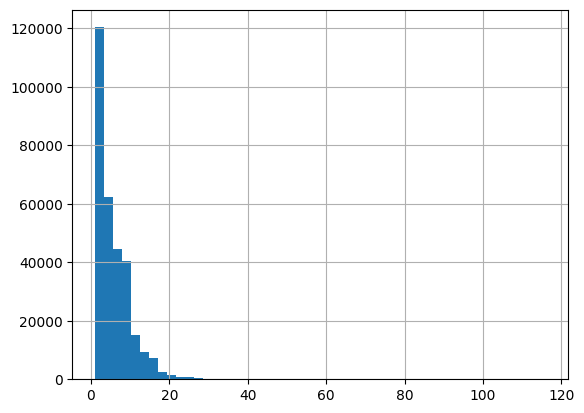

median      4.000000
max       116.000000
min         1.000000
std         4.430354
mean        5.612709
Name: SK_ID_BUREAU, dtype: float64

In [40]:
# Combien de prêts de chaque client y a-t-il auprès du bureau de crédit ?
bureau.groupby("SK_ID_CURR").SK_ID_BUREAU.count().hist(bins=50), plt.show()
bureau.groupby("SK_ID_CURR").SK_ID_BUREAU.count().agg({"min", "max", "mean", "median", "std"})

Manipulation de données de bureau

test

In [41]:
# FEATURE ENGINEERING BUREAU

# Categorical Variables
# -----------------------------------------------------------
# Inutile
# bureau.drop("CREDIT_CURRENCY", axis = 1, inplace = True)

# Catégories rares
bureau["CREDIT_ACTIVE"] = np.where(bureau.CREDIT_ACTIVE.isin(["Sold", "Bad debt"]), "Sold_BadDebt", bureau.CREDIT_ACTIVE)

bureau["CREDIT_TYPE"] = np.where(
    ~bureau.CREDIT_TYPE.isin(
        ["Consumer credit", "Credit card", "Car loan", "Mortgage", "Microloan"]
    ), "Other", bureau["CREDIT_TYPE"])

# One-Hot Encoder
bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category=False)


# Variables numériques
# -----------------------------------------------------------

# Bureau and bureau_balance variables numériques
# cal = ['min', 'max', 'mean', 'sum', 'median','std']
cal = ['mean']
cols1 = [
    'DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_CREDIT_UPDATE','CREDIT_DAY_OVERDUE',
    'AMT_CREDIT_MAX_OVERDUE', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_OVERDUE',
    'AMT_CREDIT_SUM_LIMIT', 'AMT_ANNUITY', 'CNT_CREDIT_PROLONG', 'MONTHS_BALANCE_MIN',
    'MONTHS_BALANCE_MAX', 'MONTHS_BALANCE_SIZE', 'MONTHS_BALANCE_FIRST_C', 'MONTHS_BALANCE_CLOSED_DIF'
]

num_aggregations = {}


for i in cols1:
    num_aggregations[i] = cal


# Bureau and bureau_balance variables catégoriques
cat_aggregations = {}

for i in bureau_cat:
    cat_aggregations[i] = ['mean']

cols2 = ['STATUS_0_MEAN', 'STATUS_1_MEAN', 'STATUS_2_MEAN', 'STATUS_3_MEAN', 'STATUS_4_MEAN',
        'STATUS_5_MEAN', 'STATUS_C_MEAN', 'STATUS_X_MEAN', 'STATUS_C0_MEAN_SUM',
        'STATUS_12_MEAN_SUM', 'STATUS_345_MEAN_SUM', 'STATUS_12345_MEAN_SUM']
for i in cols2:
#     cat_aggregations[i] = ['mean', 'median', 'sum', 'max', 'std']
    cat_aggregations[i] = ['mean']

# del i, cols1, cols2, bureau_cat, cal

# Créer des données agrégées
bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
bureau_agg.columns = pd.Index(['BUREAU_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])


# Nouvelles variables
bureau.groupby("SK_ID_CURR").SK_ID_BUREAU.count().value_counts()
bcount = bureau.groupby("SK_ID_CURR").SK_ID_BUREAU.count().reset_index().rename({"SK_ID_BUREAU":"BUREAU_COUNT"}, axis = 1)
bcount["BUREAU_COUNT_CAT"] = np.where(bcount.BUREAU_COUNT < 4, 0, 1)
bcount["BUREAU_COUNT_CAT"] = np.where((bcount.BUREAU_COUNT >= 8) & (bcount.BUREAU_COUNT < 13), 2, bcount["BUREAU_COUNT_CAT"])
bcount["BUREAU_COUNT_CAT"] = np.where((bcount.BUREAU_COUNT >= 13) & (bcount.BUREAU_COUNT < 20), 3, bcount["BUREAU_COUNT_CAT"])
bcount["BUREAU_COUNT_CAT"] = np.where((bcount.BUREAU_COUNT >= 20), 4, bcount["BUREAU_COUNT_CAT"])
bureau_agg = pd.merge(bureau_agg, bcount, how = "left", on = "SK_ID_CURR")
# del bcount


# Bureau : Crédits actifs - en utilisant uniquement des agrégations numériques
active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
bureau_agg = pd.merge(bureau_agg, active_agg, how='left', on='SK_ID_CURR')
# del active, active_agg


# Bureau : Crédits fermés - en utilisant uniquement des agrégations numériques
closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
bureau_agg = pd.merge(bureau_agg, closed_agg, how='left', on='SK_ID_CURR')
# del closed, closed_agg

# Bureau : crédits vendus et créances irrécouvrables - en utilisant uniquement des agrégations numériques
sold_baddebt = bureau[bureau['CREDIT_ACTIVE_Sold_BadDebt'] == 1]
sold_baddebt_agg = sold_baddebt.groupby('SK_ID_CURR').agg(num_aggregations)
sold_baddebt_agg.columns = pd.Index(['SOLD_BADDEBT' + e[0] + "_" + e[1].upper() for e in sold_baddebt_agg.columns.tolist()])
bureau_agg = pd.merge(bureau_agg, sold_baddebt_agg, how='left', on='SK_ID_CURR')
# del sold_baddebt, sold_baddebt_agg, bureau

# del num_aggregations, cat_aggregations

print("BUREAU & BURAU BALANCE SHAPE:", bureau_agg.shape, "\n")

bureau_agg.head()

BUREAU & BURAU BALANCE SHAPE: (305811, 92) 



SK_ID_CURR  BUREAU_DAYS_CREDIT_MEAN  BUREAU_DAYS_CREDIT_ENDDATE_MEAN  \
0      100001              -735.000000                        82.428571   
1      100002              -874.000000                      -349.000000   
2      100003             -1400.750000                      -544.500000   
3      100004              -867.000000                      -488.500000   
4      100005              -190.666667                       439.333333   

   BUREAU_DAYS_CREDIT_UPDATE_MEAN  BUREAU_CREDIT_DAY_OVERDUE_MEAN  \
0                      -93.142857                             0.0   
1                     -499.875000                             0.0   
2                     -816.000000                             0.0   
3                     -532.000000                             0.0   
4                      -54.333333                             0.0   

   BUREAU_AMT_CREDIT_MAX_OVERDUE_MEAN  BUREAU_AMT_CREDIT_SUM_MEAN  \
0                                 NaN               207623.571429   
1                            1681.029               108131.945625   
2                               0.000               254350.125000   
3                               0.000                94518.900000   
4                               0.000               219042.000000   

   BUREAU_AMT_CREDIT_SUM_DEBT_MEAN  BUREAU_AMT_CREDIT_SUM_OVERDUE_MEAN  \
0                     85240.928571                                 0.0   
1                     49156.200000                                 0.0   
2                         0.000000                                 0.0   
3                         0.000000                                 0.0   
4                    189469.500000                                 0.0   

   BUREAU_AMT_CREDIT_SUM_LIMIT_MEAN  BUREAU_AMT_ANNUITY_MEAN  \
0                           0.00000              3545.357143   
1                        7997.14125                 0.000000   
2                      202500.00000                      NaN   
3                           0.00000                      NaN   
4                           0.00000              1420.500000   

   BUREAU_CNT_CREDIT_PROLONG_MEAN  BUREAU_MONTHS_BALANCE_MIN_MEAN  \
0                             0.0                      -23.571429   
1                             0.0                      -26.333333   
2                             0.0                             NaN   
3                             0.0                             NaN   
4                             0.0                             NaN   

   BUREAU_MONTHS_BALANCE_MAX_MEAN  BUREAU_MONTHS_BALANCE_SIZE_MEAN  \
0                        0.000000                        24.571429   
1                      -14.333333                        13.000000   
2                             NaN                              NaN   
3                             NaN                              NaN   
4                             NaN                              NaN   

   BUREAU_MONTHS_BALANCE_FIRST_C_MEAN  BUREAU_MONTHS_BALANCE_CLOSED_DIF_MEAN  \
0                               26.50                                   7.50   
1                               20.75                                  12.75   
2                                 NaN                                    NaN   
3                                 NaN                                    NaN   
4                                 NaN                                    NaN   

   BUREAU_CREDIT_ACTIVE_Active_MEAN  BUREAU_CREDIT_ACTIVE_Closed_MEAN  \
0                          0.428571                          0.571429   
1                          0.250000                          0.750000   
2                          0.250000                          0.750000   
3                          0.000000                          1.000000   
4                          0.666667                          0.333333   

   BUREAU_CREDIT_ACTIVE_Sold_BadDebt_MEAN  \
0                                     0.0   
1                                     0.0   
2

Nettoyage de données de df_POS_CASH_balance

In [42]:
# Rare
pos_cash["NAME_CONTRACT_STATUS"] = np.where(~(pos_cash["NAME_CONTRACT_STATUS"].isin([
   "Active", "Completed"
])), "Rare", pos_cash["NAME_CONTRACT_STATUS"])

# One-Hot Encoder
pos_cash, cat_cols = one_hot_encoder(pos_cash, nan_as_category=False)

aggregations = {
    'MONTHS_BALANCE': ['mean', 'size'],
    'CNT_INSTALMENT': ['mean'],
    'CNT_INSTALMENT_FUTURE': ['mean'],
    'SK_DPD': ['mean'],
    'SK_DPD_DEF': ['mean']
}
# Catégorique
for cat in cat_cols:
    aggregations[cat] = ['mean']

# Agrégation
pos_cash_agg = pos_cash.groupby('SK_ID_CURR').agg(aggregations)
pos_cash_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_cash_agg.columns.tolist()])
# Count df_POS_CASH_balance cash accounts
pos_cash_agg['df_POS_CASH_balance_COUNT'] = pos_cash.groupby('SK_ID_CURR').size()
pos_cash_agg.reset_index(inplace = True)
del pos_cash

print("df_POS_CASH_balance CASH BALANCE SHAPE:", pos_cash_agg.shape, "\n")

pos_cash_agg.head()

df_POS_CASH_balance CASH BALANCE SHAPE: (320381, 11) 



SK_ID_CURR  POS_MONTHS_BALANCE_MEAN  POS_MONTHS_BALANCE_SIZE  \
0      100001               -78.200000                        5   
1      100002               -15.666667                        3   
2      100003               -47.705882                       17   
3      100004               -24.500000                        2   
4      100005               -22.200000                        5   

   POS_CNT_INSTALMENT_MEAN  POS_CNT_INSTALMENT_FUTURE_MEAN  POS_SK_DPD_MEAN  \
0                 4.000000                        0.800000              1.4   
1                24.000000                       20.666667              0.0   
2                11.294118                        6.117647              0.0   
3                 3.500000                        1.000000              0.0   
4                12.000000                        9.500000              0.0   

   POS_SK_DPD_DEF_MEAN  POS_NAME_CONTRACT_STATUS_Active_MEAN  \
0                  1.4                                   0.6   
1                  0.0                                   1.0   
2                  0.0                                   1.0   
3                  0.0                                   0.5   
4                  0.0                                   0.8   

   POS_NAME_CONTRACT_STATUS_Completed_MEAN  \
0                                      0.4   
1                                      0.0   
2                                      0.0   
3                                      0.5   
4                                      0.0   

   POS_NAME_CONTRACT_STATUS_Rare_MEAN  df_POS_CASH_balance_COUNT  
0                                 0.0                          5  
1                                 0.0                          3  
2                                 0.0                         17  
3                                 0.0                          2  
4                                 0.2                          5

Credit Card Balance

Aperçus mensuels du solde des cartes de crédit précédentes que le demandeur a avec Home Credit. Ce tableau comporte une ligne pour chaque mois d'historique de chaque crédit précédent dans Home Credit (crédit à la consommation et prêts de trésorerie) liés aux prêts de notre échantillon - c'est-à-dire que le tableau a (#prêts dans l'échantillon # de cartes de crédit précédentes relatives # de mois où nous avons un historique observable pour les lignes de carte de crédit précédentes).

Le taux de valeurs manquantes en % df_credit_card_balance

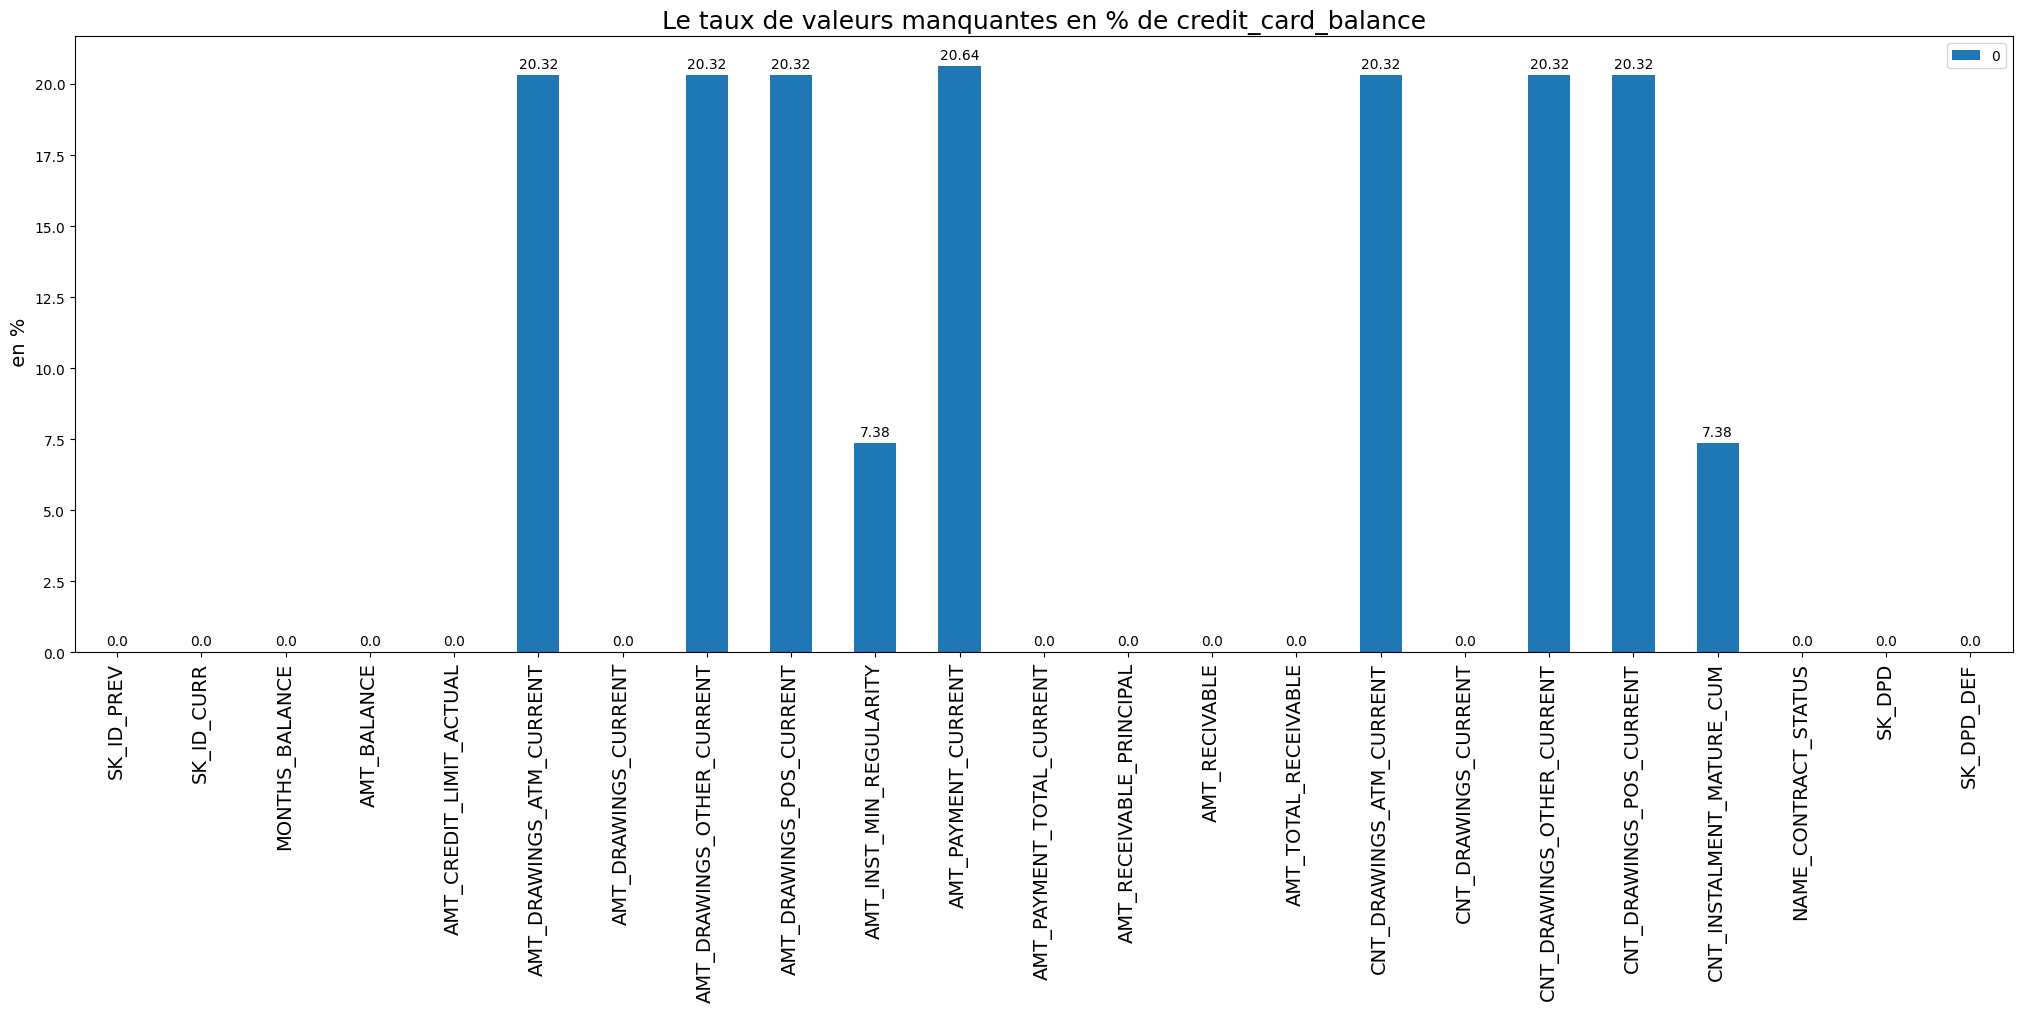

In [43]:
missing_rate = (credit_card_balance.isna().sum()/credit_card_balance.shape[0])*100

missing_rate = pd.DataFrame(missing_rate)
ax = missing_rate.plot.bar(figsize=(25,8))

ax.set_ylabel(" en %", fontsize=14)
plt.xticks(rotation='vertical', fontsize=14)
plt.title("Le taux de valeurs manquantes en % de credit_card_balance",fontsize=18)

# Ajouter les annotations sur les barres
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    plt.annotate(np.round(p.get_height(),decimals=2),
                (p.get_x()+p.get_width()/2, p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 8),
                textcoords='offset points',
                fontsize = 10,
                )

Nettoyage des données df_credit_card_balance

In [44]:
# Rare
credit_card_balance["NAME_CONTRACT_STATUS"] = np.where(~(credit_card_balance["NAME_CONTRACT_STATUS"].isin([
   "Active", "Completed"
])), "Rare", credit_card_balance["NAME_CONTRACT_STATUS"])

# One Hot Encoder
credit_card_balance, cat_cols = one_hot_encoder(credit_card_balance, nan_as_category=False)

# Agrégations générales
credit_card_balance.drop(['SK_ID_PREV'], axis=1, inplace=True)
credit_card_balance_agg = credit_card_balance.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'std'])
credit_card_balance_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in credit_card_balance_agg.columns.tolist()])
# Compter les lignes de cartes de crédit
credit_card_balance_agg['df_credit_card_balance_COUNT'] = credit_card_balance.groupby('SK_ID_CURR').size()
credit_card_balance_agg.reset_index(inplace = True)
del credit_card_balance

print("CREDIT CARD BALANCE SHAPE:", credit_card_balance_agg.shape, "\n")

credit_card_balance_agg.head()

CREDIT CARD BALANCE SHAPE: (102395, 117) 



SK_ID_CURR  CC_MONTHS_BALANCE_MIN  CC_MONTHS_BALANCE_MAX  \
0      100006                     -6                     -1   
1      100011                    -72                     -4   
2      100013                    -94                     -2   
3      100021                    -16                     -2   
4      100023                     -9                     -4   

   CC_MONTHS_BALANCE_MEAN  CC_MONTHS_BALANCE_SUM  CC_MONTHS_BALANCE_STD  \
0               -3.500000                    -21               1.870829   
1              -39.620690                  -1149              20.800779   
2              -47.744186                  -2053              29.465955   
3               -8.000000                    -56               5.446712   
4               -7.000000                    -28               2.160247   

   CC_AMT_BALANCE_MIN  CC_AMT_BALANCE_MAX  CC_AMT_BALANCE_MEAN  \
0                 0.0                0.00             0.000000   
1                 0.0           177544.35         57586.936034   
2                 0.0           161420.22         28686.116512   
3                 0.0                0.00             0.000000   
4                 0.0                0.00             0.000000   

   CC_AMT_BALANCE_SUM  CC_AMT_BALANCE_STD  CC_AMT_CREDIT_LIMIT_ACTUAL_MIN  \
0               0.000            0.000000                          270000   
1         1670021.145        66007.585518                           90000   
2         1233503.010        50360.679225                           45000   
3               0.000            0.000000                          675000   
4               0.000            0.000000                           45000   

   CC_AMT_CREDIT_LIMIT_ACTUAL_MAX  CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN  \
0                          270000                    270000.000000   
1                          180000                    167586.206897   
2                          157500                    123488.372093   
3                          675000                    675000.000000   
4                          225000                    135000.000000   

   CC_AMT_CREDIT_LIMIT_ACTUAL_SUM  CC_AMT_CREDIT_LIMIT_ACTUAL_STD  \
0                         1620000                        0.000000   
1                         4860000                    31583.808285   
2                         5310000                    52278.841251   
3                         4725000                        0.000000   
4                          540000                   103923.048454   

   CC_AMT_DRAWINGS_ATM_CURRENT_MIN  CC_AMT_DRAWINGS_ATM_CURRENT_MAX  \
0                              NaN                              NaN   
1                              0.0                              0.0   
2                              0.0                         157500.0   
3                              NaN                              NaN   
4                              NaN                              NaN   

   CC_AMT_DRAWINGS_ATM_CURRENT_MEAN  CC_AMT_DRAWINGS_ATM_CURRENT_SUM  \
0                               NaN                              0.0   
1                          0.000000                              0.0   
2                      10207.317073                         418500.0   
3                               NaN                              0.0   
4                               NaN                              0.0   

   CC_AMT_DRAWINGS_ATM_CURRENT_STD  CC_AMT_DRAWINGS_CURRENT_MIN  \
0                              NaN                          0.0   
1                         0.000000                          0.0   
2                     37162.813337                          0.0   
3                              NaN                          0.0   
4                              NaN                          0.0   

   CC_AMT_DRAWINGS_CURRENT_MAX  CC_AMT_DRAWINGS_CURRENT_MEAN  \
0                          0.0                       0.00000   
1                          0.0                       0.00000   
2                     

**Installments Payments**

Historique de remboursement des crédits précédemment décaissés en Home Credit liés aux prêts de notre échantillon. Il y a :

une ligne pour chaque paiement effectué plus
une ligne pour chaque paiement manqué. Une ligne équivaut à un versement d'une échéance ou une échéance correspondant à un versement d'un précédent crédit immobilier lié aux crédits de notre échantillon.

Le taux de valeurs manquantes en % df_credit_card_balance

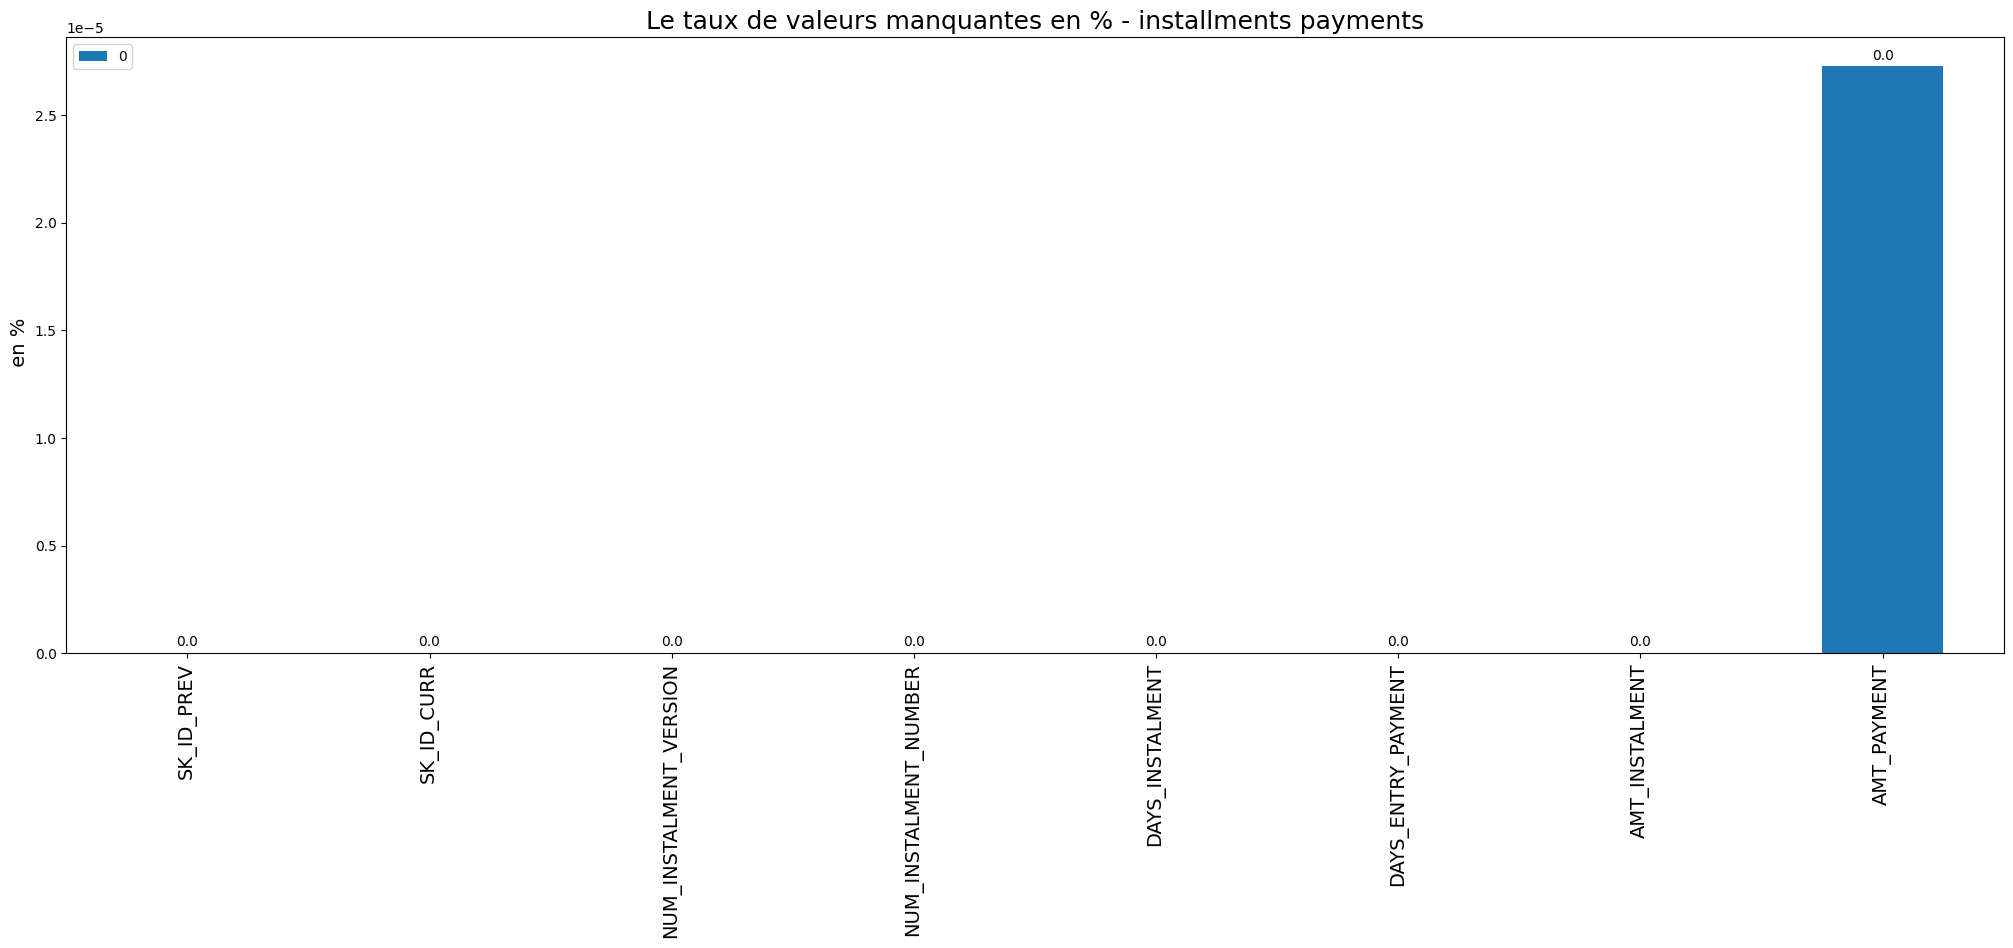

In [45]:
missing_rate = (installments_payments.isna().sum()/installments_payments.shape[0])*100

missing_rate = pd.DataFrame(missing_rate)
ax = missing_rate.plot.bar(figsize=(25,8))

ax.set_ylabel(" en %", fontsize=14)
plt.xticks(rotation='vertical', fontsize=14)
plt.title("Le taux de valeurs manquantes en % - installments payments",fontsize=18)

# Ajouter les annotations sur les barres
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    plt.annotate(np.round(p.get_height(),decimals=2),
                (p.get_x()+p.get_width()/2, p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 8),
                textcoords='offset points',
                fontsize = 10,
                )

In [46]:
installments_payments['DAYS_INSTALMENT'] = pd.to_numeric(installments_payments['DAYS_INSTALMENT'], errors='coerce')

In [47]:
# Pourcentage et différence payés à chaque versement (montant payé et valeur du versement)
installments_payments['PAYMENT_PERC'] = installments_payments['AMT_PAYMENT'] / installments_payments['AMT_INSTALMENT']
installments_payments['PAYMENT_DIFF'] = installments_payments['AMT_INSTALMENT'] - installments_payments['AMT_PAYMENT']
# Jours de retard et jours avant l'échéance (pas de valeurs négatives)
installments_payments['DPD'] = installments_payments['DAYS_ENTRY_PAYMENT'] - installments_payments['DAYS_INSTALMENT']
installments_payments['DBD'] = installments_payments['DAYS_INSTALMENT'] - installments_payments['DAYS_ENTRY_PAYMENT']
installments_payments['DPD'] = installments_payments['DPD'].apply(lambda x: x if x > 0 else 0)
installments_payments['DBD'] = installments_payments['DBD'].apply(lambda x: x if x > 0 else 0)
# Fonctionnalités : Effectuer des agrégations
aggregations = {
    'NUM_INSTALMENT_VERSION': ['nunique'],
    'NUM_INSTALMENT_NUMBER': ['mean'],
    'DAYS_INSTALMENT': ['mean'],
    'DAYS_ENTRY_PAYMENT': ['mean'],
    'AMT_INSTALMENT': ['mean'],
    'AMT_PAYMENT': ['mean'],
    'DPD': ['mean'],
    'DBD': ['mean'],
    'PAYMENT_PERC': ['mean'],
    'PAYMENT_DIFF': ['mean']
}

installments_payments_agg = installments_payments.groupby('SK_ID_CURR').agg(aggregations)
installments_payments_agg.columns = pd.Index(['INS_' + e[0] + "_" + e[1].upper() for e in installments_payments_agg.columns.tolist()])
# Compter les versements des comptes
installments_payments_agg['INS_COUNT'] = installments_payments.groupby('SK_ID_CURR').size()

installments_payments_agg.reset_index(inplace = True)
del installments_payments



print("INSTALLMENTS PAYMENTS SHAPE:", installments_payments_agg.shape, "\n")

installments_payments_agg.head()

INSTALLMENTS PAYMENTS SHAPE: (95333, 12) 



SK_ID_CURR  INS_NUM_INSTALMENT_VERSION_NUNIQUE  \
0      100001                                   2   
1      100002                                   2   
2      100003                                   2   
3      100004                                   2   
4      100005                                   2   

   INS_NUM_INSTALMENT_NUMBER_MEAN  INS_DAYS_INSTALMENT_MEAN  \
0                        2.666667              -2071.333333   
1                       10.000000               -295.000000   
2                        5.080000              -1378.160000   
3                        2.000000               -754.000000   
4                        5.000000               -586.000000   

   INS_DAYS_ENTRY_PAYMENT_MEAN  INS_AMT_INSTALMENT_MEAN  INS_AMT_PAYMENT_MEAN  \
0                 -2081.666667              6202.312500           6202.312500   
1                  -315.421053             11559.247105          11559.247105   
2                 -1385.320000             64754.586000          64754.586000   
3                  -761.666667              7096.155000           7096.155000   
4                  -609.555556              6240.205000           6240.205000   

   INS_DPD_MEAN  INS_DBD_MEAN  INS_PAYMENT_PERC_MEAN  INS_PAYMENT_DIFF_MEAN  \
0      0.000000     10.333333                    1.0                    0.0   
1      0.000000     20.421053                    1.0                    0.0   
2      0.000000      7.160000                    1.0                    0.0   
3      0.000000      7.666667                    1.0                    0.0   
4      0.111111     23.666667                    1.0                    0.0   

   INS_COUNT  
0          6  
1         19  
2         25  
3          3  
4          9

**Previous Applications**

Toutes les demandes précédentes de prêts immobiliers des clients qui ont des prêts dans notre échantillon.
Il y a une ligne pour chaque demande précédente liée aux prêts dans notre échantillon de données.

Le taux de valeurs manquantes en % df_previous_application

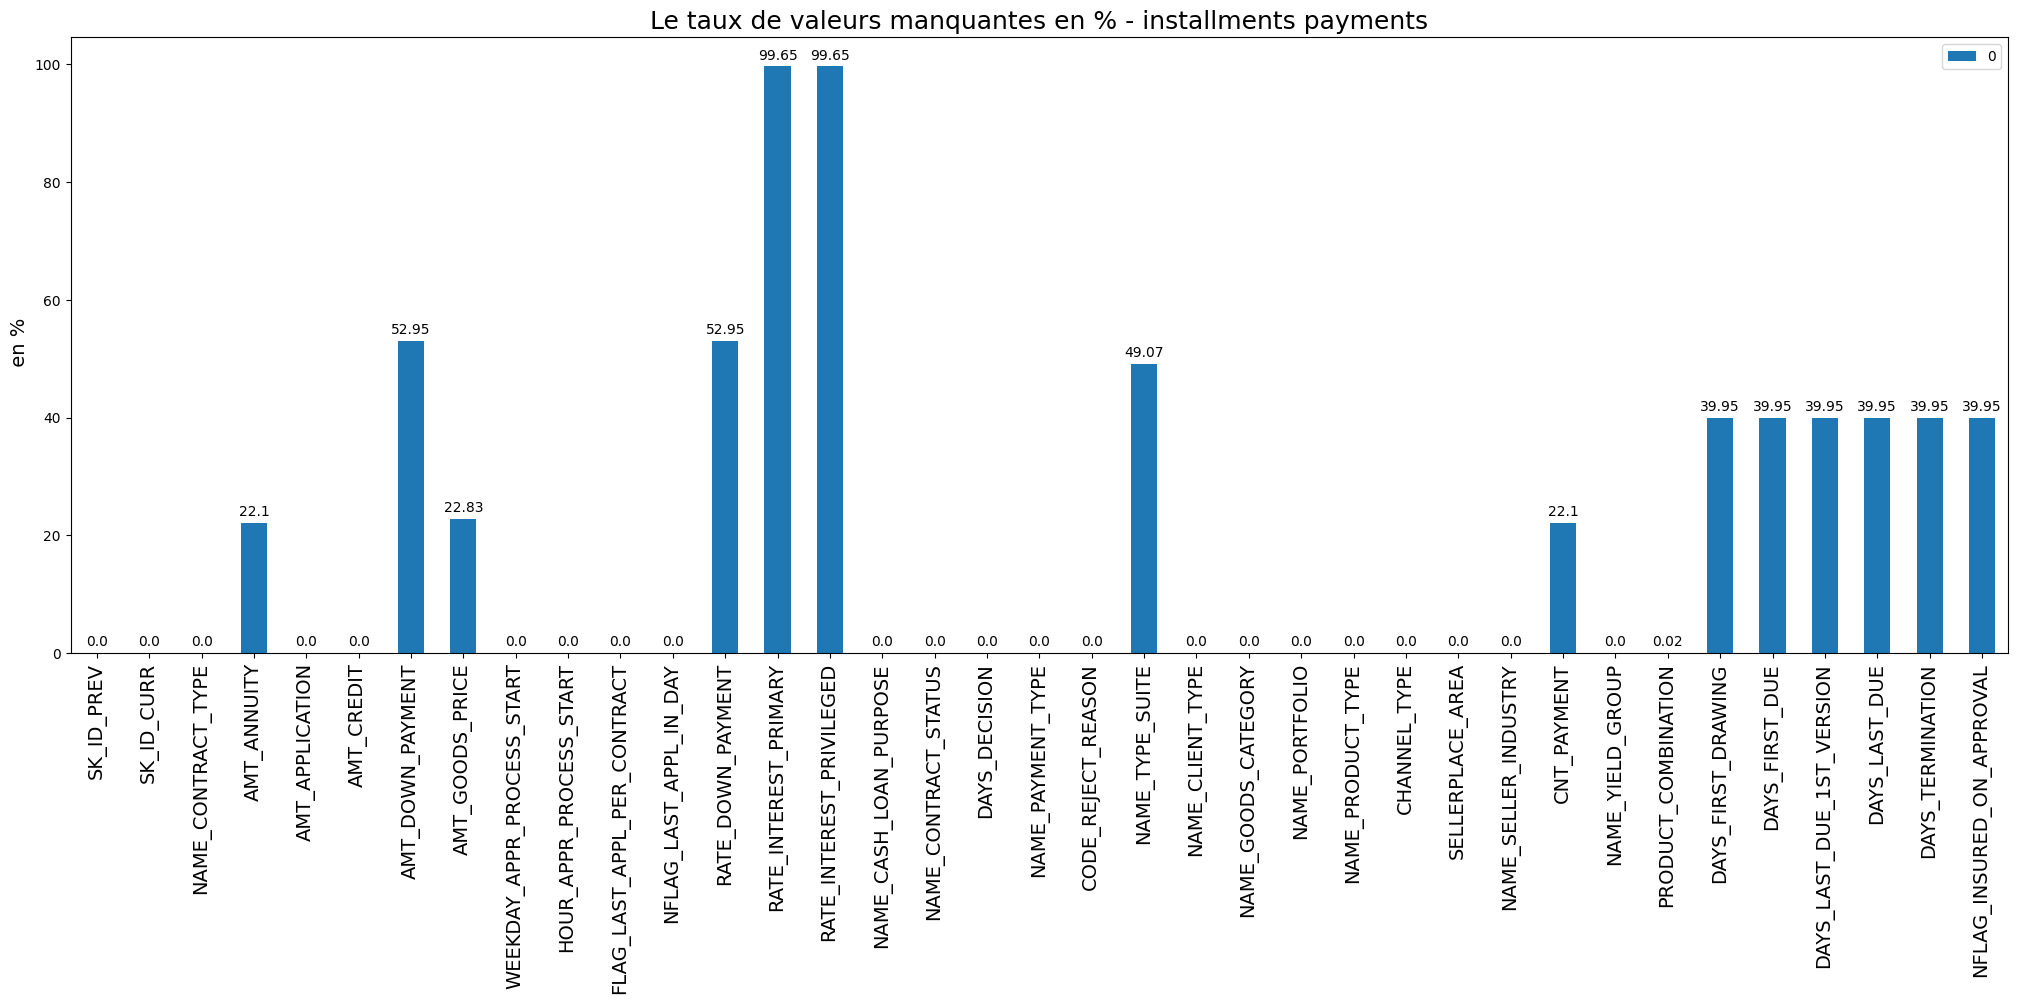

In [48]:
missing_rate = (previeus_application.isna().sum()/previeus_application.shape[0])*100

missing_rate = pd.DataFrame(missing_rate)
ax = missing_rate.plot.bar(figsize=(25,8))

ax.set_ylabel(" en %", fontsize=14)
plt.xticks(rotation='vertical', fontsize=14)
plt.title("Le taux de valeurs manquantes en % - installments payments",fontsize=18)

# Ajouter les annotations sur les barres
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    plt.annotate(np.round(p.get_height(),decimals=2),
                (p.get_x()+p.get_width()/2, p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 8),
                textcoords='offset points',
                fontsize = 10,
                )

Nettoyage des données de df_previous_application

In [49]:
# Rare Encoder
def rare_encoder(data, col, rare_perc):
    temp = data[col].value_counts() / len(data) < rare_perc
    data[col] = np.where(~data[col].isin(temp[temp < rare_perc].index), "Rare", data[col])

In [50]:
# Rare Encoder
rare_cols = [
    "NAME_PAYMENT_TYPE", "CODE_REJECT_REASON", "CHANNEL_TYPE", "NAME_GOODS_CATEGORY",
    "NAME_SELLER_INDUSTRY", "NAME_TYPE_SUITE"
]

for i in rare_cols:
    rare_encoder(previeus_application, i, rare_perc = 0.01)

previeus_application["NAME_CASH_LOAN_PURPOSE"] = np.where(~previeus_application["NAME_CASH_LOAN_PURPOSE"].isin(["XAP", "XNA"]), "Other", previeus_application["NAME_CASH_LOAN_PURPOSE"])

rare_encoder(previeus_application, "NAME_PORTFOLIO", rare_perc = 0.1)

# Cash, Pos, Card
previeus_application["PRODUCT_COMBINATION_CATS"] = np.where(previeus_application["PRODUCT_COMBINATION"].str.contains("Cash"), "CASH", "POS")
previeus_application["PRODUCT_COMBINATION_CATS"] = np.where(previeus_application["PRODUCT_COMBINATION"].str.contains("Card"), "CARD", previeus_application["PRODUCT_COMBINATION_CATS"])
# Nouvelles variables catégorielles
previeus_application["PRODUCT_COMBINATION_POS_WITH"] = np.where((previeus_application["PRODUCT_COMBINATION"].str.contains("POS") & (previeus_application["PRODUCT_COMBINATION"].str.contains("without"))), "WITHOUT", "OTHER")
previeus_application["PRODUCT_COMBINATION_POS_WITH"] = np.where((previeus_application["PRODUCT_COMBINATION"].str.contains("POS") & (previeus_application["PRODUCT_COMBINATION"].str.contains("with interest"))), "WITH", previeus_application["PRODUCT_COMBINATION_POS_WITH"])
previeus_application["PRODUCT_COMBINATION_POS_TYPE"] = np.where((previeus_application["PRODUCT_COMBINATION"].str.contains("POS") & (previeus_application["PRODUCT_COMBINATION"].str.contains("household"))), "household", "OTHER")
previeus_application["PRODUCT_COMBINATION_POS_TYPE"] = np.where((previeus_application["PRODUCT_COMBINATION"].str.contains("POS") & (previeus_application["PRODUCT_COMBINATION"].str.contains("industry"))), "industry", previeus_application["PRODUCT_COMBINATION_POS_TYPE"])
previeus_application["PRODUCT_COMBINATION_POS_TYPE"] = np.where((previeus_application["PRODUCT_COMBINATION"].str.contains("POS") & (previeus_application["PRODUCT_COMBINATION"].str.contains("mobile"))), "mobile", previeus_application["PRODUCT_COMBINATION_POS_TYPE"])
previeus_application["PRODUCT_COMBINATION_POS_TYPE"] = np.where((previeus_application["PRODUCT_COMBINATION"].str.contains("POS") & (previeus_application["PRODUCT_COMBINATION"].str.contains("other"))), "posother", previeus_application["PRODUCT_COMBINATION_POS_TYPE"])
previeus_application["PRODUCT_COMBINATION_CASH_TYPE"] = np.where((previeus_application["PRODUCT_COMBINATION"].str.contains("Cash") & (previeus_application["PRODUCT_COMBINATION"].str.contains("X-Sell"))), "xsell", "OTHER")
previeus_application["PRODUCT_COMBINATION_CASH_TYPE"] = np.where((previeus_application["PRODUCT_COMBINATION"].str.contains("Cash") & (previeus_application["PRODUCT_COMBINATION"].str.contains("Street"))), "street", previeus_application["PRODUCT_COMBINATION_CASH_TYPE"])

# previeus_application = previeus_application.drop(["WEEKDAY_APPR_PROCESS_START", "FLAG_LAST_APPL_PER_CONTRACT", "NFLAG_LAST_APPL_IN_DAY", "NFLAG_LAST_APPL_IN_DAY"], axis=1, inplace = True)

# Inutile
previeus_application.drop(["WEEKDAY_APPR_PROCESS_START", "FLAG_LAST_APPL_PER_CONTRACT", "NFLAG_LAST_APPL_IN_DAY", "NFLAG_LAST_APPL_IN_DAY"], axis = 1, inplace = True)

# One-Hot Encoder
previeus_application, cat_cols = one_hot_encoder(previeus_application, nan_as_category=True)


# Days 365.243 values -> nan
previeus_application['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
previeus_application['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
previeus_application['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
previeus_application['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
previeus_application['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)

# Ajouter une fonctionnalité : valeur demandée / valeur reçue en pourcentage
previeus_application['APP_CREDIT_PERC'] = previeus_application['AMT_APPLICATION'] / previeus_application['AMT_CREDIT']

num_aggregations = {

    'AMT_ANNUITY': ['mean'],
    'AMT_APPLICATION': ['mean'],
    'AMT_CREDIT': ['mean'],
    'APP_CREDIT_PERC': ['mean'],
    'AMT_DOWN_PAYMENT': ['mean'],
    'AMT_GOODS_PRICE': ['mean'],
    'HOUR_APPR_PROCESS_START': ['mean'],
    'RATE_DOWN_PAYMENT': ['mean'],
    'RATE_INTEREST_PRIMARY': ['mean'],
    'RATE_INTEREST_PRIVILEGED': ['mean'],
    'DAYS_DECISION': ['mean'],
    'CNT_PAYMENT': ['mean'],
    'SELLERPLACE_AREA': ['mean'],
    'DAYS_FIRST_DRAWING': ['mean'],
    'DAYS_FIRST_DUE': ['mean'],
    'DAYS_LAST_DUE_1ST_VERSION': ['mean'],
    'DAYS_LAST_DUE': ['mean'],
    'DAYS_TERMINATION': ['mean'],
    # Catégorique
    "NFLAG_INSURED_ON_APPROVAL": ["mean"]
    }
# Caractéristiques catégorielles des applications précédentes
cat_aggregations = {}
for cat in cat_cols:
    cat_aggregations[cat] = ['mean']

previeus_application_agg = previeus_application.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
previeus_application_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in previeus_application_agg.columns.tolist()])

# Demandes précédentes : Demandes approuvées - uniquement des caractéristiques numériques
approved = previeus_application[previeus_application['NAME_CONTRACT_STATUS_Approved'] == 1]
approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
previeus_application_agg = pd.merge(previeus_application_agg,approved_agg, how='left', on='SK_ID_CURR')

# Demandes précédentes : Demandes refusées - uniquement des caractéristiques numériques
refused = previeus_application[previeus_application['NAME_CONTRACT_STATUS_Refused'] == 1]
refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
previeus_application_agg = pd.merge(previeus_application_agg, refused_agg, how='left', on='SK_ID_CURR')

del refused, refused_agg, approved, approved_agg
previeus_application_agg.reset_index(inplace = True)


print("PREVIOUS APPLICATIONS SHAPE:", previeus_application_agg.shape, "\n")

previeus_application_agg.head()

PREVIOUS APPLICATIONS SHAPE: (282992, 174) 



SK_ID_CURR  PREV_AMT_ANNUITY_MEAN  PREV_AMT_APPLICATION_MEAN  \
0      100001               3951.000                    24835.5   
1      100003              98356.995                   900000.0   
2      100006              24246.000                   337500.0   
3      100007              15186.075                   217500.0   
4      100008              17071.500                   164263.5   

   PREV_AMT_CREDIT_MEAN  PREV_APP_CREDIT_PERC_MEAN  \
0              23787.00                   1.044079   
1            1035882.00                   0.868825   
2             337500.00                   1.000000   
3             246229.50                   0.897825   
4             176132.25                   1.003028   

   PREV_AMT_DOWN_PAYMENT_MEAN  PREV_AMT_GOODS_PRICE_MEAN  \
0                      2520.0                    24835.5   
1                         NaN                   900000.0   
2                         NaN                   675000.0   
3                         NaN                   217500.0   
4                      2250.0                   219018.0   

   PREV_HOUR_APPR_PROCESS_START_MEAN  PREV_RATE_DOWN_PAYMENT_MEAN  \
0                          13.000000                     0.104326   
1                          12.000000                          NaN   
2                          15.000000                          NaN   
3                          12.666667                          NaN   
4                          12.750000                     0.055122   

   PREV_RATE_INTEREST_PRIMARY_MEAN  PREV_RATE_INTEREST_PRIVILEGED_MEAN  \
0                              NaN                                 NaN   
1                              NaN                                 NaN   
2                              NaN                                 NaN   
3                              NaN                                 NaN   
4                              NaN                                 NaN   

   PREV_DAYS_DECISION_MEAN  PREV_CNT_PAYMENT_MEAN  PREV_SELLERPLACE_AREA_MEAN  \
0                 -1740.00               8.000000                       23.00   
1                  -746.00              12.000000                       -1.00   
2                  -181.00              48.000000                       -1.00   
3                  -702.00              30.000000                      401.00   
4                  -906.75              15.333333                       67.25   

   PREV_DAYS_FIRST_DRAWING_MEAN  PREV_DAYS_FIRST_DUE_MEAN  \
0                           NaN              -1709.000000   
1                           NaN               -716.000000   
2                           NaN               -151.000000   
3                           NaN               -589.000000   
4                           NaN              -1146.333333   

   PREV_DAYS_LAST_DUE_1ST_VERSION_MEAN  PREV_DAYS_LAST_DUE_MEAN  \
0                         -1499.000000             -1619.000000   
1                          -386.000000              -536.000000   
2                          1259.000000              -151.000000   
3                            11.000000              -354.000000   
4                          -716.333333              -936.333333   

   PREV_DAYS_TERMINATION_MEAN  PREV_NFLAG_INSURED_ON_APPROVAL_MEAN  \
0                -1612.000000                             0.000000   
1                 -527.000000                             1.000000   
2                 -143.000000                             0.000000   
3                 -347.000000                             0.500000   
4                 -929.333333                             0.333333   

   PREV_NAME_CONTRACT_TYPE_Cash loans_MEAN  \
0                                      0.0   
1                                      1.0   
2                                      0.5   
3                                      1.0   
4                                      0.5   

   PREV_NAME_CONTRACT_TYPE_Consumer loans_MEAN  \
0                                          1.0   

**Application Train/Test**

Il s'agit de la table principale, divisée en deux fichiers pour Train (avec TARGET) et Test (sans TARGET).
Données statiques pour toutes les applications. Une ligne représente un prêt dans notre échantillon de données.

In [51]:
missing_rate = (train.isna().sum()/train.shape[0])*100

missing_rate = pd.DataFrame(missing_rate)
missing_rate

0
SK_ID_CURR                   0.000000
TARGET                       0.000000
NAME_CONTRACT_TYPE           0.000000
CODE_GENDER                  0.000000
FLAG_OWN_CAR                 0.000000
...                               ...
AMT_REQ_CREDIT_BUREAU_DAY   13.501631
AMT_REQ_CREDIT_BUREAU_WEEK  13.501631
AMT_REQ_CREDIT_BUREAU_MON   13.501631
AMT_REQ_CREDIT_BUREAU_QRT   13.501631
AMT_REQ_CREDIT_BUREAU_YEAR  13.501631

[122 rows x 1 columns]

In [52]:
train[train.CODE_GENDER.str.contains("XNA")]

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
35657       141289       0    Revolving loans         XNA            Y   
38566       144669       0    Revolving loans         XNA            N   
83382       196708       0    Revolving loans         XNA            N   
189640      319880       0    Revolving loans         XNA            Y   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
35657                Y             0          207000.0    382500.0   
38566                Y             2          157500.0    270000.0   
83382                Y             1          135000.0    405000.0   
189640               Y             0          247500.0    540000.0   

        AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
35657       19125.0         337500.0   Unaccompanied               Working   
38566       13500.0         225000.0          Family               Working   
83382       20250.0         225000.0   Unaccompanied               Working   
189640      27000.0         900000.0   Unaccompanied  Commercial associate   

                  NAME_EDUCATION_TYPE NAME_FAMILY_STATUS    NAME_HOUSING_TYPE  \
35657   Secondary / secondary special            Married  Municipal apartment   
38566   Secondary / secondary special            Married    House / apartment   
83382                Higher education            Married    House / apartment   
189640              Incomplete higher     Civil marriage    House / apartment   

        REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
35657                     0.020713      -20232         -10044   
38566                     0.026392      -13717          -2797   
83382                     0.035792      -10647          -1228   
189640                    0.035792       -9649          -2293   

        DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
35657            -10024.0            -3537         13.0           1   
38566             -2241.0            -4659          NaN           1   
83382              -183.0            -1671          NaN           1   
189640            -4099.0            -2326          8.0           1   

        FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
35657                1                1                 1           1   
38566                1                1                 1           1   
83382                1                1                 1           1   
189640               1                1                 1           1   

        FLAG_EMAIL     OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
35657            0                 NaN              2.0                     3   
38566            0  Low-skill Laborers              4.0                     2   
83382            0          Core staff              3.0                     2   
189640           0                 NaN              2.0                     2   

        REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
35657                             3                    TUESDAY   
38566                             2                     FRIDAY   
83382                             2                   THURSDAY   
189640                            2                     FRIDAY   

        HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
35657                        10                           0   
38566                        16                           0   
83382                        15                           0   
189640                       15                           0   

        REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
35657                            0                            0   
38566                            0                            0   
83382                            0                            0   
189640                           0                            0   

        REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CI

In [53]:
# train = train[train.CODE_GENDER.str.contains("XNA")]

In [54]:
train.NAME_FAMILY_STATUS.unique()

array(['Single / not married', 'Married', 'Civil marriage', 'Widow',
       'Separated', 'Unknown'], dtype=object)

In [55]:
train[train.NAME_FAMILY_STATUS.str.contains("Unknown")]

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
41982       148605       0    Revolving loans           M            N   
187348      317181       0    Revolving loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
41982                Y             0          450000.0    675000.0   
187348               Y             0          202500.0    585000.0   

        AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
41982       33750.0              NaN             NaN  Commercial associate   
187348      29250.0              NaN             NaN  Commercial associate   

       NAME_EDUCATION_TYPE NAME_FAMILY_STATUS    NAME_HOUSING_TYPE  \
41982      Lower secondary            Unknown  Municipal apartment   
187348    Higher education            Unknown    House / apartment   

        REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
41982                     0.015221      -12396          -1161   
187348                    0.031329      -12844           -232   

        DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
41982             -3265.0            -4489          NaN           1   
187348            -1597.0            -1571          NaN           1   

        FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
41982                1                1                 1           1   
187348               1                0                 1           0   

        FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
41982            0        Managers              NaN                     2   
187348           0     Accountants              NaN                     2   

        REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
41982                             2                   THURSDAY   
187348                            2                     FRIDAY   

        HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
41982                        15                           0   
187348                       14                           0   

        REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
41982                            1                            1   
187348                           0                            0   

        REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  \
41982                        0                       1   
187348                       0                       0   

        LIVE_CITY_NOT_WORK_CITY       ORGANIZATION_TYPE  EXT_SOURCE_1  \
41982                         1               Insurance      0.628564   
187348                        0  Business Entity Type 2           NaN   

        EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
41982       0.700618           NaN             NaN               NaN   
187348      0.645168      0.670652          0.1031            0.0467   

        YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COMMONAREA_AVG  \
41982                           NaN              NaN             NaN   
187348                        0.997           0.9592          0.0081   

        ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  FLOORSMIN_AVG  \
41982             NaN            NaN            NaN            NaN   
187348           0.08          0.069          0.375         0.4167   

        LANDAREA_AVG  LIVINGAPARTMENTS_AVG  LIVINGAREA_AVG  \
41982            NaN                   NaN             NaN   
187348           NaN                0.0841           0.088   

        NONLIVINGAPARTMENTS_AVG  NONLIVINGAREA_AVG  APARTMENTS_MODE  \
41982                       NaN                NaN              NaN   
187348                      0.0                0.0            0.105   

        BASEMENTAREA_MODE  YEARS_BEGINEXPLUATATION_MODE  YEARS_BUILD_MODE  \
41982                 NaN                           NaN               NaN   
187348             0.0485                         0.997            0.9608   

  

Suppression des colonnes non pértinentes

In [56]:
# Saisir les noms des colonnes
def grab_col_names(dataframe, cat_th=10, car_th=20, show_date=False):
    date_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "datetime64[ns]"]

    #cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    cat_cols = dataframe.select_dtypes(["object", "category"]).columns.tolist()



    num_but_cat = [col for col in dataframe.select_dtypes(["float", "integer"]).columns if dataframe[col].nunique() < cat_th]

    cat_but_car = [col for col in dataframe.select_dtypes(["object", "category"]).columns if dataframe[col].nunique() > car_th]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = dataframe.select_dtypes(["float", "integer"]).columns
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'date_cols: {len(date_cols)}')
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')


    if show_date == True:
        return date_cols, cat_cols, cat_but_car, num_cols, num_but_cat
    else:
        return cat_cols, cat_but_car, num_cols, num_but_cat

In [57]:
# Colonnes
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(train, car_th=10)

# Erreurs
train = train[~(train.CODE_GENDER.str.contains("XNA"))]
train = train[train.NAME_FAMILY_STATUS != "Unknown"]

# Drop
cols = ["NAME_HOUSING_TYPE", "WEEKDAY_APPR_PROCESS_START", "FONDKAPREMONT_MODE", "WALLSMATERIAL_MODE", "HOUSETYPE_MODE",
        "EMERGENCYSTATE_MODE","FLAG_MOBIL", "FLAG_EMP_PHONE","FLAG_WORK_PHONE", "FLAG_CONT_MOBILE", "FLAG_PHONE", "FLAG_EMAIL"]
train.drop(cols, axis = 1, inplace = True)

# Region
cols = ["REG_REGION_NOT_LIVE_REGION","REG_REGION_NOT_WORK_REGION", "LIVE_REGION_NOT_WORK_REGION", "REG_CITY_NOT_LIVE_CITY",
 "REG_CITY_NOT_WORK_CITY","LIVE_CITY_NOT_WORK_CITY"]
train["REGION"] = train[cols].sum(axis = 1)
train.drop(cols, axis = 1, inplace = True)

# Drop FLAG_DOCUMENT
train.drop(train.columns[train.columns.str.contains("FLAG_DOCUMENT")], axis = 1, inplace = True)

Observations: 307511
Variables: 122
date_cols: 0
cat_cols: 53
num_cols: 67
cat_but_car: 2
num_but_cat: 39


In [58]:
# RARE ENCODER
train["NAME_EDUCATION_TYPE"] = np.where(train.NAME_EDUCATION_TYPE == "Academic degree", "Higher education", train.NAME_EDUCATION_TYPE)


train["ORGANIZATION_TYPE"] = np.where(train.ORGANIZATION_TYPE.str.contains("Business Entity"), "Business Entity", train.ORGANIZATION_TYPE)
train["ORGANIZATION_TYPE"] = np.where(train.ORGANIZATION_TYPE.str.contains("Industry"), "Industry", train.ORGANIZATION_TYPE)
train["ORGANIZATION_TYPE"] = np.where(train.ORGANIZATION_TYPE.str.contains("Trade"), "Trade", train.ORGANIZATION_TYPE)
train["ORGANIZATION_TYPE"] = np.where(train.ORGANIZATION_TYPE.str.contains("Transport"), "Transport", train.ORGANIZATION_TYPE)
train["ORGANIZATION_TYPE"] = np.where(train.ORGANIZATION_TYPE.isin(["School", "Kindergarten", "University"]), "Education", train.ORGANIZATION_TYPE)
train["ORGANIZATION_TYPE"] = np.where(train.ORGANIZATION_TYPE.isin(["Emergency","Police", "Medicine","Goverment", "Postal", "Military", "Security Ministries", "Legal Services"]), "Public", train.ORGANIZATION_TYPE)
train["ORGANIZATION_TYPE"] = np.where(train.ORGANIZATION_TYPE.isin(["Bank", "Insurance"]), "Finance", train.ORGANIZATION_TYPE)
train["ORGANIZATION_TYPE"] = np.where(train.ORGANIZATION_TYPE.isin(["Realtor", "Housing"]), "House", train.ORGANIZATION_TYPE)
train["ORGANIZATION_TYPE"] = np.where(train.ORGANIZATION_TYPE.isin(["Hotel", "Restaurant"]), "HotelRestaurant", train.ORGANIZATION_TYPE)
train["ORGANIZATION_TYPE"] = np.where(train.ORGANIZATION_TYPE.isin(["Cleaning","Electricity", "Telecom", "Mobile", "Advertising", "Religion", "Culture"]), "Other", train.ORGANIZATION_TYPE)

train["OCCUPATION_TYPE"] = np.where(train.OCCUPATION_TYPE.isin(["Low-skill Laborers", "Cooking staff", "Security staff", "Private service staff", "Cleaning staff", "Waiters/barmen staff"]), "Low-skill Laborers", train.OCCUPATION_TYPE)
train["OCCUPATION_TYPE"] = np.where(train.OCCUPATION_TYPE.isin(["IT staff", "High skill tech staff"]), "High skill tech staff", train.OCCUPATION_TYPE)


rare_cols = ["NAME_TYPE_SUITE", "NAME_INCOME_TYPE"]

for i in rare_cols:
    rare_encoder(train, i, rare_perc = 0.01)


# Caractéristiques catégorielles avec codage binaire (0 ou 1 ; deux catégories)
for bin_feature in ["NAME_CONTRACT_TYPE", 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    train[bin_feature], uniques = pd.factorize(train[bin_feature])


# Fonctionnalités catégorielles avec One-Hot encode
train, cat_cols = one_hot_encoder(train, nan_as_category=False)


# NaN valeurs pour DAYS_EMPLOYED: 365.243 -> nan
train['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

# EXT source motenne d'autres assiciations
train["EXT_SOURCE_MEAN"] = train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)

#Drop colonnes 'EXT_SOURCE_1', 'EXT_SOURCE_2','EXT_SOURCE_3
train.drop(['EXT_SOURCE_1', 'EXT_SOURCE_2','EXT_SOURCE_3'], axis=1, inplace=True)

print("APPLICATION TRAIN/TEST SHAPE:", train.shape, "\n")
train.head()

APPLICATION TRAIN/TEST SHAPE: (307505, 125) 



SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0      100002       1                   0            0             0   
1      100003       0                   0            1             0   
2      100004       0                   1            0             1   
3      100006       0                   0            1             0   
4      100007       0                   0            0             0   

   FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                0             0          202500.0    406597.5      24700.5   
1                1             0          270000.0   1293502.5      35698.5   
2                0             0           67500.0    135000.0       6750.0   
3                0             0          135000.0    312682.5      29686.5   
4                0             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0         351000.0                    0.018801       -9461         -637.0   
1        1129500.0                    0.003541      -16765        -1188.0   
2         135000.0                    0.010032      -19046         -225.0   
3         297000.0                    0.008019      -19005        -3039.0   
4         513000.0                    0.028663      -19932        -3038.0   

   DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  CNT_FAM_MEMBERS  \
0            -3648.0            -2120          NaN              1.0   
1            -1186.0             -291          NaN              2.0   
2            -4260.0            -2531         26.0              1.0   
3            -9833.0            -2437          NaN              2.0   
4            -4311.0            -3458          NaN              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
0                     2                            2                       10   
1                     1                            1                       11   
2                     2                            2                        9   
3                     2                            2                       17   
4                     2                            2                       11   

   APARTMENTS_AVG  BASEMENTAREA_AVG  YEARS_BEGINEXPLUATATION_AVG  \
0          0.0247            0.0369                       0.9722   
1          0.0959            0.0529                       0.9851   
2             NaN               NaN                          NaN   
3             NaN               NaN                          NaN   
4             NaN               NaN                          NaN   

   YEARS_BUILD_AVG  COMMONAREA_AVG  ELEVATORS_AVG  ENTRANCES_AVG  \
0           0.6192          0.0143           0.00         0.0690   
1           0.7960          0.0605           0.08         0.0345   
2              NaN             NaN            NaN            NaN   
3              NaN             NaN            NaN            NaN   
4              NaN             NaN            NaN            NaN   

   FLOORSMAX_AVG  FLOORSMIN_AVG  LANDAREA_AVG  LIVINGAPARTMENTS_AVG  \
0         0.0833         0.1250        0.0369                0.0202   
1         0.2917         0.3333        0.0130                0.0773   
2            NaN            NaN           NaN                   NaN   
3            NaN            NaN           NaN                   NaN   
4            NaN            NaN           NaN                   NaN   

   LIVINGAREA_AVG  NONLIVINGAPARTMENTS_AVG  NONLIVINGAREA_AVG  \
0          0.0190                   0.0000             0.0000   
1          0.0549                   0.0039             0.0098   
2             NaN                      NaN                NaN   
3             NaN                      NaN                NaN   
4             NaN                      NaN                NaN   

   APARTMENTS_MODE  BASEMENTAREA_MODE  YEARS_BEGINEXPLUATATION_MODE  \
0          

Vérifier les lignes dupliquées de train

In [59]:
len(train[train['SK_ID_CURR'].duplicated()].sort_values(by='SK_ID_CURR', ascending=True))

0

## Merge les df

Fusionner train et bureau_agg

In [60]:
df_train = pd.merge(train, bureau_agg, how='left', on='SK_ID_CURR')

del bureau_agg

print(df_train.shape, "\n")

df_train.head()

(307505, 216) 



SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0      100002       1                   0            0             0   
1      100003       0                   0            1             0   
2      100004       0                   1            0             1   
3      100006       0                   0            1             0   
4      100007       0                   0            0             0   

   FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                0             0          202500.0    406597.5      24700.5   
1                1             0          270000.0   1293502.5      35698.5   
2                0             0           67500.0    135000.0       6750.0   
3                0             0          135000.0    312682.5      29686.5   
4                0             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0         351000.0                    0.018801       -9461         -637.0   
1        1129500.0                    0.003541      -16765        -1188.0   
2         135000.0                    0.010032      -19046         -225.0   
3         297000.0                    0.008019      -19005        -3039.0   
4         513000.0                    0.028663      -19932        -3038.0   

   DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  CNT_FAM_MEMBERS  \
0            -3648.0            -2120          NaN              1.0   
1            -1186.0             -291          NaN              2.0   
2            -4260.0            -2531         26.0              1.0   
3            -9833.0            -2437          NaN              2.0   
4            -4311.0            -3458          NaN              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
0                     2                            2                       10   
1                     1                            1                       11   
2                     2                            2                        9   
3                     2                            2                       17   
4                     2                            2                       11   

   APARTMENTS_AVG  BASEMENTAREA_AVG  YEARS_BEGINEXPLUATATION_AVG  \
0          0.0247            0.0369                       0.9722   
1          0.0959            0.0529                       0.9851   
2             NaN               NaN                          NaN   
3             NaN               NaN                          NaN   
4             NaN               NaN                          NaN   

   YEARS_BUILD_AVG  COMMONAREA_AVG  ELEVATORS_AVG  ENTRANCES_AVG  \
0           0.6192          0.0143           0.00         0.0690   
1           0.7960          0.0605           0.08         0.0345   
2              NaN             NaN            NaN            NaN   
3              NaN             NaN            NaN            NaN   
4              NaN             NaN            NaN            NaN   

   FLOORSMAX_AVG  FLOORSMIN_AVG  LANDAREA_AVG  LIVINGAPARTMENTS_AVG  \
0         0.0833         0.1250        0.0369                0.0202   
1         0.2917         0.3333        0.0130                0.0773   
2            NaN            NaN           NaN                   NaN   
3            NaN            NaN           NaN                   NaN   
4            NaN            NaN           NaN                   NaN   

   LIVINGAREA_AVG  NONLIVINGAPARTMENTS_AVG  NONLIVINGAREA_AVG  \
0          0.0190                   0.0000             0.0000   
1          0.0549                   0.0039             0.0098   
2             NaN                      NaN                NaN   
3             NaN                      NaN                NaN   
4             NaN                      NaN                NaN   

   APARTMENTS_MODE  BASEMENTAREA_MODE  YEARS_BEGINEXPLUATATION_MODE  \
0          

df_train et POS_CASH_balance_agg

In [61]:
df_train = pd.merge(df_train, pos_cash_agg, how='left', on='SK_ID_CURR')

del pos_cash_agg

print(df_train.shape, "\n")

df_train.head()

(307505, 226) 



SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0      100002       1                   0            0             0   
1      100003       0                   0            1             0   
2      100004       0                   1            0             1   
3      100006       0                   0            1             0   
4      100007       0                   0            0             0   

   FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                0             0          202500.0    406597.5      24700.5   
1                1             0          270000.0   1293502.5      35698.5   
2                0             0           67500.0    135000.0       6750.0   
3                0             0          135000.0    312682.5      29686.5   
4                0             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0         351000.0                    0.018801       -9461         -637.0   
1        1129500.0                    0.003541      -16765        -1188.0   
2         135000.0                    0.010032      -19046         -225.0   
3         297000.0                    0.008019      -19005        -3039.0   
4         513000.0                    0.028663      -19932        -3038.0   

   DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  CNT_FAM_MEMBERS  \
0            -3648.0            -2120          NaN              1.0   
1            -1186.0             -291          NaN              2.0   
2            -4260.0            -2531         26.0              1.0   
3            -9833.0            -2437          NaN              2.0   
4            -4311.0            -3458          NaN              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
0                     2                            2                       10   
1                     1                            1                       11   
2                     2                            2                        9   
3                     2                            2                       17   
4                     2                            2                       11   

   APARTMENTS_AVG  BASEMENTAREA_AVG  YEARS_BEGINEXPLUATATION_AVG  \
0          0.0247            0.0369                       0.9722   
1          0.0959            0.0529                       0.9851   
2             NaN               NaN                          NaN   
3             NaN               NaN                          NaN   
4             NaN               NaN                          NaN   

   YEARS_BUILD_AVG  COMMONAREA_AVG  ELEVATORS_AVG  ENTRANCES_AVG  \
0           0.6192          0.0143           0.00         0.0690   
1           0.7960          0.0605           0.08         0.0345   
2              NaN             NaN            NaN            NaN   
3              NaN             NaN            NaN            NaN   
4              NaN             NaN            NaN            NaN   

   FLOORSMAX_AVG  FLOORSMIN_AVG  LANDAREA_AVG  LIVINGAPARTMENTS_AVG  \
0         0.0833         0.1250        0.0369                0.0202   
1         0.2917         0.3333        0.0130                0.0773   
2            NaN            NaN           NaN                   NaN   
3            NaN            NaN           NaN                   NaN   
4            NaN            NaN           NaN                   NaN   

   LIVINGAREA_AVG  NONLIVINGAPARTMENTS_AVG  NONLIVINGAREA_AVG  \
0          0.0190                   0.0000             0.0000   
1          0.0549                   0.0039             0.0098   
2             NaN                      NaN                NaN   
3             NaN                      NaN                NaN   
4             NaN                      NaN                NaN   

   APARTMENTS_MODE  BASEMENTAREA_MODE  YEARS_BEGINEXPLUATATION_MODE  \
0          

df_train et installments_payments_agg

In [62]:
df_train = pd.merge(df_train, installments_payments_agg, how='left', on='SK_ID_CURR')

del installments_payments_agg

print(df_train.shape, "\n")

df_train.head()

(307505, 237) 



SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0      100002       1                   0            0             0   
1      100003       0                   0            1             0   
2      100004       0                   1            0             1   
3      100006       0                   0            1             0   
4      100007       0                   0            0             0   

   FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                0             0          202500.0    406597.5      24700.5   
1                1             0          270000.0   1293502.5      35698.5   
2                0             0           67500.0    135000.0       6750.0   
3                0             0          135000.0    312682.5      29686.5   
4                0             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0         351000.0                    0.018801       -9461         -637.0   
1        1129500.0                    0.003541      -16765        -1188.0   
2         135000.0                    0.010032      -19046         -225.0   
3         297000.0                    0.008019      -19005        -3039.0   
4         513000.0                    0.028663      -19932        -3038.0   

   DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  CNT_FAM_MEMBERS  \
0            -3648.0            -2120          NaN              1.0   
1            -1186.0             -291          NaN              2.0   
2            -4260.0            -2531         26.0              1.0   
3            -9833.0            -2437          NaN              2.0   
4            -4311.0            -3458          NaN              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
0                     2                            2                       10   
1                     1                            1                       11   
2                     2                            2                        9   
3                     2                            2                       17   
4                     2                            2                       11   

   APARTMENTS_AVG  BASEMENTAREA_AVG  YEARS_BEGINEXPLUATATION_AVG  \
0          0.0247            0.0369                       0.9722   
1          0.0959            0.0529                       0.9851   
2             NaN               NaN                          NaN   
3             NaN               NaN                          NaN   
4             NaN               NaN                          NaN   

   YEARS_BUILD_AVG  COMMONAREA_AVG  ELEVATORS_AVG  ENTRANCES_AVG  \
0           0.6192          0.0143           0.00         0.0690   
1           0.7960          0.0605           0.08         0.0345   
2              NaN             NaN            NaN            NaN   
3              NaN             NaN            NaN            NaN   
4              NaN             NaN            NaN            NaN   

   FLOORSMAX_AVG  FLOORSMIN_AVG  LANDAREA_AVG  LIVINGAPARTMENTS_AVG  \
0         0.0833         0.1250        0.0369                0.0202   
1         0.2917         0.3333        0.0130                0.0773   
2            NaN            NaN           NaN                   NaN   
3            NaN            NaN           NaN                   NaN   
4            NaN            NaN           NaN                   NaN   

   LIVINGAREA_AVG  NONLIVINGAPARTMENTS_AVG  NONLIVINGAREA_AVG  \
0          0.0190                   0.0000             0.0000   
1          0.0549                   0.0039             0.0098   
2             NaN                      NaN                NaN   
3             NaN                      NaN                NaN   
4             NaN                      NaN                NaN   

   APARTMENTS_MODE  BASEMENTAREA_MODE  YEARS_BEGINEXPLUATATION_MODE  \
0          

df_train et previous_application_agg

In [63]:
df_train = pd.merge(df_train, previeus_application_agg, how='left', on='SK_ID_CURR')

del previeus_application_agg

print(df_train.shape, "\n")

df_train.head()

(307505, 410) 



SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0      100002       1                   0            0             0   
1      100003       0                   0            1             0   
2      100004       0                   1            0             1   
3      100006       0                   0            1             0   
4      100007       0                   0            0             0   

   FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                0             0          202500.0    406597.5      24700.5   
1                1             0          270000.0   1293502.5      35698.5   
2                0             0           67500.0    135000.0       6750.0   
3                0             0          135000.0    312682.5      29686.5   
4                0             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0         351000.0                    0.018801       -9461         -637.0   
1        1129500.0                    0.003541      -16765        -1188.0   
2         135000.0                    0.010032      -19046         -225.0   
3         297000.0                    0.008019      -19005        -3039.0   
4         513000.0                    0.028663      -19932        -3038.0   

   DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  CNT_FAM_MEMBERS  \
0            -3648.0            -2120          NaN              1.0   
1            -1186.0             -291          NaN              2.0   
2            -4260.0            -2531         26.0              1.0   
3            -9833.0            -2437          NaN              2.0   
4            -4311.0            -3458          NaN              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
0                     2                            2                       10   
1                     1                            1                       11   
2                     2                            2                        9   
3                     2                            2                       17   
4                     2                            2                       11   

   APARTMENTS_AVG  BASEMENTAREA_AVG  YEARS_BEGINEXPLUATATION_AVG  \
0          0.0247            0.0369                       0.9722   
1          0.0959            0.0529                       0.9851   
2             NaN               NaN                          NaN   
3             NaN               NaN                          NaN   
4             NaN               NaN                          NaN   

   YEARS_BUILD_AVG  COMMONAREA_AVG  ELEVATORS_AVG  ENTRANCES_AVG  \
0           0.6192          0.0143           0.00         0.0690   
1           0.7960          0.0605           0.08         0.0345   
2              NaN             NaN            NaN            NaN   
3              NaN             NaN            NaN            NaN   
4              NaN             NaN            NaN            NaN   

   FLOORSMAX_AVG  FLOORSMIN_AVG  LANDAREA_AVG  LIVINGAPARTMENTS_AVG  \
0         0.0833         0.1250        0.0369                0.0202   
1         0.2917         0.3333        0.0130                0.0773   
2            NaN            NaN           NaN                   NaN   
3            NaN            NaN           NaN                   NaN   
4            NaN            NaN           NaN                   NaN   

   LIVINGAREA_AVG  NONLIVINGAPARTMENTS_AVG  NONLIVINGAREA_AVG  \
0          0.0190                   0.0000             0.0000   
1          0.0549                   0.0039             0.0098   
2             NaN                      NaN                NaN   
3             NaN                      NaN                NaN   
4             NaN                      NaN                NaN   

   APARTMENTS_MODE  BASEMENTAREA_MODE  YEARS_BEGINEXPLUATATION_MODE  \
0          

Supprimer les colonnes avec 30% de valeurs manquantes

In [64]:
index_names = (((df_train.isna().sum()/df_train.shape[0])*100))
df_train.drop(index_names[index_names>30].index, inplace=True, axis=1)

In [65]:
df_train.shape

(307505, 267)

In [66]:
df_train.memory_usage().sum() / 1024**2

527.8674392700195

## De retour à Analyse exploratoire des données

In [67]:
df_app_train = pd.read_csv("/content/drive/MyDrive/risk/application_train.csv")

# ERRORS
df_app_train = df_app_train[~(df_app_train.CODE_GENDER.str.contains("XNA"))]
df_app_train = df_app_train[df_app_train.NAME_FAMILY_STATUS != "Unknown"]

TARGET :

1 : client en difficulté de paiement : il a eu un retard de paiement de plus de X jours sur au moins une des Y premières échéances du crédit de notre échantillon

0 : tous les autres cas.

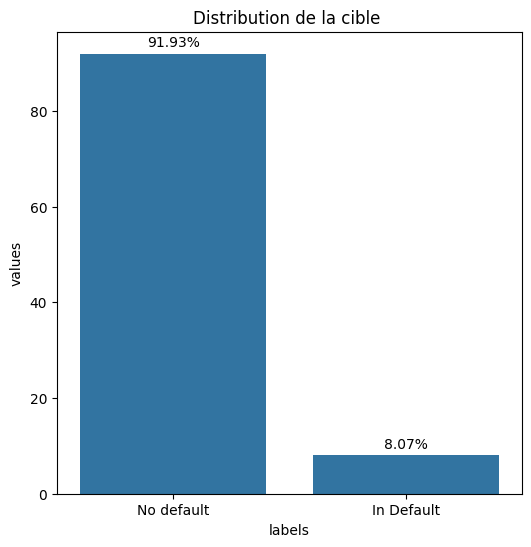

In [68]:
temp = train["TARGET"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': (temp.values/temp.sum())*100
                  })

cible = ['No default', 'In Default']

plt.figure(figsize = (6,6))
plt.title('Distribution de la cible ')
sns.set_color_codes("pastel")
ax = sns.barplot(x = 'labels', y="values", data=df)
locs, labels = plt.xticks()
colors = ['green', 'red']
ax.set_xticklabels(cible)

# Ajouter les annotations sur les barres
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    plt.annotate("%.2f" % p.get_height() + '%',
                (p.get_x()+p.get_width()/2, p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 8),
                textcoords='offset points',
                fontsize = 10,
                )
plt.show()

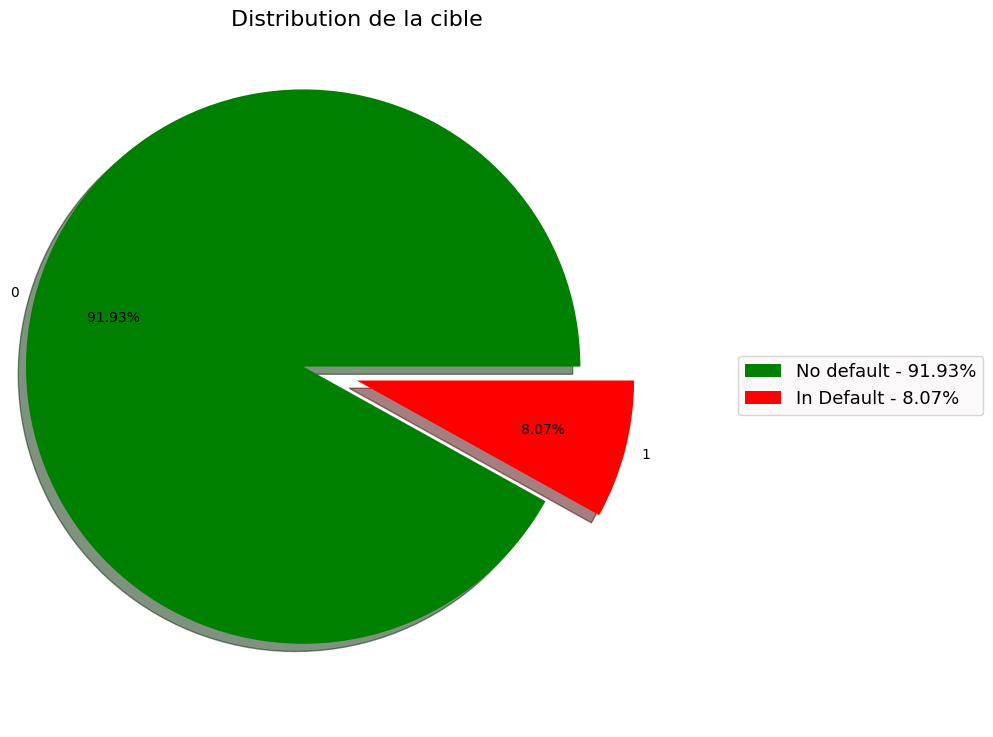

In [69]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        if (val/total)>0.01 :
          # return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
          return '{p:.2f}% '.format(p=pct)
    return my_autopct

plt.figure(figsize = (9, 9))

colors = ['green', 'red']
cible = ['No default', 'In Default']

sns.set_palette(sns.color_palette(colors))

y = df_app_train['TARGET'].value_counts().index
x = df_app_train['TARGET'].value_counts().values
labels =y

plt.pie(x, labels=y,
           explode = [0.2, 0],
           autopct = make_autopct(x),
           pctdistance = 0.7,
           labeldistance = 1.06,
           shadow = True)

plt.title('Distribution de la cible', fontsize=16)

plt.legend(y, loc=[1.05,0.45], labels=['%s - %1.2f%%' % (l, s) for l, s in zip(cible, (x/sum(x))*100)],fontsize=13,facecolor='#fbf8f8')

Sexe du client

Graphique séparé, le pourcentage des prêts (par sexe du client) avec la valeur CIBLE 1 (prêt non remboursé).

In [70]:
def plot_stats(feature,label_rotation=False,horizontal_layout=True):
    temp = df_app_train[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})

    # Calculate the percentage of target=1 per category value
    cat_perc = df_app_train[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    #cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)

    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x = feature, y="Number of contracts",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)

    s = sns.barplot(ax=ax2, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Percent of target with value 1 [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.show()

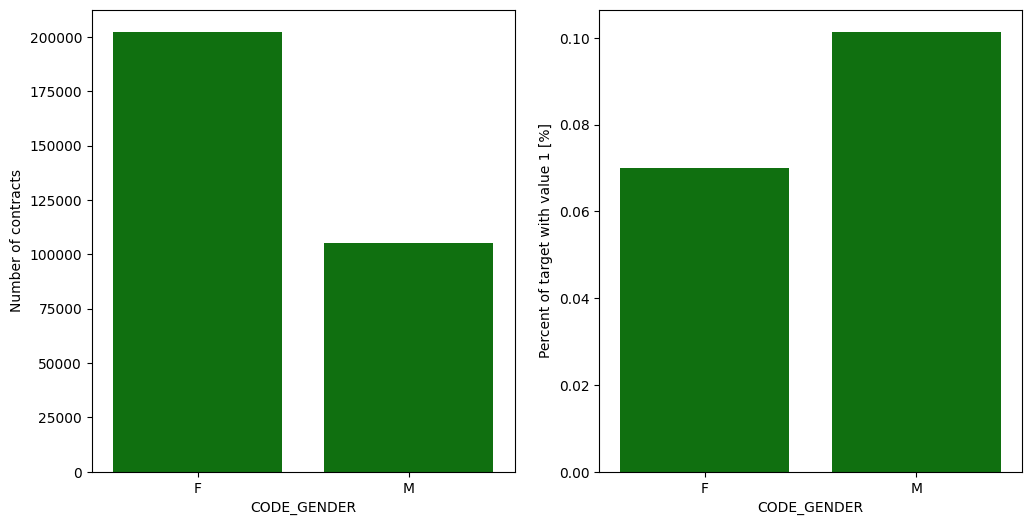

In [71]:
plot_stats('CODE_GENDER')

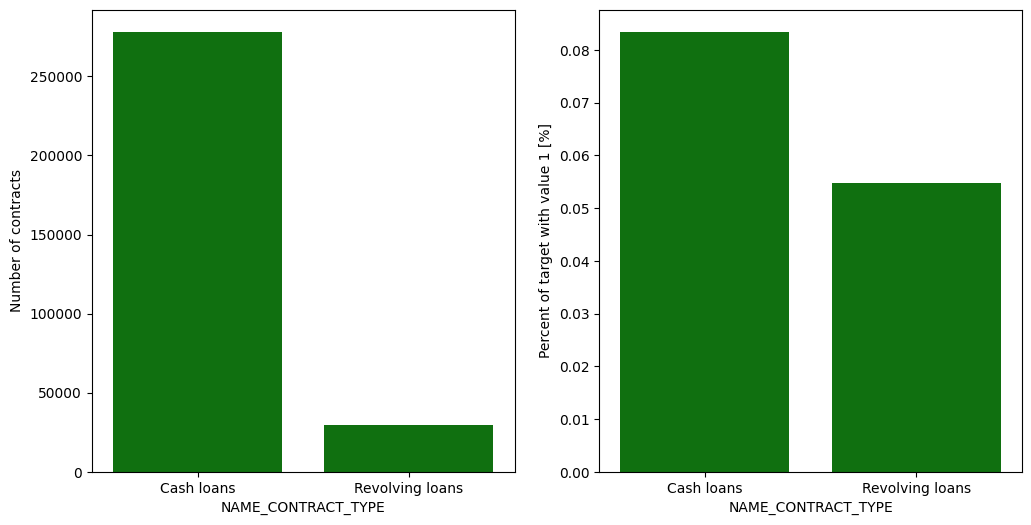

In [72]:
plot_stats('NAME_CONTRACT_TYPE')

Client avec ou sans voiture ou bien immobilier

Graphique qui indiquent si un client possède une voiture ou un bien immobilier
Graphique qui indiquent si un client possède une voiture ou un bien immobilier pour la cible 1

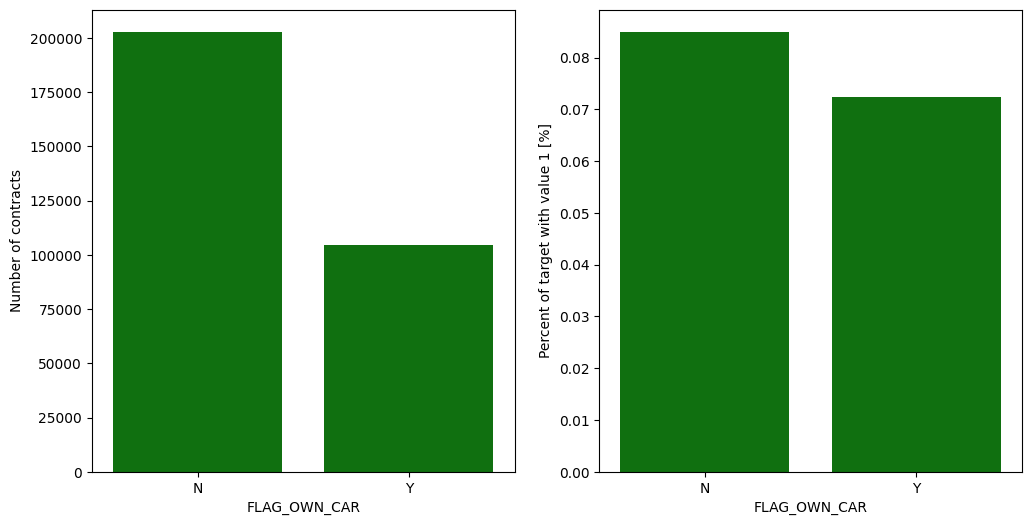

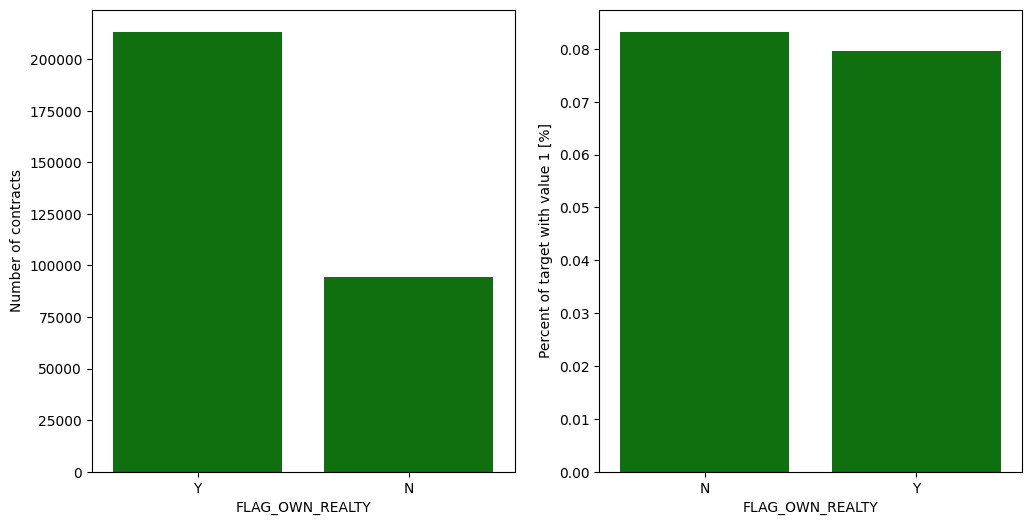

In [73]:
plot_stats('FLAG_OWN_CAR')
plot_stats('FLAG_OWN_REALTY')

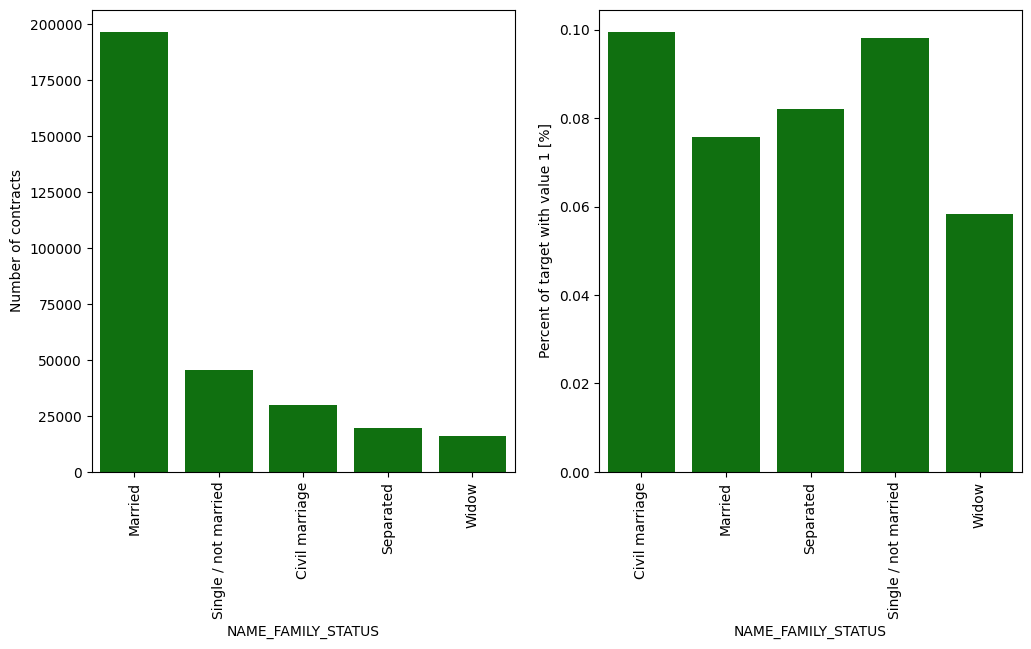

In [74]:
plot_stats('NAME_FAMILY_STATUS',True, True)

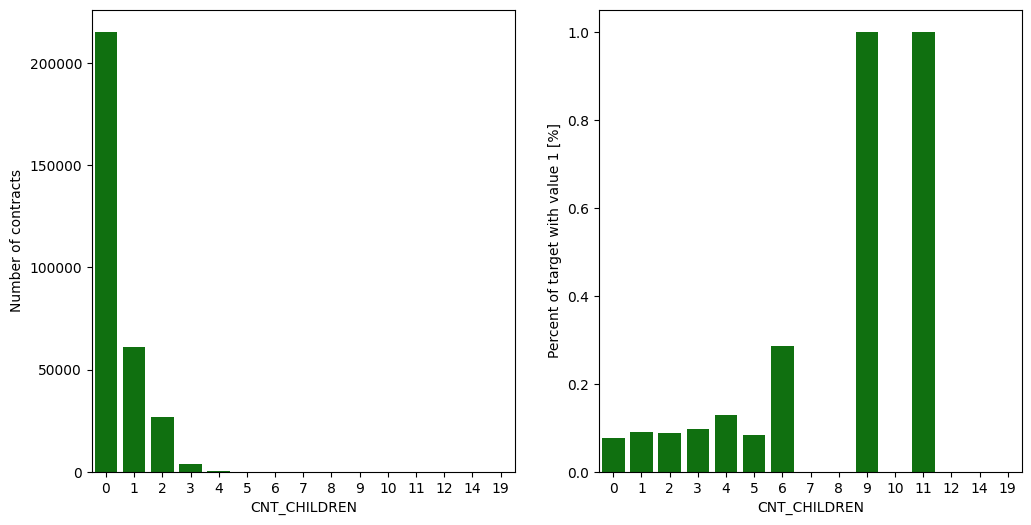

In [75]:
plot_stats('CNT_CHILDREN')

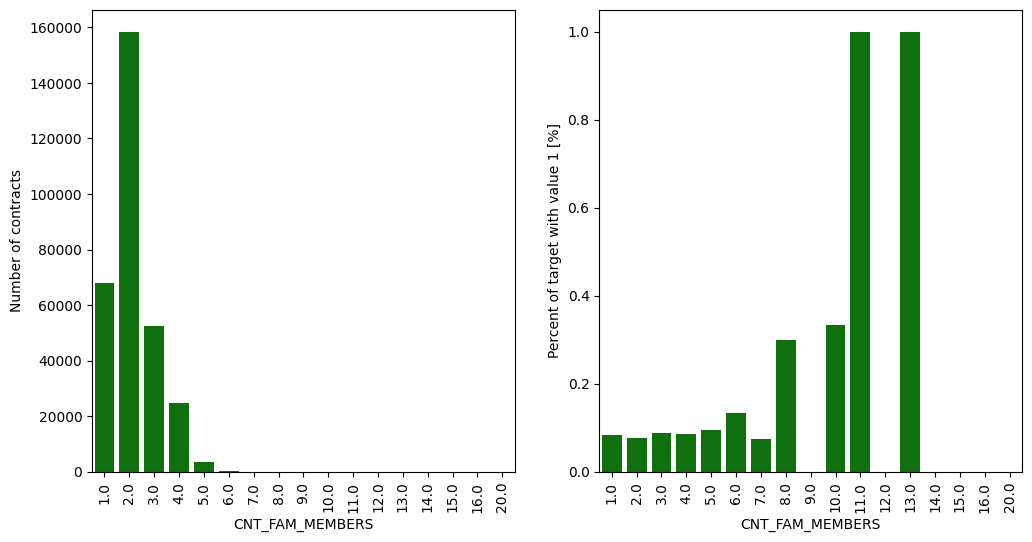

In [76]:
plot_stats('CNT_FAM_MEMBERS',True)

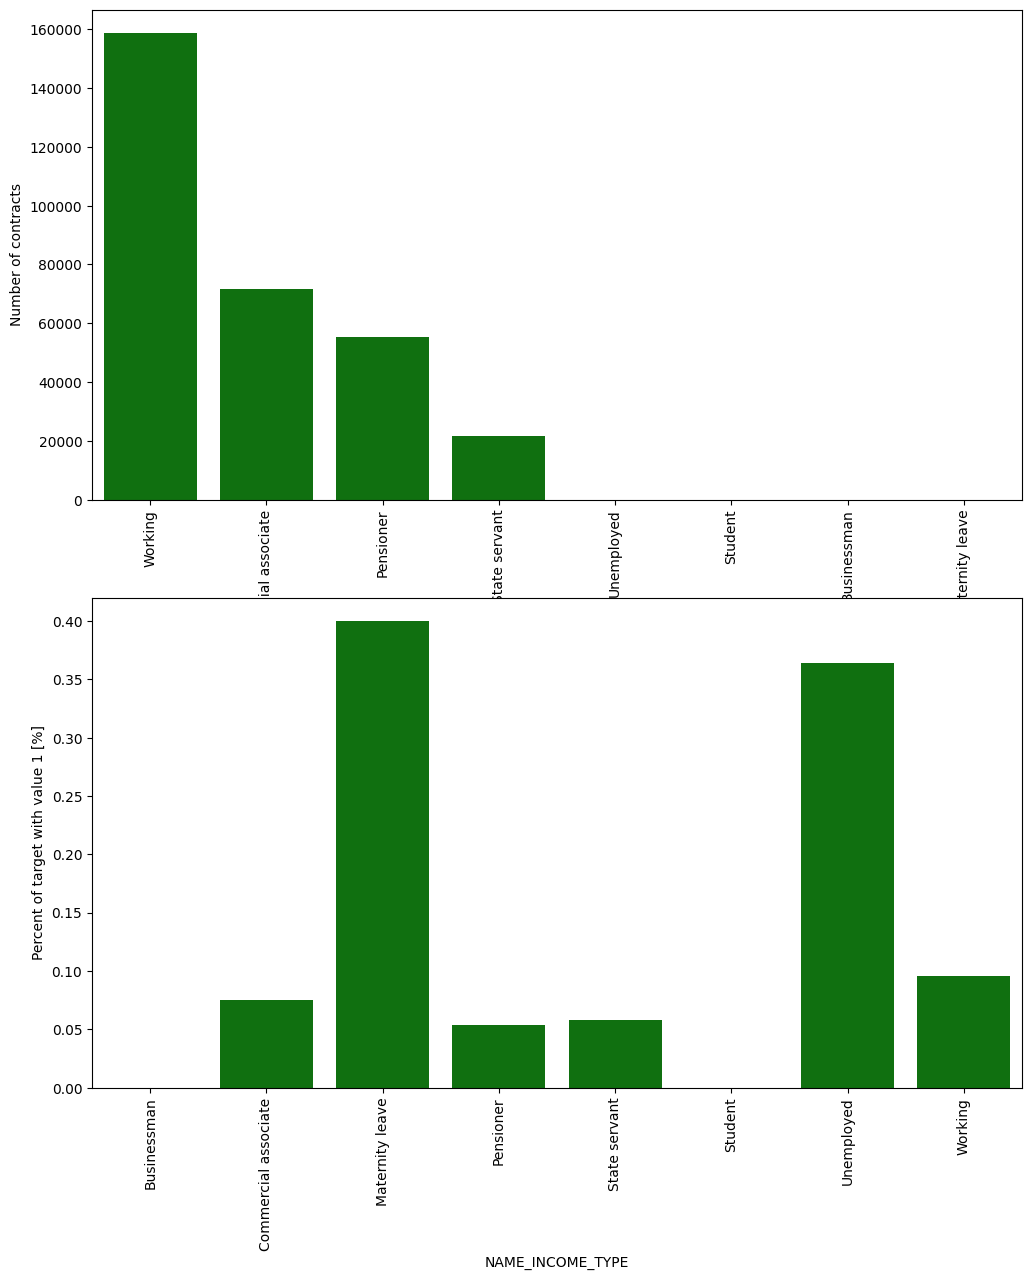

In [77]:
plot_stats('NAME_INCOME_TYPE',True,False)

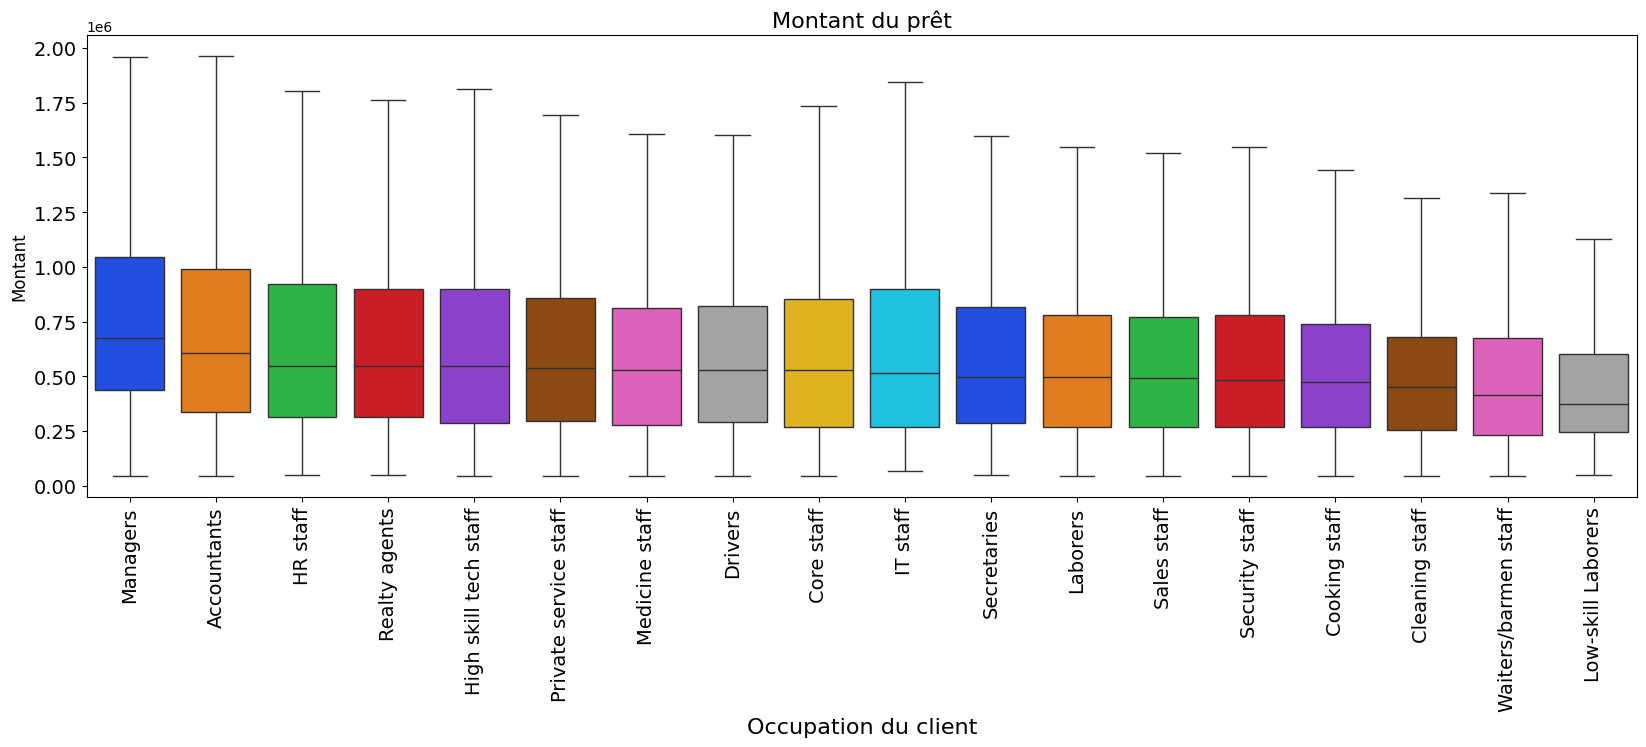

In [78]:
fig, ax = plt.subplots()

var_y = df_app_train['AMT_CREDIT']

grouped = df_app_train.loc[:,['OCCUPATION_TYPE', 'AMT_CREDIT']] \
    .groupby(['OCCUPATION_TYPE']) \
    .median() \
    .sort_values(by='AMT_CREDIT', ascending=False).head(20)



sns.boxplot(x= df_app_train['OCCUPATION_TYPE'], y = df_app_train['AMT_CREDIT'], data = df_app_train, order=grouped.index,showfliers=False, palette='bright')

fig.set_size_inches(20, 6)
ax.set_ylabel('Montant', fontsize=12)
ax.set_title("Montant du prêt", fontsize=16)

plt.xticks(rotation='vertical', fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Occupation du client', fontsize=16);

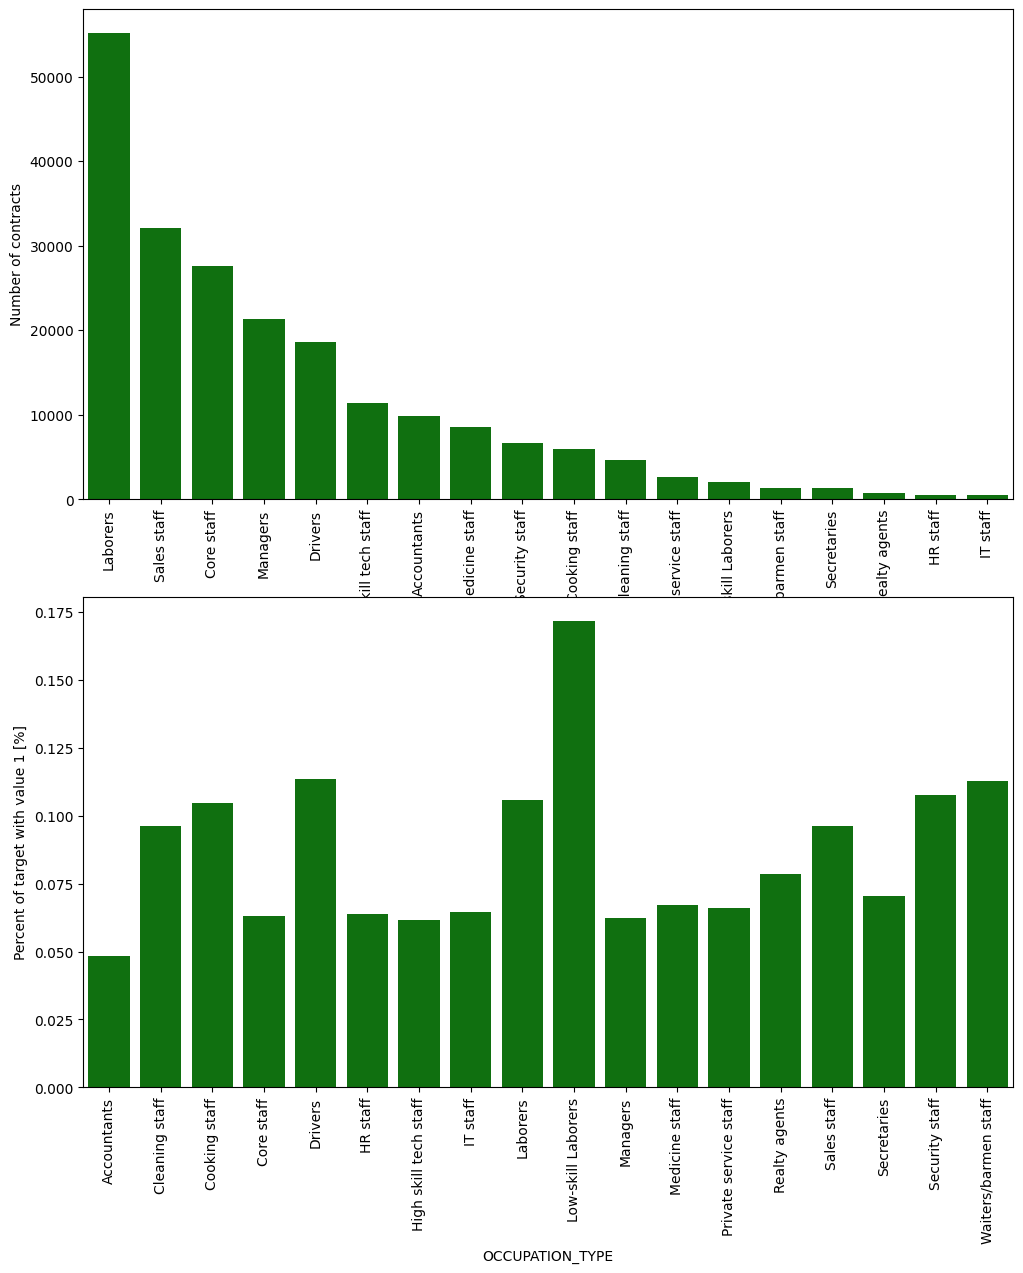

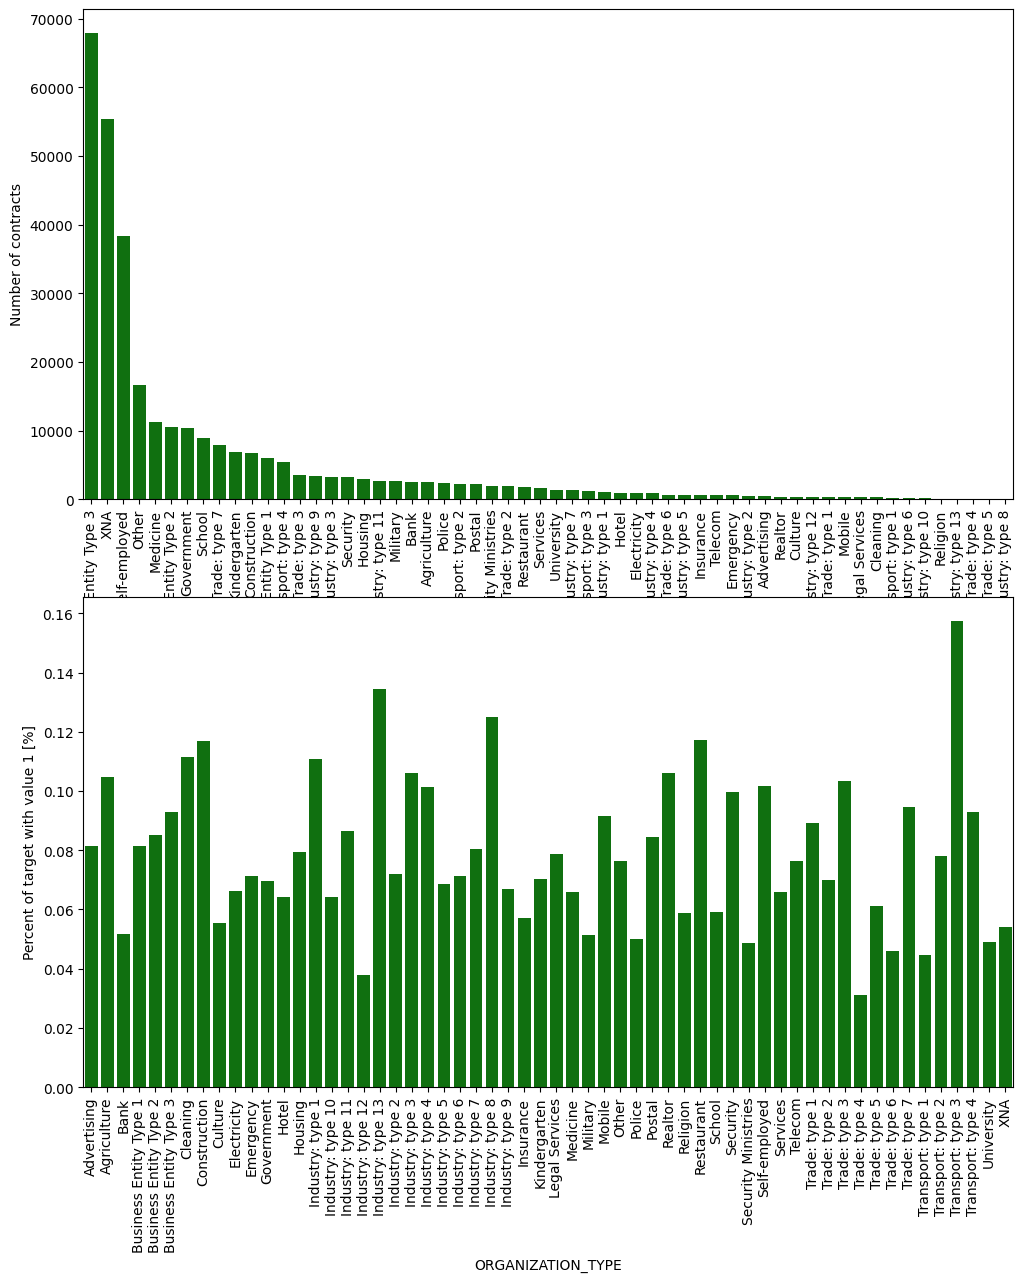

In [79]:
plot_stats('OCCUPATION_TYPE',True, False)
plot_stats('ORGANIZATION_TYPE',True, False)

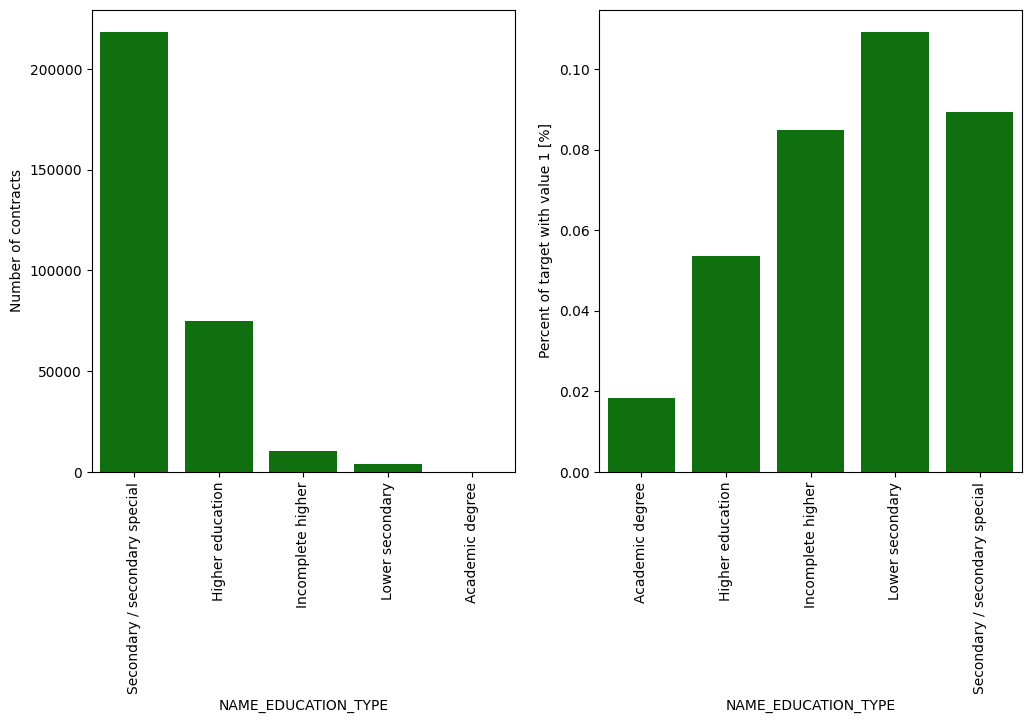

In [80]:
plot_stats('NAME_EDUCATION_TYPE',True)

In [81]:
# Plot distribution of multiple features, with TARGET = 1/0 on the same graph
def plot_distribution_comp(var,nrow=2):

    colors = ['red', 'green']
    i = 0
    t1 = df_train.loc[df_train['TARGET'] != 0]
    t0 = df_train.loc[df_train['TARGET'] == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(nrow,2,figsize=(12,6*nrow))

    for feature in var:
        i += 1
        plt.subplot(nrow,2,i)
        sns.kdeplot(t0[feature], bw_adjust=0.5,label="TARGET = 0")
        sns.kdeplot(t1[feature], bw_adjust=0.5,label="TARGET = 1")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
#         client = df_train[feature][df_train['SK_ID_CURR'] == 100020].values[0]
#         plt.axvline(client, c='red')
        plt.legend()
    plt.show()

<Figure size 640x480 with 0 Axes>

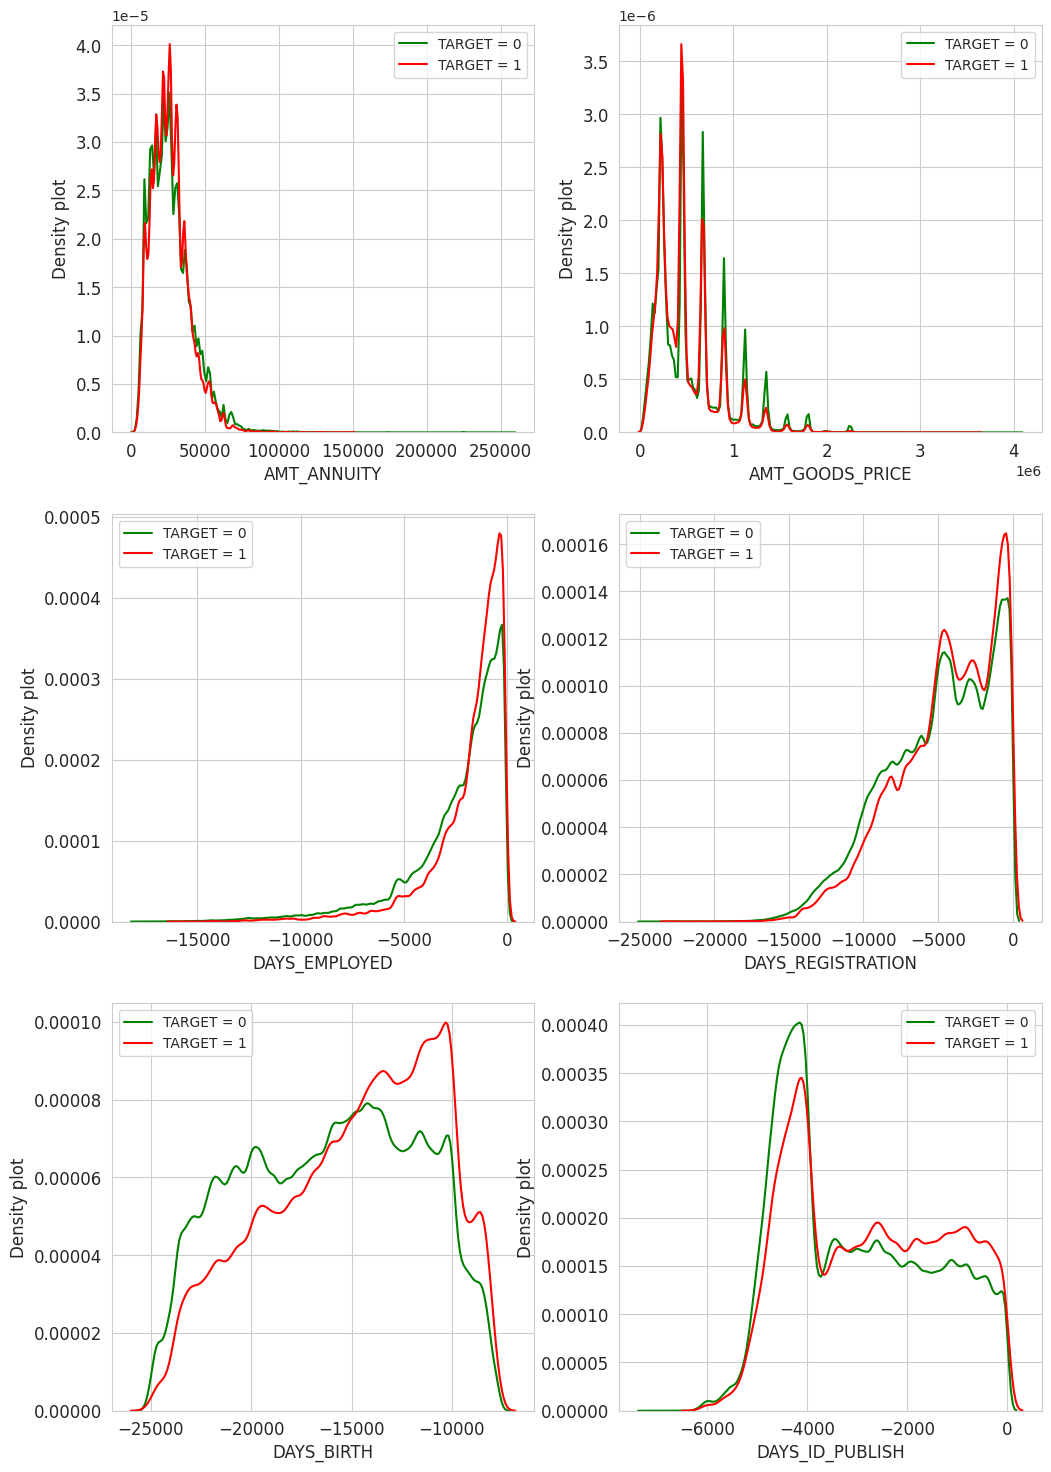

In [82]:
var = ['AMT_ANNUITY','AMT_GOODS_PRICE','DAYS_EMPLOYED', 'DAYS_REGISTRATION','DAYS_BIRTH','DAYS_ID_PUBLISH']
plot_distribution_comp(var,nrow=3)

## Transformation et encodage des données

Supprimer les caractères spéciaux des noms des colonnes

In [83]:
df_train = df_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', ' ', x))

In [84]:
df_train.shape

(307505, 267)

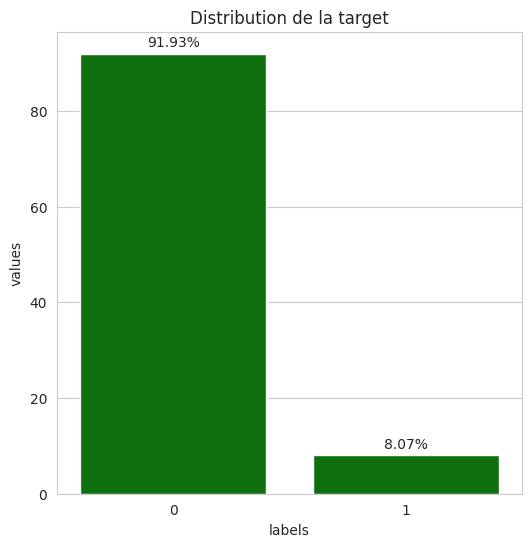

In [85]:
temp = df_train["TARGET"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': (temp.values/temp.sum())*100
                  })
plt.figure(figsize = (6,6))
plt.title('Distribution de la target')
sns.set_color_codes("pastel")
ax = sns.barplot(x = 'labels', y="values", data=df)
locs, labels = plt.xticks()

# Ajouter les annotations sur les barres
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    plt.annotate("%.2f" % p.get_height() + '%',
                (p.get_x()+p.get_width()/2, p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 8),
                textcoords='offset points',
                fontsize = 10,
                )
plt.show()

In [86]:
# Missing Value
def missing_values(data, plot=False):
    mst = pd.DataFrame(
        {"Num_Missing": data.isnull().sum(), "Missing_Ratio": data.isnull().sum() / data.shape[0]}).sort_values(
        "Num_Missing", ascending=False)
    mst["DataTypes"] = data[mst.index].dtypes.values
    mst = mst[mst.Num_Missing > 0].reset_index().rename({"index": "Feature"}, axis=1)

    print("Number of Variables include Missing Values:", mst.shape[0], "\n")

    if mst[mst.Missing_Ratio >= 0.3].shape[0] > 0:
        print("Full Missing Variables:", mst[mst.Missing_Ratio >= 1.0].Feature.tolist())
        data.drop(mst[mst.Missing_Ratio >= 1.0].Feature.tolist(), axis=1, inplace=True)

        print("Full missing variables are deleted!", "\n")

    if plot:
        plt.figure(figsize=(25, 8))
        p = sns.barplot(mst.Feature, mst.Missing_Ratio)
        for rotate in p.get_xticklabels():
            rotate.set_rotation(90)
        plt.show()

    print(mst, "\n")

In [87]:
missing_values(df_train, plot=False)

Number of Variables include Missing Values: 201 

                            Feature  Num_Missing  Missing_Ratio DataTypes
0      APPROVED_DAYS_FIRST_DUE_MEAN        91221       0.296649   float64
1          PREV_DAYS_FIRST_DUE_MEAN        91221       0.296649   float64
2        ACTIVE_AMT_CREDIT_SUM_MEAN        90361       0.293852   float64
3    ACTIVE_CNT_CREDIT_PROLONG_MEAN        90360       0.293849   float64
4           ACTIVE_DAYS_CREDIT_MEAN        90360       0.293849   float64
..                              ...          ...            ...       ...
196        DEF_60_CNT_SOCIAL_CIRCLE         1021       0.003320   float64
197                 AMT_GOODS_PRICE          276       0.000898   float64
198                 EXT_SOURCE_MEAN          172       0.000559   float64
199                     AMT_ANNUITY           12       0.000039   float64
200          DAYS_LAST_PHONE_CHANGE            1       0.000003   float64

[201 rows x 4 columns] 



compter les valeurs infinies

In [88]:
count = np.isinf(df_train).values.sum()
count

0

Copier df_train

In [89]:
df_train1 = df_train.copy()

In [90]:
print('Missing value: %d' % sum(df_train1.isna().sum()))

Missing value: 12185175


## Anomalies

Ont doit toujours regarder les Anomalies. Cela peut être dû à des chiffres mal saisis, à des erreurs dans l'équipement de mesure ou à des mesures valides mais extrêmes.
Les nombres de la colonne DAYS_BIRTH sont négatifs car ils sont enregistrés par rapport à la demande de prêt en cours. Pour voir ces statistiques en années, on peut multiplier par -1 et diviser par le nombre de jours dans une année :

In [91]:
(df_train1['DAYS_BIRTH'] / -365).describe()

count    307505.000000
mean         43.937122
std          11.956131
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

'DAYS_BIRTH' a l'air ok

In [92]:
df_train1['DAYS_EMPLOYED'].describe()

count    252131.000000
mean      -2384.155641
std        2338.331744
min      -17912.000000
25%       -3175.000000
50%       -1648.000000
75%        -767.000000
max           0.000000
Name: DAYS_EMPLOYED, dtype: float64

## Traitement des valeurs manquantes

In [93]:
# Initialiser SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# Affecter les colonnes avec les valeurs manquantes
col_nan = df_train1.columns[df_train1.isnull().any()].values

# X = imputer.fit_transform(df_train1)
df_train1[col_nan] = imputer.fit_transform(df_train1[col_nan])
df_train1.head()

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0      100002       1                   0            0             0   
1      100003       0                   0            1             0   
2      100004       0                   1            0             1   
3      100006       0                   0            1             0   
4      100007       0                   0            0             0   

   FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                0             0          202500.0    406597.5      24700.5   
1                1             0          270000.0   1293502.5      35698.5   
2                0             0           67500.0    135000.0       6750.0   
3                0             0          135000.0    312682.5      29686.5   
4                0             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0         351000.0                    0.018801       -9461         -637.0   
1        1129500.0                    0.003541      -16765        -1188.0   
2         135000.0                    0.010032      -19046         -225.0   
3         297000.0                    0.008019      -19005        -3039.0   
4         513000.0                    0.028663      -19932        -3038.0   

   DAYS_REGISTRATION  DAYS_ID_PUBLISH  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0            -3648.0            -2120              1.0                     2   
1            -1186.0             -291              2.0                     1   
2            -4260.0            -2531              1.0                     2   
3            -9833.0            -2437              2.0                     2   
4            -4311.0            -3458              1.0                     2   

   REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
0                            2                       10   
1                            1                       11   
2                            2                        9   
3                            2                       17   
4                            2                       11   

   OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
0                       2.0                       2.0   
1                       1.0                       0.0   
2                       0.0                       0.0   
3                       2.0                       0.0   
4                       0.0                       0.0   

   OBS_60_CNT_SOCIAL_CIRCLE  DEF_60_CNT_SOCIAL_CIRCLE  DAYS_LAST_PHONE_CHANGE  \
0                       2.0                       2.0                 -1134.0   
1                       1.0                       0.0                  -828.0   
2                       0.0                       0.0                  -815.0   
3                       2.0                       0.0                  -617.0   
4                       0.0                       0.0                 -1106.0   

   AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                    0.000000                      0.000   
1                    0.000000                      0.000   
2                    0.000000                      0.000   
3                    0.006403                      0.007   
4                    0.000000                      0.000   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                    0.000000                   0.000000   
1                    0.000000                   0.000000   
2                    0.000000                   0.000000   
3                    0.034363                   0.267389   
4                    0.000000                   0.000000   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  REGION  \
0                   0.000000                    1.000000       0   
1                   0.000000                    0.000000       0   
2                   0.000000            

Nombre de valeurs manquantes

In [94]:
print('Missing value: %d' % sum(df_train1.isna().sum()))

Missing value: 0


Enregistrer notre dataframe finale

In [95]:
df_train1.reset_index(drop=True)
df_train1 = reduce_mem_usage(df_train1)
df_train1.to_csv('df_train1.csv', index = False)

Memory usage of dataframe is 527.87 MB
Memory usage after optimization is: 167.74 MB
Decreased by 68.2%


In [96]:
df_train1 = reduce_mem_usage(pd.read_csv("df_train1.csv"))

Memory usage of dataframe is 626.40 MB
Memory usage after optimization is: 167.74 MB
Decreased by 73.2%


In [97]:
df_train1.head()

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0      100002       1                   0            0             0   
1      100003       0                   0            1             0   
2      100004       0                   1            0             1   
3      100006       0                   0            1             0   
4      100007       0                   0            0             0   

   FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                0             0          202500.0    406597.5      24700.5   
1                1             0          270000.0   1293502.5      35698.5   
2                0             0           67500.0    135000.0       6750.0   
3                0             0          135000.0    312682.5      29686.5   
4                0             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0         351000.0                    0.018799       -9461         -637.0   
1        1129500.0                    0.003542      -16765        -1188.0   
2         135000.0                    0.010033      -19046         -225.0   
3         297000.0                    0.008018      -19005        -3040.0   
4         513000.0                    0.028656      -19932        -3038.0   

   DAYS_REGISTRATION  DAYS_ID_PUBLISH  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0            -3648.0            -2120              1.0                     2   
1            -1186.0             -291              2.0                     1   
2            -4260.0            -2531              1.0                     2   
3            -9832.0            -2437              2.0                     2   
4            -4312.0            -3458              1.0                     2   

   REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
0                            2                       10   
1                            1                       11   
2                            2                        9   
3                            2                       17   
4                            2                       11   

   OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
0                       2.0                       2.0   
1                       1.0                       0.0   
2                       0.0                       0.0   
3                       2.0                       0.0   
4                       0.0                       0.0   

   OBS_60_CNT_SOCIAL_CIRCLE  DEF_60_CNT_SOCIAL_CIRCLE  DAYS_LAST_PHONE_CHANGE  \
0                       2.0                       2.0                 -1134.0   
1                       1.0                       0.0                  -828.0   
2                       0.0                       0.0                  -815.0   
3                       2.0                       0.0                  -617.0   
4                       0.0                       0.0                 -1106.0   

   AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                    0.000000                      0.000   
1                    0.000000                      0.000   
2                    0.000000                      0.000   
3                    0.006401                      0.007   
4                    0.000000                      0.000   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                    0.000000                   0.000000   
1                    0.000000                   0.000000   
2                    0.000000                   0.000000   
3                    0.034363                   0.267334   
4                    0.000000                   0.000000   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  REGION  \
0                   0.000000                    1.000000       0   
1                   0.000000                    0.000000       0   
2                   0.000000            

# Modélisation

In [98]:
df_train1 = reduce_mem_usage(pd.read_csv("df_train1.csv"))

Memory usage of dataframe is 626.40 MB
Memory usage after optimization is: 167.74 MB
Decreased by 73.2%


In [99]:
df_train1.memory_usage().sum() / 1024**2

167.74462509155273

In [100]:
df_train1['TARGET'].value_counts(normalize=True)

TARGET
0    0.91927
1    0.08073
Name: proportion, dtype: float64

Notre classifications est baias, n'est pas equilibre

Un problème avec une classification déséquilibrée est qu’il y a trop peu d’exemples de classe minoritaire pour qu’un modèle puisse apprendre efficacement la limite de décision.

Une façon de résoudre ce problème consiste à suréchantillonner les exemples de la classe minoritaire. Ceci peut être réalisé en dupliquant simplement des exemples de la classe minoritaire dans l'ensemble de données de formation avant d'ajuster un modèle. Cela peut équilibrer la répartition des classes mais ne fournit aucune information supplémentaire au modèle.

https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

## Modèle LightGBM

### **Methode 1 : Smote**

In [102]:
X = df_train1.iloc[ :, 2:]
y = df_train1.iloc[ :,1]

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=120,stratify=y)

In [104]:
y_test.value_counts()

TARGET
0    56536
1     4965
Name: count, dtype: int64

Nous allons nous assurer que nous avons les mêmes fractionnements de données à chaque fois. Nous pouvons nous en assurer en créant un KFold objet kf, et en passant cv=kf à la place du plus commun cv=5

In [105]:
df_train1[df_train1['TARGET']==1].head(5)

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0       100002       1                   0            0             0   
26      100031       1                   0            1             0   
40      100047       1                   0            0             0   
42      100049       1                   0            1             0   
81      100096       1                   0            1             0   

    FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                 0             0          202500.0    406597.5      24700.5   
26                0             0          112500.0    979992.0      27076.5   
40                0             0          202500.0   1193580.0      35028.0   
42                1             0          135000.0    288873.0      16258.5   
81                0             0           81000.0    252000.0      14593.5   

    AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0          351000.0                    0.018799       -9461         -637.0   
26         702000.0                    0.018036      -18724        -2628.0   
40         855000.0                    0.025162      -17482        -1262.0   
42         238500.0                    0.007305      -13384        -3596.0   
81         252000.0                    0.028656      -24794        -2384.0   

    DAYS_REGISTRATION  DAYS_ID_PUBLISH  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0             -3648.0            -2120              1.0                     2   
26            -6572.0            -1827              1.0                     3   
40            -1182.0            -1029              2.0                     2   
42              -45.0            -4409              2.0                     3   
81            -5392.0            -4199              2.0                     2   

    REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
0                             2                       10   
26                            2                        9   
40                            2                        9   
42                            3                       11   
81                            2                       10   

    OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
0                        2.0                       2.0   
26                      10.0                       1.0   
40                       0.0                       0.0   
42                       1.0                       0.0   
81                       1.0                       1.0   

    OBS_60_CNT_SOCIAL_CIRCLE  DEF_60_CNT_SOCIAL_CIRCLE  \
0                        2.0                       2.0   
26                      10.0                       0.0   
40                       0.0                       0.0   
42                       1.0                       0.0   
81                       1.0                       1.0   

    DAYS_LAST_PHONE_CHANGE  AMT_REQ_CREDIT_BUREAU_HOUR  \
0                  -1134.0                         0.0   
26                  -161.0                         0.0   
40                 -1075.0                         0.0   
42                 -1480.0                         0.0   
81                     0.0                         0.0   

    AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_WEEK  \
0                         0.0                         0.0   
26                        0.0                         0.0   
40                        0.0                         0.0   
42                        0.0                         0.0   
81                        0.0                         0.0   

    AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  \
0                         0.0                        0.0   
26                        0.0                        2.0   
40                        2.0                        0.0   
42                        0.0                        0.0   
81                        0.0                        

In [106]:
# cross validation
kf = KFold(n_splits=5,shuffle=False)

In [107]:
# Parameter Grid
param_distributions = {
                        'learning_rate':[0.01, 0.1,0.09],
                        'reg_alpha': [0,7, 10,20],
                        'n_estimators': [100,400,800,1000],
                        'max_depth': [5,10,20],
                        'colsample_bytree': [0.01, 0.1,0.2,0.3],
                        'min_child_samples': [10,20,50],
                        'min_child_weight':[5,10,20],
                        'num_leaves':[10,15,20],
                        'reg_lambda':[10,50,70,100],
                        'scale_pos_weight':[6,7,8,10,11,12,15,17],
}

In [108]:
pipeline = Pipeline([
        ('smote', SMOTE()),
        ('lgbm', LGBMClassifier())
    ])

params_lgbm = {'lgbm__' + key: param_distributions[key] for key in param_distributions}

# Nous utilisons RandomizedSearchCV au lieu de GridSearchCV car nous avons un grand ensemble de données et celui-ci est plus rapide
random_search_smote = RandomizedSearchCV(estimator=pipeline,
                           param_distributions=params_lgbm,
                           scoring='roc_auc',
                           cv=kf,
                           n_iter=9             )

random_search_smote.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180912, number of negative: 180912
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.178099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60353
[LightGBM] [Info] Number of data points in the train set: 361824, number of used features: 252
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 180944, number of negative: 180944
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.175854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6027

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('smote', SMOTE()),
                                             ('lgbm', LGBMClassifier())]),
                   n_iter=9,
                   param_distributions={'lgbm__colsample_bytree': [0.01, 0.1,
                                                                   0.2, 0.3],
                                        'lgbm__learning_rate': [0.01, 0.1,
                                                                0.09],
                                        'lgbm__max_depth': [5, 10, 20],
                                        'lgbm__min_child_samples': [10, 20, 50],
                                        'lgbm__min_child_weight': [5, 10, 20],
                                        'lgbm__n_estimators': [100, 400, 800,
                                                               1000],
                                        'lgbm__num_leaves': [10, 15, 20],
                                        'lgbm__reg_alpha': [0, 7, 10, 20],
                                        'lgbm__reg_lambda': [10, 50, 70, 100],
                                        'lgbm__scale_pos_weight': [6, 7, 8, 10,
                                                                   11, 12, 15,
                                                                   17]},
                   scoring='roc_auc')

In [109]:
y_train.value_counts()

TARGET
0    226144
1     19860
Name: count, dtype: int64

In [110]:
best_param = random_search_smote.best_params_
best_param

{'lgbm__scale_pos_weight': 17,
 'lgbm__reg_lambda': 50,
 'lgbm__reg_alpha': 20,
 'lgbm__num_leaves': 15,
 'lgbm__n_estimators': 400,
 'lgbm__min_child_weight': 5,
 'lgbm__min_child_samples': 20,
 'lgbm__max_depth': 10,
 'lgbm__learning_rate': 0.1,
 'lgbm__colsample_bytree': 0.2}

In [111]:
# Meilleur score du RandomizedSearchCV
random_search_smote.best_score_

0.761302060836991

Enregistrer le meilleur score RandomizedSearchCV

In [112]:
best_lgbm_smote = random_search_smote.best_estimator_

In [113]:
# enregistrer le modèle dans un fichier
joblib.dump(best_lgbm_smote, 'best_lgbm_smote_model.joblib')

['best_lgbm_smote_model.joblib']

In [114]:
filename = 'best_lgbm_smote.sav'
pickle.dump(best_lgbm_smote, open(filename, 'wb'))

In [115]:
# # infer signature with params
# signature = infer_signature(X_train, y_train)

Prédire le résultat sur les données test

In [116]:
y_pred_smote=best_lgbm_smote.predict_proba(X_test)

Score AUC

In [117]:
print('LightGBM RandomizedSearchCV Model ROCAUC score: {0:0.4f}'.format(roc_auc_score(y_test, y_pred_smote[:, 1])))

LightGBM RandomizedSearchCV Model ROCAUC score: 0.7715


In [118]:
#Afficher les scores
print('LightGBM RandomizedSearchCV Model precision score: {0:0.4f}'.format(precision_score(y_test, np.argmax(y_pred_smote,axis = 1))))
print('LightGBM RandomizedSearchCV Model recall score: {0:0.4f}'.format(recall_score(y_test, np.argmax(y_pred_smote,axis = 1))))

print('LightGBM RandomizedSearchCV Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, np.argmax(y_pred_smote,axis = 1))))
print('LightGBM RandomizedSearchCV Model F1 score: {0:0.4f}'.format(f1_score(y_test, np.argmax(y_pred_smote,axis = 1))))

LightGBM RandomizedSearchCV Model precision score: 0.1443
LightGBM RandomizedSearchCV Model recall score: 0.8064
LightGBM RandomizedSearchCV Model accuracy score: 0.5982
LightGBM RandomizedSearchCV Model F1 score: 0.2447


Rapport de classification

In [119]:
print('Classification Report')
print(classification_report(y_test, np.argmax(y_pred_smote,axis = 1)))

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.58      0.73     56536
           1       0.14      0.81      0.24      4965

    accuracy                           0.60     61501
   macro avg       0.56      0.69      0.49     61501
weighted avg       0.90      0.60      0.69     61501



Matrice de confusion

[Text(0, 0.5, 'No Default'), Text(0, 1.5, 'In Default')]

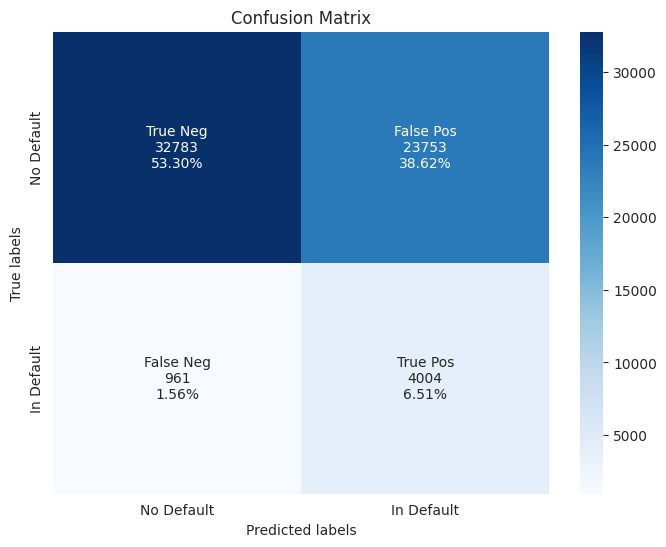

In [120]:

cm = confusion_matrix(y_test, np.argmax(y_pred_smote,axis = 1))

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

# étiquettes, titres et graduations
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['No Default', 'In Default'])
ax.yaxis.set_ticklabels(['No Default', 'In Default'])

predit_proba

In [122]:
def credit_decision(customers_data, model, threshold):
    '''- threshold: The probability threshold to classify credits as approved (0) or defaulted (1).'''

    # Prédire les probabilités pour toutes les classes à l'aide du modèle
    y_pred_proba = model.predict_proba(customers_data)[:, 1]

    # Créer un DataFrame avec les identifiants des clients et leur probabilité par défaut
    customer_probabilities = pd.DataFrame({
        'Customer ID': customers_data.index,
        'Probability of Default': y_pred_proba,
        'Credit Decision': (y_pred_proba > threshold).astype(int)
    })

    # Renvoyer le DataFrame avec les identifiants client, la probabilité de défaut et la décision de crédit
    return customer_probabilities


In [123]:
# credit_decision (df_train1, best_lgbm_smote, 0.725)
credit_decision(X_test, best_lgbm_smote, 0.725)

Customer ID  Probability of Default  Credit Decision
0           216689                0.105960                0
1            37196                0.627418                0
2            57170                0.244069                0
3           269993                0.605747                0
4           134505                0.210379                0
...            ...                     ...              ...
61496       248676                0.203167                0
61497       221907                0.588803                0
61498       195437                0.251367                0
61499       271682                0.850476                1
61500       283531                0.276412                0

[61501 rows x 3 columns]

**Seuil optimal pour la courbe ROC**

Garder les probabilités que pour le résultat positif

In [124]:
y_pred_1 = y_pred_smote[:, 1]

In [125]:
def tune_threshold(true_labels, predicted_probas):
    fpr, tpr, threshold = roc_curve(true_labels, predicted_probas)
    j_stat = tpr - fpr
    index_for_best_threshold = np.argmax(j_stat)

    return threshold[index_for_best_threshold]


def proba_to_class(proba, threshold):
     return np.where(proba >= threshold, 1, 0)

# Annoter le seuil optimal AUC
def annot_auc(x,y, ax=None):
    plt.annotate("{:.3f}".format(y), xy=(x, y), xytext=(x*2, y/2), fontsize=12,
                     bbox=dict(facecolor='white', fc ="0.99", edgecolor='black', boxstyle='round'),
                     arrowprops=dict(arrowstyle = "->",connectionstyle = "angle,angleA=90,angleB=180,rad=0",color='black')
                     )

Calculer roc_curve pour obtenir le meilleur seuil

In [126]:
# calculer roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_pred_1)
# Meilleur seuil
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

Best Threshold=0.591459


Graphique ROC pour le modèle avec la classification déséquilibrée avec le seuil optimal

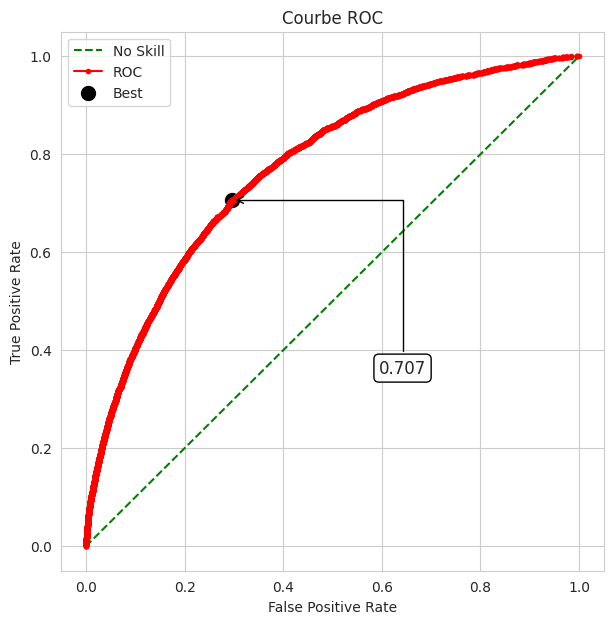

In [127]:
plt.figure(figsize=(7,7))

# graphique roc curve du modèle
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='ROC')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best',s=100)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.title('Courbe ROC')

annot_auc(fpr[ix],tpr[ix])

# Afficher le graphique
plt.show()

[Text(0, 0.5, 'No Default'), Text(0, 1.5, 'In Default')]

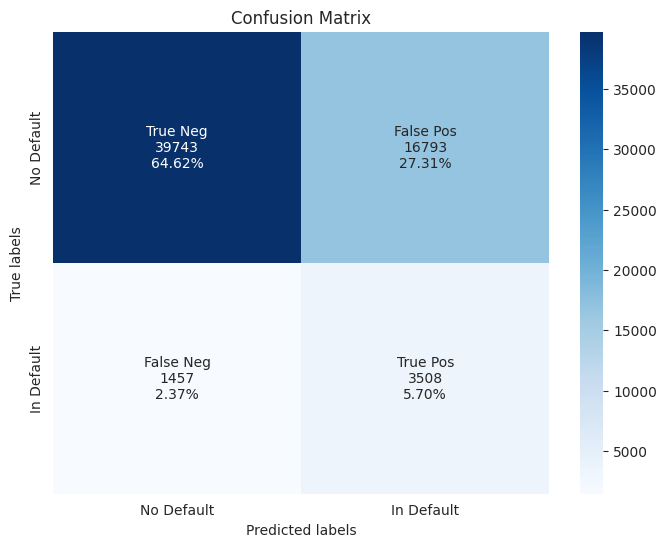

In [128]:
#Matrice de confusion
thresh_roc =proba_to_class(y_pred_1, tune_threshold(y_test, y_pred_1))

cm = confusion_matrix(y_test,thresh_roc)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['No Default', 'In Default'])
ax.yaxis.set_ticklabels(['No Default', 'In Default'])

In [129]:
#classification report
print('Classification Report')
print(classification_report(y_test, thresh_roc))

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.70      0.81     56536
           1       0.17      0.71      0.28      4965

    accuracy                           0.70     61501
   macro avg       0.57      0.70      0.55     61501
weighted avg       0.90      0.70      0.77     61501



In [130]:
#Aficher les scores
print('LightGBM RandomizedSearchCV Model precision score: {0:0.4f}'.format(precision_score(y_test, thresh_roc)))
print('LightGBM RandomizedSearchCV Model recall score: {0:0.4f}'.format(recall_score(y_test, thresh_roc)))

print('LightGBM RandomizedSearchCV Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, thresh_roc)))
print('LightGBM RandomizedSearchCV Model F1 score: {0:0.4f}'.format(f1_score(y_test, thresh_roc)))

LightGBM RandomizedSearchCV Model precision score: 0.1728
LightGBM RandomizedSearchCV Model recall score: 0.7065
LightGBM RandomizedSearchCV Model accuracy score: 0.7033
LightGBM RandomizedSearchCV Model F1 score: 0.2777


Seuil optimal pour la courbe de rappel / précision

Définir des seuils

In [131]:
from sklearn.metrics import precision_recall_curve

# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_1)

# Calculate F-score
fscore = np.zeros_like(precision)
denominator = precision + recall
denominator[denominator == 0] = np.nan  # Avoid division by zero
fscore = (2 * precision * recall) / denominator

# Locate the index of the largest F-score
ix = np.nanargmax(fscore)  # Ignore NaN values
best_threshold = thresholds[ix]
best_fscore = fscore[ix]

print(f"Best Threshold={best_threshold:.6f}, F-Score={best_fscore:.3f}")

Best Threshold=0.758570, F-Score=0.319


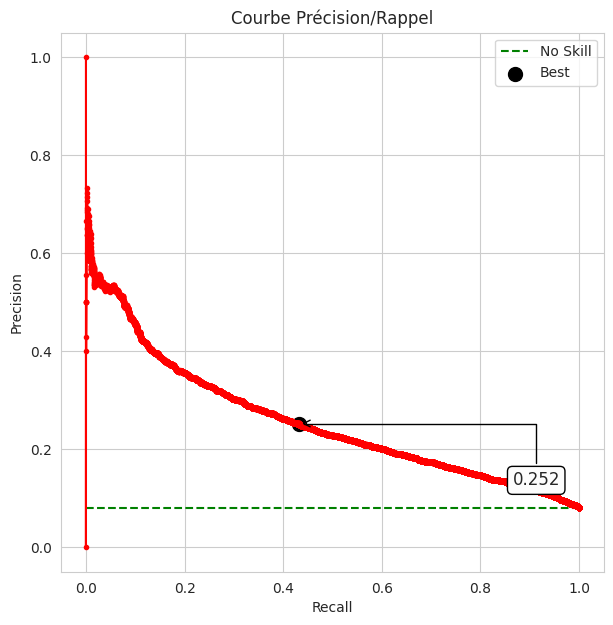

In [132]:
# plot the roc curve for the model
plt.figure(figsize=(7,7))
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best',s=100)
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

plt.title('Courbe Précision/Rappel')
annot_auc(recall[ix],precision[ix])

# show the plot
plt.show()

Fonction pour créer des labels en appliquant le seuil aux probabilités positives

In [133]:
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')
thresh_precision_recall =to_labels(y_pred_1, thresholds[ix])

[Text(0, 0.5, 'No Default'), Text(0, 1.5, 'In Default')]

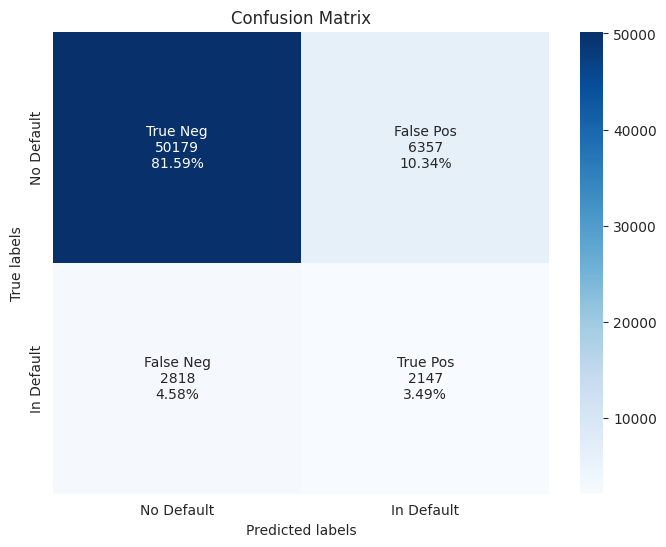

In [134]:
cm = confusion_matrix(y_test, thresh_precision_recall)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['No Default', 'In Default'])
ax.yaxis.set_ticklabels(['No Default', 'In Default'])

In [135]:
print('Classification Report')
print(classification_report(y_test, thresh_precision_recall))

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.89      0.92     56536
           1       0.25      0.43      0.32      4965

    accuracy                           0.85     61501
   macro avg       0.60      0.66      0.62     61501
weighted avg       0.89      0.85      0.87     61501



Afficher les scores

In [136]:
print('LightGBM RandomizedSearchCV Model precision score: {0:0.4f}'.format(precision_score(y_test, thresh_precision_recall)))
print('LightGBM RandomizedSearchCV Model recall score: {0:0.4f}'.format(recall_score(y_test, thresh_precision_recall)))

print('LightGBM RandomizedSearchCV Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, thresh_precision_recall)))
print('LightGBM RandomizedSearchCV Model F1 score: {0:0.4f}'.format(f1_score(y_test, thresh_precision_recall)))

LightGBM RandomizedSearchCV Model precision score: 0.2525
LightGBM RandomizedSearchCV Model recall score: 0.4324
LightGBM RandomizedSearchCV Model accuracy score: 0.8508
LightGBM RandomizedSearchCV Model F1 score: 0.3188


Afficher les caractéristiques les plus importantes :

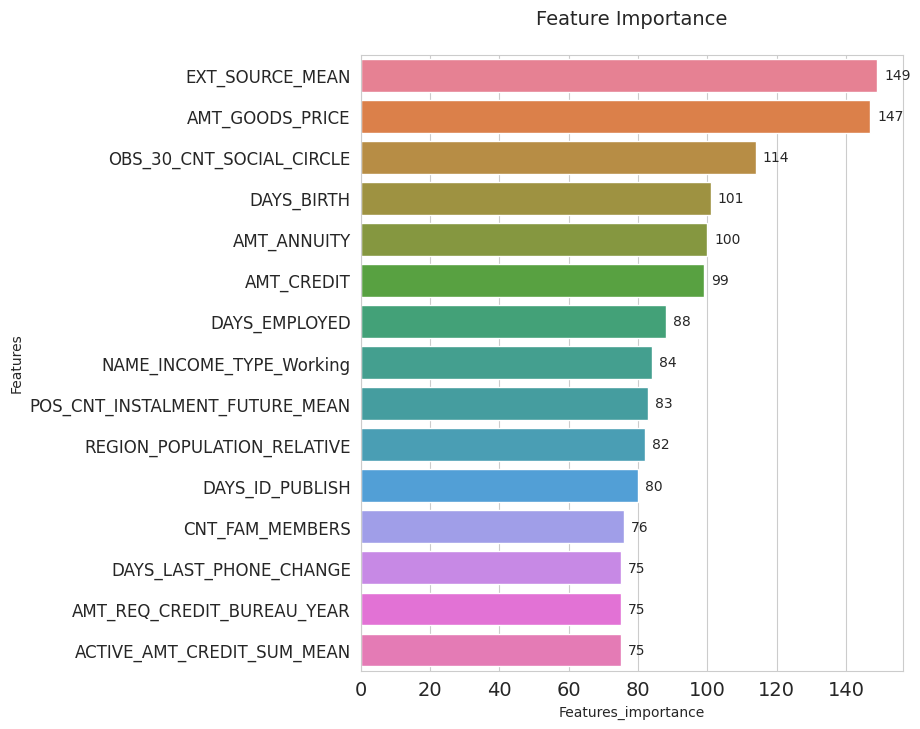

In [137]:
import warnings

# Créer dataframe des parametres les plus importantes
df_feature_importance=pd.DataFrame({'Features': df_train1.iloc[ :, 2:].columns,
              'Features_importance':best_lgbm_smote['lgbm'].feature_importances_
              })

df_feature_importance_15 = df_feature_importance.sort_values(by='Features_importance', ascending=False).head(15)

# Graphique des caractéristiques les plus importantes
fig, ax = plt.subplots()

ax = sns.barplot(x="Features_importance", y="Features", data=df_feature_importance_15, palette="husl")

# Ajouter les annotations sur les barres
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
                xytext=(5, 0), textcoords='offset points', ha="left", va="center")

# Ajouter des textes aux labels, titre etc.
fig.set_size_inches(7, 8)
ax.set_title("Feature Importance\n", fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.show()

**Seuil métier**

Le seuil optimal consiste à calculer le gain obtenu pour l'ensemble des individus du jeu de données.

Pour cela nous avons fixé un poids pour chacune des prédictions relativement à leurs valeurs réelles.

Les valeurs des poids sont les suivantes :

- fn_value = -10
- tp_value = 0
- tn_value = 0
- fp_value = -1

In [138]:
# Définition de la métrique 'banking'
def Ind_bank(y_test, y_pred, fn_value=-10, fp_value=-1, tp_value=0, tn_value=0):

    # Matrice de Confusion
    mat_conf = confusion_matrix(y_test, y_pred)

    # Nombre de True Negatifs
    tn = mat_conf[0, 0]
    # Nombre de Faux Négatifs
    fn = mat_conf[1, 0]
    # Nombre de Faux Positifs
    fp = mat_conf[0, 1]
    # Nombre de True Positifs
    tp = mat_conf[1, 1]

    # Gain normalisé entre 0 et 1
    J_normalized = fn_value*fn + fp_value*fp

    return J_normalized  # Retourne la fonction d'évaluation

# Evolution du gain en fonction du seuil de solvabilité fixé Si score < seuil : client solvable, Sinon : client non solvable
def gain_seuil(y_pred_1, y_set):

    """
    Evolution du gain en fonction du seuil de solvabilité fixé
    Si score < seuil : client solvable
    Sinon : client non solvable

    """
    cost_function = []
    threshold_x = np.linspace(0.0, 1, 1000)

    for threshold in threshold_x:


        # y_pred_1 > seuil de solvabilité : retourne 1 sinon 0
        y_pred = (y_pred_1 > threshold)

        y_pred = np.array(y_pred > 0) * 1
        # Calcul de l'indice bancaire
        cost_function.append(Ind_bank(y_set, y_pred))


    # Affichage du gain en fonction du seuil de solvabilité
    plt.figure(figsize=(8, 8))
    plt.plot(threshold_x, cost_function)
    annot_max(threshold_x,cost_function)
    plt.grid()
    plt.xlabel("Seuil de probabilité")
    plt.ylabel("Indice banquaire")
    plt.xticks(np.linspace(0.1, 1, 10))


# Fonction pour annoter le seuil de solvabilité dans le graphique
def annot_max(x,y, ax=None):
    ymax = max(y)
    xpos = np.argmax(y)
    xmax = x[xpos]

    text= "Seuil de solvabilité={:.3f}".format(xmax)
    plt.axvline(xmax, c='red', linewidth=0.9,  alpha=0.8)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(facecolor='white', fc ="0.99", edgecolor='black', boxstyle='round')
    arrowprops=dict(arrowstyle = "->",connectionstyle = "angle,angleA=90,angleB=180,rad=0",color='black')
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)

Graphique avec le seuil métier

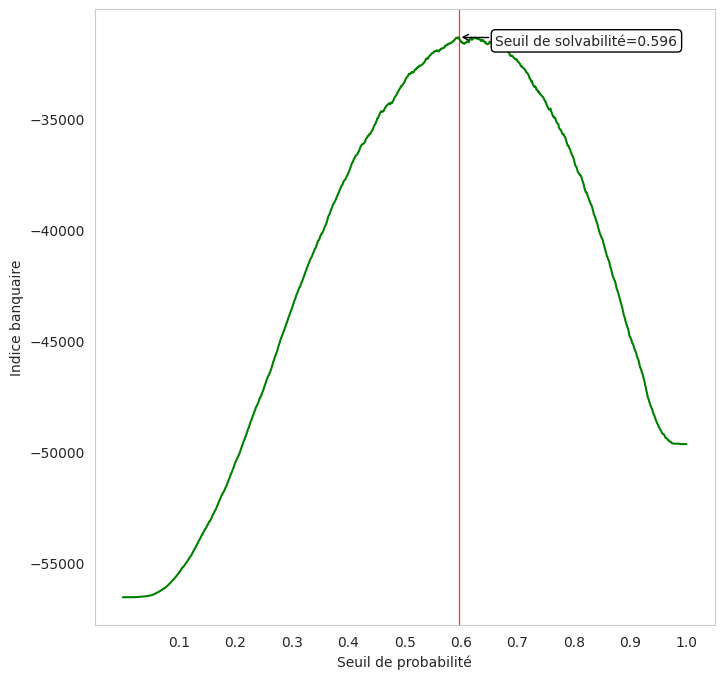

In [139]:
gain_seuil(y_pred_1, y_test)

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.73      0.83     56536
           1       0.18      0.67      0.29      4965

    accuracy                           0.73     61501
   macro avg       0.57      0.70      0.56     61501
weighted avg       0.90      0.73      0.79     61501



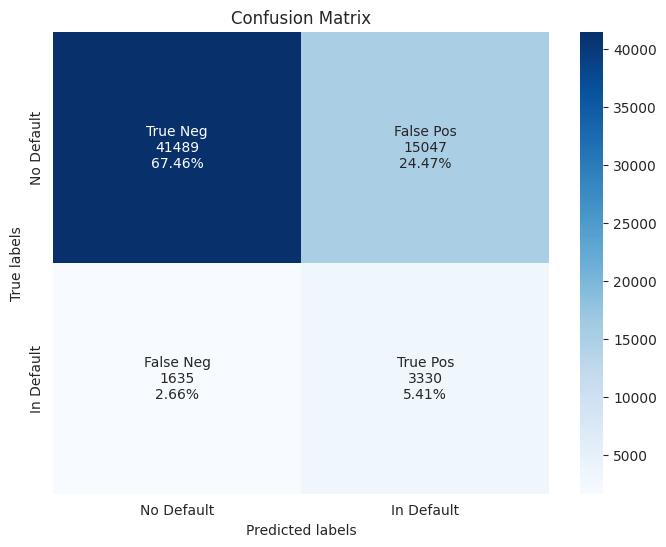

In [140]:
# Définition d'un seuil de classification
threshold = 0.596
pred_metier = (y_pred_smote[:,1] > threshold).astype(int)

cm = confusion_matrix(y_test, pred_metier)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['No Default', 'In Default'])
ax.yaxis.set_ticklabels(['No Default', 'In Default'])

print('Classification Report')
print(classification_report(y_test, pred_metier))

In [141]:
print('LightGBM RandomizedSearchCV Model precision score: {0:0.4f}'.format(precision_score(y_test, pred_metier)))
print('LightGBM RandomizedSearchCV Model recall score: {0:0.4f}'.format(recall_score(y_test, pred_metier)))

print('LightGBM RandomizedSearchCV Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, pred_metier)))
print('LightGBM RandomizedSearchCV Model ROCAUC score: {0:0.4f}'.format(roc_auc_score(y_test, pred_metier)))
print('LightGBM RandomizedSearchCV Model F1 score: {0:0.4f}'.format(f1_score(y_test, pred_metier)))

LightGBM RandomizedSearchCV Model precision score: 0.1812
LightGBM RandomizedSearchCV Model recall score: 0.6707
LightGBM RandomizedSearchCV Model accuracy score: 0.7288
LightGBM RandomizedSearchCV Model ROCAUC score: 0.7023
LightGBM RandomizedSearchCV Model F1 score: 0.2853


## **Méthode 2 : Oversampling**

In [142]:
print("shape target before handling",'\n',y.value_counts())

over  = RandomOverSampler(sampling_strategy=0.5)

pipe_over = Pipeline([
                ('over', over)
                ])
X_over, y_over = pipe_over.fit_resample(X_train, y_train)

print("shape target after handling",'\n',y_over.value_counts())

shape target before handling 
 TARGET
0    282680
1     24825
Name: count, dtype: int64
shape target after handling 
 TARGET
0    226144
1    113072
Name: count, dtype: int64


In [143]:
param_distributions_over={
                            'colsample_bytree': [0.1],
                            'learning_rate': [0.09],
                            'max_depth': [5],
                            'min_child_samples': [10],
                            'min_child_weight': [5],
                            'n_estimators': [1000],
                            'num_leaves': [20],
                            'reg_alpha': [20],
                            'reg_lambda': [100],
                            'scale_pos_weight': [7]
}

Validation croisée RandomizedSearchCV :

In [144]:
pipeline = Pipeline([
                    ('lgbm', LGBMClassifier())
                ])
params_lgbm = {'lgbm__' + key: param_distributions_over[key] for key in param_distributions_over}

random_search_over = RandomizedSearchCV(estimator=pipeline,
                           param_distributions=params_lgbm,
                           scoring='balanced_accuracy',
                           cv=kf)

random_search_over.fit(X_over, y_over)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 107552, number of negative: 163820
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.117345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22150
[LightGBM] [Info] Number of data points in the train set: 271372, number of used features: 252
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.396327 -> initscore=-0.420794
[LightGBM] [Info] Start training from score -0.420794
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('lgbm', LGBMClassifier())]),
                   param_distributions={'lgbm__colsample_bytree': [0.1],
                                        'lgbm__learning_rate': [0.09],
                                        'lgbm__max_depth': [5],
                                        'lgbm__min_child_samples': [10],
                                        'lgbm__min_child_weight': [5],
                                        'lgbm__n_estimators': [1000],
                                        'lgbm__num_leaves': [20],
                                        'lgbm__reg_alpha': [20],
                                        'lgbm__reg_lambda': [100],
                                        'lgbm__scale_pos_weight': [7]},
                   scoring='balanced_accuracy')

The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.

Validation croisée RandomizedSearchCV

In [145]:
RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('lgbm', LGBMClassifier())]),
                   param_distributions={'lgbm__colsample_bytree': [0.1],
                                        'lgbm__learning_rate': [0.09],
                                        'lgbm__max_depth': [5],
                                        'lgbm__min_child_samples': [10],
                                        'lgbm__min_child_weight': [5],
                                        'lgbm__n_estimators': [1000],
                                        'lgbm__num_leaves': [20],
                                        'lgbm__reg_alpha': [20],
                                        'lgbm__reg_lambda': [100],
                                        'lgbm__scale_pos_weight': [7]},
                   scoring='balanced_accuracy')

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('lgbm', LGBMClassifier())]),
                   param_distributions={'lgbm__colsample_bytree': [0.1],
                                        'lgbm__learning_rate': [0.09],
                                        'lgbm__max_depth': [5],
                                        'lgbm__min_child_samples': [10],
                                        'lgbm__min_child_weight': [5],
                                        'lgbm__n_estimators': [1000],
                                        'lgbm__num_leaves': [20],
                                        'lgbm__reg_alpha': [20],
                                        'lgbm__reg_lambda': [100],
                                        'lgbm__scale_pos_weight': [7]},
                   scoring='balanced_accuracy')

Les meilleurs hyper paramètres utilisés

In [146]:
best_param = random_search_over.best_params_
best_param

{'lgbm__scale_pos_weight': 7,
 'lgbm__reg_lambda': 100,
 'lgbm__reg_alpha': 20,
 'lgbm__num_leaves': 20,
 'lgbm__n_estimators': 1000,
 'lgbm__min_child_weight': 5,
 'lgbm__min_child_samples': 10,
 'lgbm__max_depth': 5,
 'lgbm__learning_rate': 0.09,
 'lgbm__colsample_bytree': 0.1}

Meilleur score du RandomizedSearchCV

In [147]:
random_search_over.best_score_

0.7050683110004802

Enregistrer le meilleur modèle

In [148]:
best_lgbm_over = random_search_over.best_estimator_

Prédire le résultat sur les données test

In [149]:
y_pred_over=best_lgbm_over.predict_proba(X_test)

Sauvegarder le modèle

In [150]:
# save the model to a file
joblib.dump(best_lgbm_over, 'best_lgbm_over_model.joblib')

['best_lgbm_over_model.joblib']

Meilleur seuil (classification d'optimisation) - Score AUC

In [151]:
print('LightGBM RandomizedSearchCV Model ROCAUC score: {0:0.4f}'.format(roc_auc_score(y_test, y_pred_over[:, 1])))

LightGBM RandomizedSearchCV Model ROCAUC score: 0.7728


Afficher les scores

In [152]:
print('LightGBM RandomizedSearchCV Oversampling Model precision score: {0:0.4f}'.format(precision_score(y_test, np.argmax(y_pred_over,axis = 1))))
print('LightGBM RandomizedSearchCV Oversampling Model recall score: {0:0.4f}'.format(recall_score(y_test, np.argmax(y_pred_over,axis = 1))))
print('LightGBM RandomizedSearchCV Oversampling Model ROC_AUC score: {0:0.4f}'.format(roc_auc_score(y_test, y_pred_over[:, 1])))
print('LightGBM RandomizedSearchCV Oversampling Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, np.argmax(y_pred_over,axis = 1))))
print('LightGBM RandomizedSearchCV Oversampling Model F1 score: {0:0.4f}'.format(f1_score(y_test, np.argmax(y_pred_over,axis = 1))))

LightGBM RandomizedSearchCV Oversampling Model precision score: 0.1170
LightGBM RandomizedSearchCV Oversampling Model recall score: 0.9108
LightGBM RandomizedSearchCV Oversampling Model ROC_AUC score: 0.7728
LightGBM RandomizedSearchCV Oversampling Model accuracy score: 0.4380
LightGBM RandomizedSearchCV Oversampling Model F1 score: 0.2074


Rapport de classification

In [153]:
print('Classification Report')
print(classification_report(y_test, np.argmax(y_pred_over,axis = 1)))

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.40      0.56     56536
           1       0.12      0.91      0.21      4965

    accuracy                           0.44     61501
   macro avg       0.55      0.65      0.39     61501
weighted avg       0.91      0.44      0.54     61501



[Text(0, 0.5, 'No Default'), Text(0, 1.5, 'In Default')]

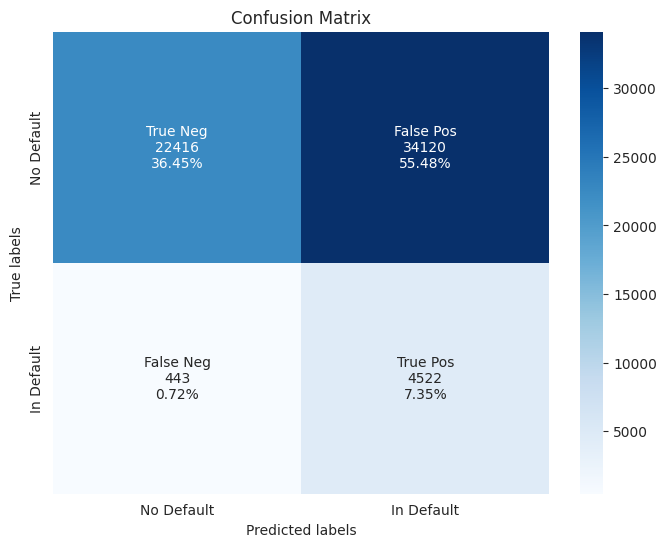

In [154]:
#Matrice de confusion
cm = confusion_matrix(y_test, np.argmax(y_pred_over,axis = 1))

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

# étiquettes, titres et graduations
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['No Default', 'In Default'])
ax.yaxis.set_ticklabels(['No Default', 'In Default'])

Seuil optimal pour la courbe ROC

Garder les probabilités que pour le résultat positif

In [155]:
y_pred_1 = y_pred_over[:, 1] # Probability of defaul (In Default)

Calculer roc_curve pour obtenir le meilleur seuil

In [156]:
# treshhold pour donner ou refuser le credit
# optimiser cette différence signifie qu'ont recherchez le seuil /
# où le modèle est efficace pour identifier les défauts tout en réduisant au minimum les faux positifs.

# calculer roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_pred_1)
# Meilleur seuil
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

Best Threshold=0.725921


Graphique ROC pour le modèle avec la classification déséquilibrée avec le seuil optimal

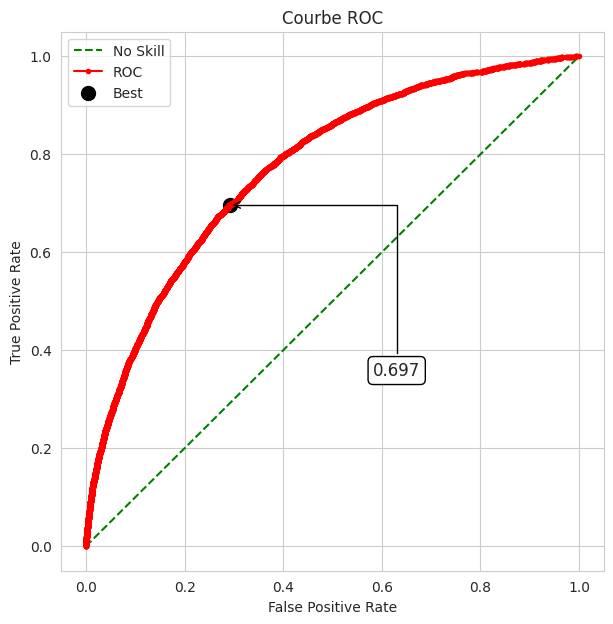

In [157]:
# Evauation of the model performance for best threshold
plt.figure(figsize=(7,7))

# graphique roc curve du modèle
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='ROC')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best',s=100)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.title('Courbe ROC')
annot_auc(fpr[ix],tpr[ix])
# Afficher le graphique
plt.show()

Matrice de confusion

[Text(0, 0.5, 'No Default'), Text(0, 1.5, 'In Default')]

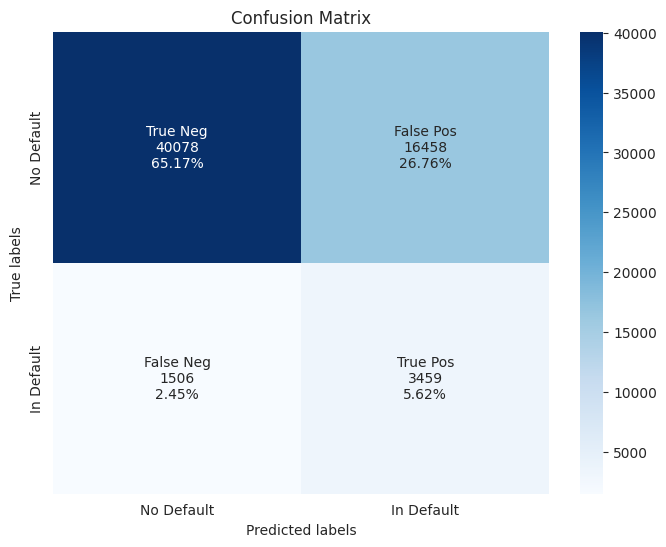

In [158]:
thresh_roc =proba_to_class(y_pred_1, tune_threshold(y_test, y_pred_1))

cm = confusion_matrix(y_test,thresh_roc)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

# étiquettes, titres et graduations
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['No Default', 'In Default'])
ax.yaxis.set_ticklabels(['No Default', 'In Default'])

Classification Report

In [159]:
print('Classification Report')
print(classification_report(y_test, thresh_roc))

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.71      0.82     56536
           1       0.17      0.70      0.28      4965

    accuracy                           0.71     61501
   macro avg       0.57      0.70      0.55     61501
weighted avg       0.90      0.71      0.77     61501



Afficher les scores

In [160]:
print('LightGBM RandomizedSearchCV Model precision score: {0:0.4f}'.format(precision_score(y_test, thresh_roc)))
print('LightGBM RandomizedSearchCV Model recall score: {0:0.4f}'.format(recall_score(y_test, thresh_roc)))

print('LightGBM RandomizedSearchCV Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, thresh_roc)))
print('LightGBM RandomizedSearchCV Model F1 score: {0:0.4f}'.format(f1_score(y_test, thresh_roc)))

LightGBM RandomizedSearchCV Model precision score: 0.1737
LightGBM RandomizedSearchCV Model recall score: 0.6967
LightGBM RandomizedSearchCV Model accuracy score: 0.7079
LightGBM RandomizedSearchCV Model F1 score: 0.2780


Seuil optimal pour la courbe de rappel /précision¶

Définir des seuils

In [161]:
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_1)

Evaluer chaque seuil

In [162]:
# Calculate F-score safely by handling zero precision or recall
fscore = np.zeros_like(precision)  # Initialize fscore as an array of zeros
for i in range(len(precision)):
    if precision[i] > 0 and recall[i] > 0:  # Avoid division by zero
        fscore[i] = (2 * precision[i] * recall[i]) / (precision[i] + recall[i])
    else:
        fscore[i] = 0  # Set F-score to 0 if precision or recall is 0

# Locate the index of the largest F-score
ix = np.argmax(fscore)

# Print the best threshold and F-score
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.834201, F-Score=0.318


valeur non valide rencontrée en true_divide

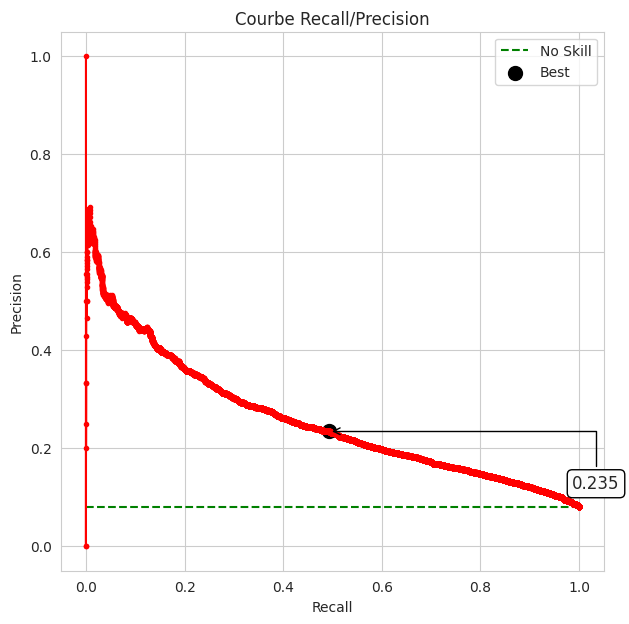

In [163]:
# plot the roc curve for the model
plt.figure(figsize=(7,7))
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best',s=100)
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

plt.title('Courbe Recall/Precision')
annot_auc(recall[ix],precision[ix])
# show the plot
plt.show()

Fonction pour créer des labels en appliquant le seuil aux probabilités positives

In [164]:
thresh_precision_recall =to_labels(y_pred_1, thresholds[ix])

[Text(0, 0.5, 'No Default'), Text(0, 1.5, 'In Default')]

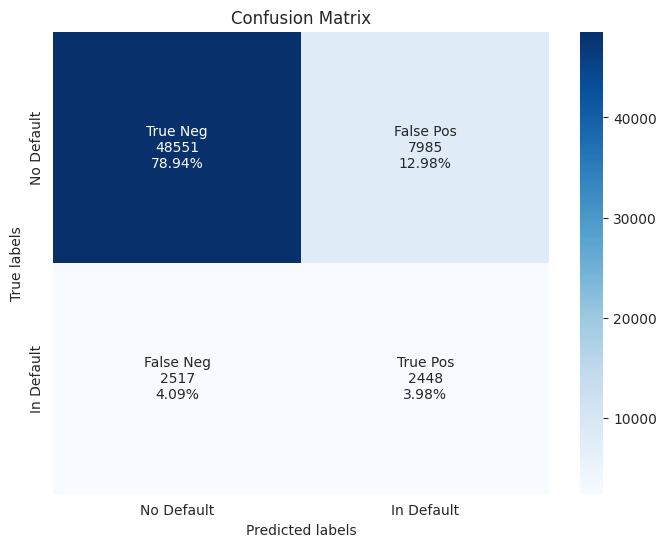

In [165]:
cm = confusion_matrix(y_test, thresh_precision_recall)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['No Default', 'In Default'])
ax.yaxis.set_ticklabels(['No Default', 'In Default'])

Classification Report

In [166]:
print('Classification Report')
print(classification_report(y_test, thresh_precision_recall))

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.86      0.90     56536
           1       0.23      0.49      0.32      4965

    accuracy                           0.83     61501
   macro avg       0.59      0.68      0.61     61501
weighted avg       0.89      0.83      0.86     61501



Afficher les scores

In [167]:
print('LightGBM RandomizedSearchCV Model precision score: {0:0.4f}'.format(precision_score(y_test, thresh_precision_recall)))
print('LightGBM RandomizedSearchCV Model recall score: {0:0.4f}'.format(recall_score(y_test, thresh_precision_recall)))
print('LightGBM RandomizedSearchCV Model ROC_AUC score: {0:0.4f}'.format(roc_auc_score(y_test, thresh_precision_recall)))
print('LightGBM RandomizedSearchCV Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, thresh_precision_recall)))
print('LightGBM RandomizedSearchCV Model F1 score: {0:0.4f}'.format(f1_score(y_test, thresh_precision_recall)))

LightGBM RandomizedSearchCV Model precision score: 0.2346
LightGBM RandomizedSearchCV Model recall score: 0.4931
LightGBM RandomizedSearchCV Model ROC_AUC score: 0.6759
LightGBM RandomizedSearchCV Model accuracy score: 0.8292
LightGBM RandomizedSearchCV Model F1 score: 0.3180


**Seuil métier**

Graphique avec le seuil métier

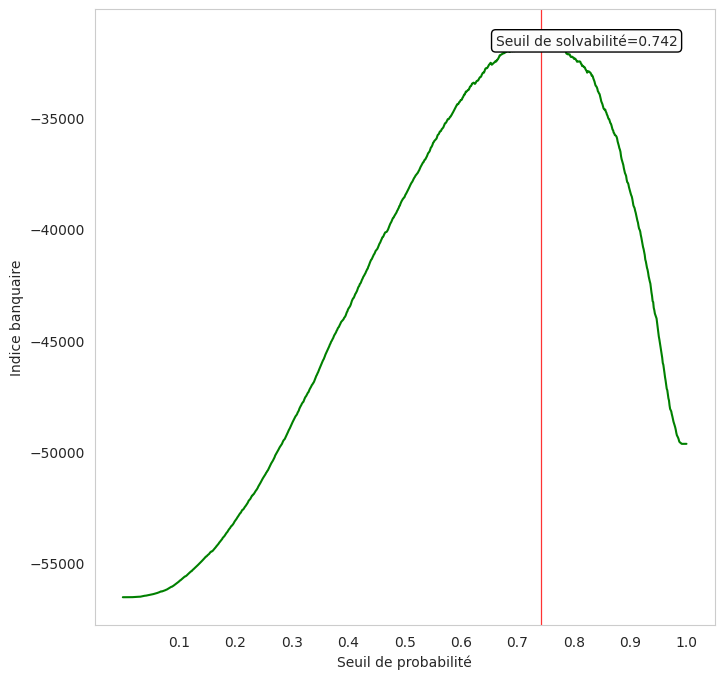

In [168]:
gain_seuil(y_pred_1, y_test)

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.74      0.84     56536
           1       0.18      0.66      0.29      4965

    accuracy                           0.74     61501
   macro avg       0.57      0.70      0.56     61501
weighted avg       0.90      0.74      0.79     61501



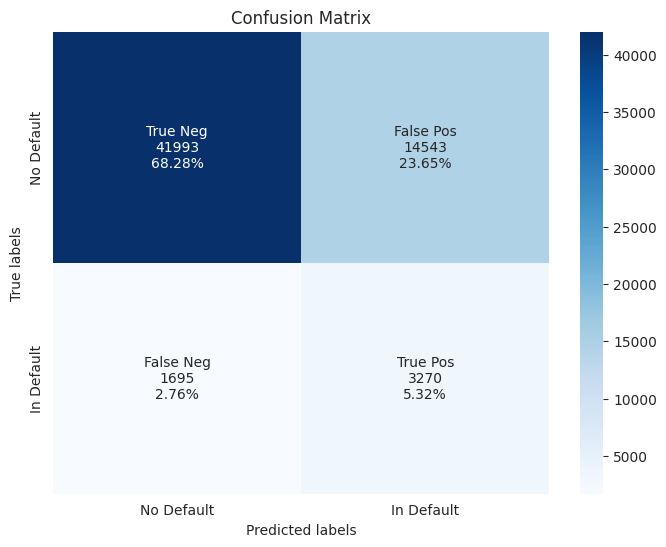

In [169]:
# Définition d'un seuil de classification
threshold = 0.750
pred_metier = (y_pred_over[:,1] > threshold).astype(int)

cm = confusion_matrix(y_test, pred_metier)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['No Default', 'In Default'])
ax.yaxis.set_ticklabels(['No Default', 'In Default'])

print('Classification Report')
print(classification_report(y_test, pred_metier))

Afficher les scores

In [170]:
print('LightGBM RandomizedSearchCV Model precision score: {0:0.4f}'.format(precision_score(y_test, pred_metier)))
print('LightGBM RandomizedSearchCV Model recall score: {0:0.4f}'.format(recall_score(y_test, pred_metier)))

print('LightGBM RandomizedSearchCV Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, pred_metier)))
print('LightGBM RandomizedSearchCV Model ROCAUC score: {0:0.4f}'.format(roc_auc_score(y_test, pred_metier)))
print('LightGBM RandomizedSearchCV Model F1 score: {0:0.4f}'.format(f1_score(y_test, pred_metier)))

LightGBM RandomizedSearchCV Model precision score: 0.1836
LightGBM RandomizedSearchCV Model recall score: 0.6586
LightGBM RandomizedSearchCV Model accuracy score: 0.7360
LightGBM RandomizedSearchCV Model ROCAUC score: 0.7007
LightGBM RandomizedSearchCV Model F1 score: 0.2871


Afficher les parametes les plus importantes :

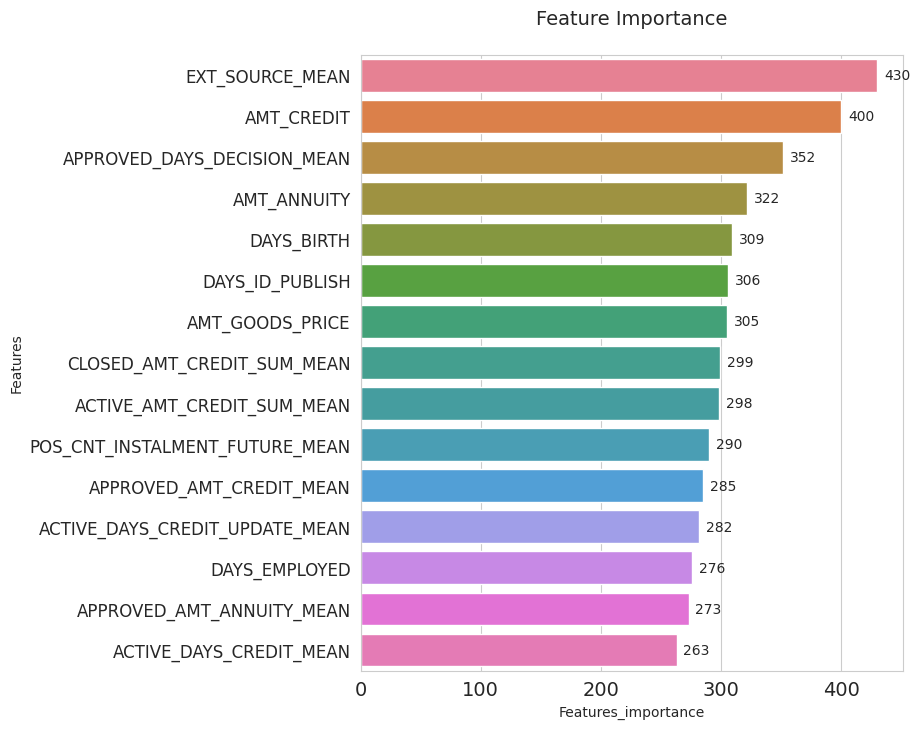

In [171]:
import warnings
# Créer dataframe des caractéristiques les plus importantes
df_feature_importance=pd.DataFrame({'Features': df_train1.iloc[ :, 2:].columns,
              'Features_importance':best_lgbm_over['lgbm'].feature_importances_
              })

df_feature_importance_15 = df_feature_importance.sort_values(by='Features_importance', ascending=False).head(15)
# df_feature_importance.sort_values(by='Features_importance', ascending=False).head(20).to_csv('df_feature_importance.csv', index = False)

# Graphique des caractéristiques les plus importantes
fig, ax = plt.subplots()

ax = sns.barplot(x="Features_importance", y="Features", data=df_feature_importance_15, palette="husl")

# Ajouter les annotations sur les barres
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
                xytext=(5, 0), textcoords='offset points', ha="left", va="center")

# Ajouter des textes aux labels, titre etc.
fig.set_size_inches(7, 8)
ax.set_title("Feature Importance\n", fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.show()


In [172]:
# def credit_decision (customers_data):

#         customers_data = X_test.copy()

#         pred_probs = y_pred_over[:, 1]

#         customer_probabilities = pd.DataFrame({
#             'Customer ID': customers_data.index,  # Assuming the index is a customer ID or similar
#             'Probability of Default': pred_probs
#         })

#         threshold = 0.725

#         # Appliquer le meilleur seuil pour classer les candidats
#         credit_decision = (y_pred_1 > best_thresh).astype(int)

#         print(customer_probabilities.head())

In [173]:
# ngrok.kill()

## Dashboard ngrok Oversampling

In [174]:
credit_decision(X_test, best_lgbm_over , 0.725)

Customer ID  Probability of Default  Credit Decision
0           216689                0.170538                0
1            37196                0.701364                0
2            57170                0.293332                0
3           269993                0.756857                1
4           134505                0.221197                0
...            ...                     ...              ...
61496       248676                0.265084                0
61497       221907                0.740328                1
61498       195437                0.265044                0
61499       271682                0.868532                1
61500       283531                0.248862                0

[61501 rows x 3 columns]

In [175]:
ngrok.set_auth_token('2b7l30licIJYUgJd5xJhKape9DW_7Cs7n75VwT5g7L5g4boDw')

# Connectez ngrok au port de l'application Dash
public_url = ngrok.connect(8050)  # Port par défaut du tableau de bord
print("Dash app running at:", public_url)

# Initialiser l'application Dash
app = dash.Dash(__name__)


customers_data = X_test.copy()

# Fonction pour prendre des décisions de crédit
def credit_decision(customers_data, model, threshold=0.725):
    y_pred_over = model.predict_proba(customers_data)  # Prédire les probabilités
    pred_probs = y_pred_over[:, 1]  # Probabilité de défaut pour la classe positive

    # Créer un DataFrame pour les probabilités des clients
    customer_probabilities = pd.DataFrame({
        'Customer ID': customers_data.index,
        'Probability of Default': pred_probs
    })

    # Appliquer le seuil de classification
    customer_probabilities['Credit Decision'] = (pred_probs > threshold).astype(int)
    customer_probabilities['Credit Decision'] = customer_probabilities['Credit Decision'].apply(lambda x: "Approved" if x == 0 else "Refused")

    return customer_probabilities

model_smote = best_lgbm_smote
model_over = best_lgbm_over

# prédictions pour les deux modèles
customer_probabilities_smote = credit_decision(customers_data, model_smote)
customer_probabilities_over = credit_decision(customers_data, model_over)

# Disposition du tableau de bord
app.layout = html.Div([
    html.H1("Credit Approval Probability Dashboard"),

    # Menu déroulant pour le contrôle du seuil
    dcc.Slider(
        id='threshold-slider',
        min=0,
        max=1,
        step=0.01,
        value=0.725,
        marks={i/10: f'{i/10}' for i in range(11)},
        tooltip={"placement": "bottom", "always_visible": True},
    ),

    # Graphique pour montrer les probabilités de distribution pour les deux modèles
    dcc.Graph(id='probability-distribution'),

    # Tableau pour montrer les décisions du client en fonction du seuil sélectionné
    dash_table.DataTable(
        id='customer-table',
        columns=[
            {'name': 'Customer ID', 'id': 'Customer ID'},
            {'name': 'Probability of Default', 'id': 'Probability of Default'},
            {'name': 'Credit Decision', 'id': 'Credit Decision'}
        ],
        style_table={'height': '400px', 'overflowY': 'auto'},
        style_cell={'textAlign': 'center'},
    ),

    # Afficher la valeur de seuil sélectionnée
    html.H3(id='threshold-value', children=f"Selected Threshold: 0.725")
])

# Rappel pour mettre à jour le graphique et la table client en fonction du seuil
@app.callback(
    [Output('probability-distribution', 'figure'),
     Output('threshold-value', 'children'),
     Output('customer-table', 'data')],
    [Input('threshold-slider', 'value')]
)
def update_dashboard(threshold):
    # Classer les décisions de crédit en fonction du seuil pour les deux modèles
    customer_probabilities_smote = credit_decision(customers_data, model_smote, threshold)
    customer_probabilities_over = credit_decision(customers_data, model_over, threshold)

    # Plot
    fig = go.Figure()

    # Ajouter la distribution du modèle SMOTE
    fig.add_trace(go.Histogram(
        x=customer_probabilities_smote['Probability of Default'],
        nbinsx=20,
        name="Model 1 (SMOTE)",
        opacity=0.6
    ))

    # Ajouter une distribution de modèle de suréchantillonnage
    fig.add_trace(go.Histogram(
        x=customer_probabilities_over['Probability of Default'],
        nbinsx=20,
        name="Model 2 (Over-sampling)",
        opacity=0.6
    ))

    # Mettre à jour la mise en page pour une meilleure clarté
    fig.update_layout(
        title=f"Probability Distribution (Threshold = {threshold})",
        xaxis_title='Probability of Default',
        yaxis_title='Count',
        barmode='overlay'
    )

    # Afficher la valeur seuil
    threshold_value_display = f"Selected Threshold: {threshold}"

    # Renvoyer les données du tableau mises à jour (en fonction des probabilités des deux modèles)
    table_data = customer_probabilities_smote.to_dict('records')  # Convertir en dict pour Dash DataTable
    return fig, threshold_value_display, table_data

# Run the app
if __name__ == '__main__':
    app.run_server(mode='inline', port=8050, debug=True)


Dash app running at: NgrokTunnel: "https://5cf1-104-197-180-225.ngrok-free.app" -> "http://localhost:8050"


<IPython.core.display.Javascript object>

## RandomForest

In [176]:
X = df_train1.iloc[ :, 2:]
y = df_train1.iloc[ :,1]

In [177]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42,stratify=y)

In [178]:
rlf_clf = RandomForestClassifier(class_weight='balanced', random_state=42)

In [179]:
rlf_clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [180]:
y_train.value_counts()

TARGET
0    226144
1     19860
Name: count, dtype: int64

Score AUC

In [181]:
y_pred = rlf_clf.predict(X_test)  # Predicted class labels
y_proba = rlf_clf.predict_proba(X_test)[:, 1] # Predicted probabilities for class 1

print("Accuracy of Random Forest Classifier is:", accuracy_score(y_pred, y_test))
print("ROC AUC score of Random Forest Classifier is", roc_auc_score(y_test, y_proba))

Accuracy of Random Forest Classifier is: 0.9192858652704834
ROC AUC score of Random Forest Classifier is 0.7276385366163683


In [182]:
rlf_clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

Enregistrer le meilleur modèle

In [183]:
# Save the model to a file
joblib.dump(rlf_clf, 'random_forest_model.joblib')

['random_forest_model.joblib']

In [184]:
print('Score test   : ', rlf_clf.score(X_test,y_test))
print('Score train  : ', rlf_clf.score(X_train,y_train))

Score test   :  0.9192858652704834
Score train  :  0.9999552852799142


Rapport de classification

In [185]:
print("Classification Report")
print(classification_report(y_test, y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56536
           1       0.57      0.00      0.00      4965

    accuracy                           0.92     61501
   macro avg       0.75      0.50      0.48     61501
weighted avg       0.89      0.92      0.88     61501



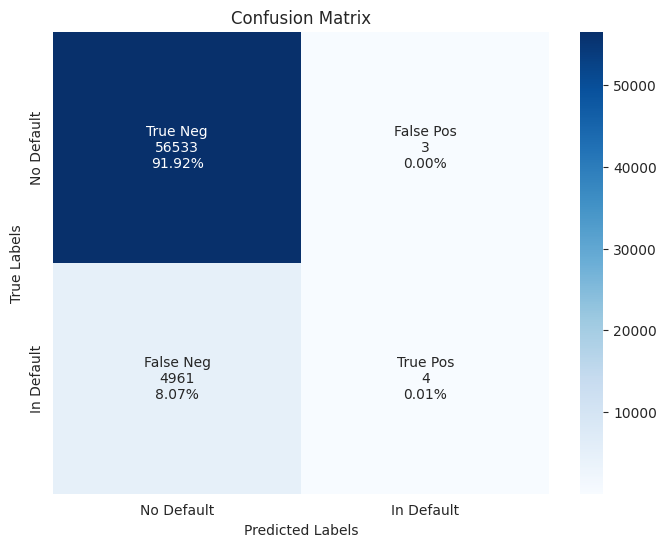

In [186]:
# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Définir les annotations
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)

# Plot heatmap
plt.figure(figsize=(8, 6))
ax = plt.subplot()
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

# Étiquettes, titres et graduations
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['No Default', 'In Default'])
ax.yaxis.set_ticklabels(['No Default', 'In Default'])

plt.show()

Seuil optimal pour la courbe ROC
Garder les probabilités que pour le résultat positif

In [187]:
y_proba = rlf_clf.predict_proba(X_test)
y_pred_1 = y_proba[:, 1] # Probabilities for class 1

Calculer roc_curve pour obtenir le meilleur seuil

In [188]:
# calculer roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_pred_1)
# Meilleur seuil
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

Best Threshold=0.090000


Graphique ROC pour le modèle avec la classification déséquilibrée avec le seuil optimal

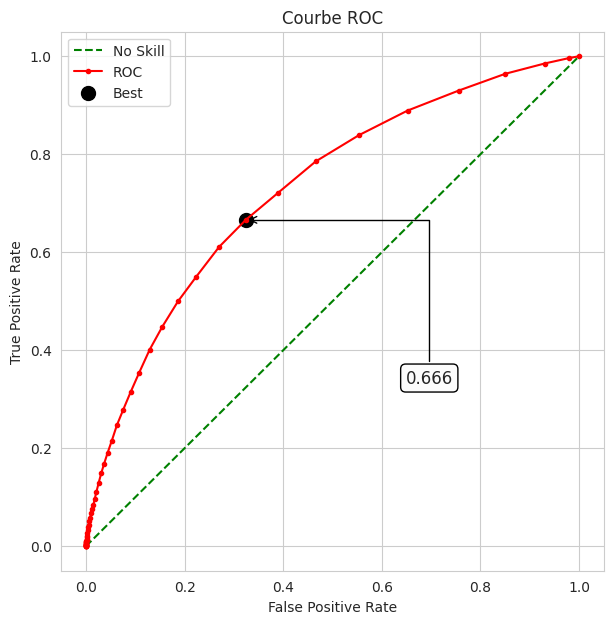

In [189]:
plt.figure(figsize=(7,7))

# graphique roc curve du modèle
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='ROC')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best',s=100)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.title('Courbe ROC')

annot_auc(fpr[ix],tpr[ix])

# Afficher le graphique
plt.show()

Matrice de confusion

[Text(0, 0.5, 'No Default'), Text(0, 1.5, 'In Default')]

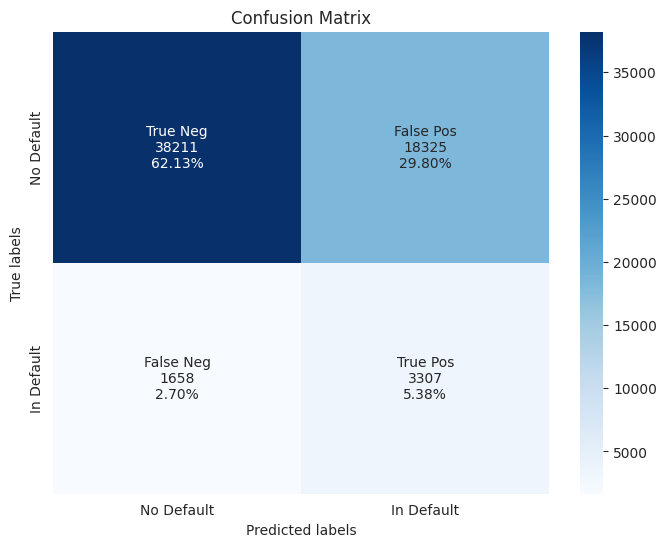

In [190]:
thresh_roc =proba_to_class(y_pred_1, tune_threshold(y_test, y_pred_1))

cm = confusion_matrix(y_test,thresh_roc)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['No Default', 'In Default'])
ax.yaxis.set_ticklabels(['No Default', 'In Default'])

Classification Report

In [191]:
print('Classification Report')
print(classification_report(y_test, thresh_roc))

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.68      0.79     56536
           1       0.15      0.67      0.25      4965

    accuracy                           0.68     61501
   macro avg       0.56      0.67      0.52     61501
weighted avg       0.89      0.68      0.75     61501



Afficher les scores

In [192]:
print('RForest RandomizedSearchCV Model precision score: {0:0.4f}'.format(precision_score(y_test, thresh_roc)))
print('RForest RandomizedSearchCV Model recall score: {0:0.4f}'.format(recall_score(y_test, thresh_roc)))

print('RForest RandomizedSearchCV Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, thresh_roc)))
print('RForest RandomizedSearchCV Model F1 score: {0:0.4f}'.format(f1_score(y_test, thresh_roc)))

RForest RandomizedSearchCV Model precision score: 0.1529
RForest RandomizedSearchCV Model recall score: 0.6661
RForest RandomizedSearchCV Model accuracy score: 0.6751
RForest RandomizedSearchCV Model F1 score: 0.2487


Seuil optimal pour la courbe de rappel / précision

Définir des seuils

In [193]:
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_1)

Evaluer chaque seuil

In [194]:
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.140000, F-Score=0.279


invalid value encountered in true_divide

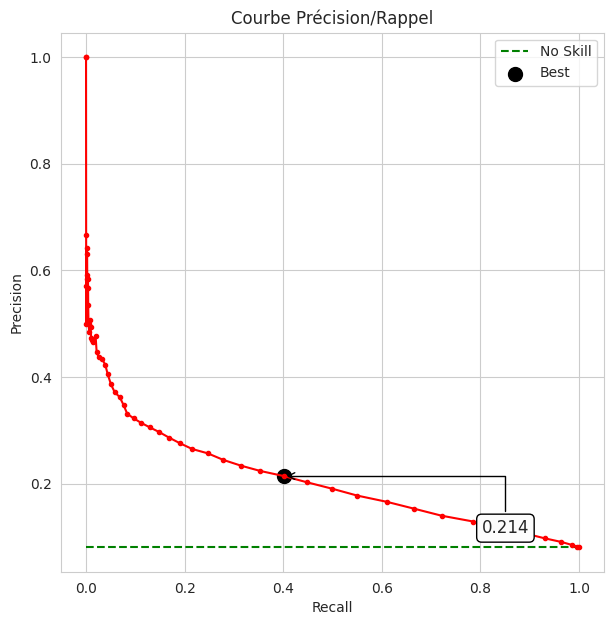

In [195]:
# plot the roc curve for the model
plt.figure(figsize=(7,7))
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best',s=100)
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

plt.title('Courbe Précision/Rappel')
annot_auc(recall[ix],precision[ix])

# show the plot
plt.show()

Fonction pour créer des labels en appliquant le seuil aux probabilités positives

In [196]:
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')
thresh_precision_recall =to_labels(y_pred_1, thresholds[ix])

[Text(0, 0.5, 'No Default'), Text(0, 1.5, 'In Default')]

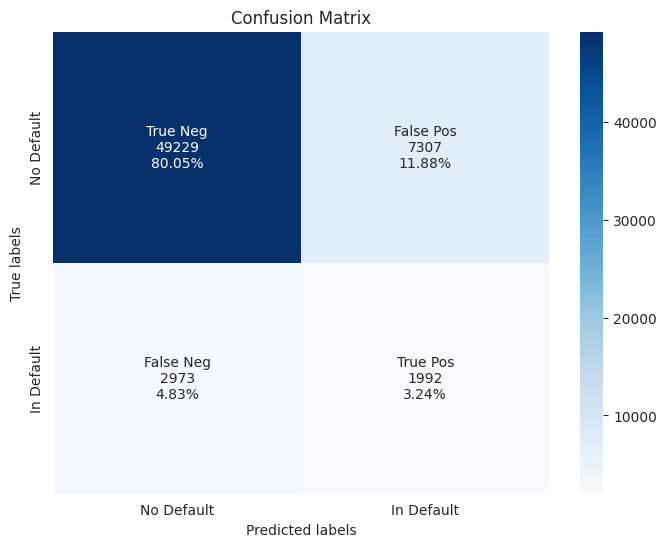

In [197]:
cm = confusion_matrix(y_test, thresh_precision_recall)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['No Default', 'In Default'])
ax.yaxis.set_ticklabels(['No Default', 'In Default'])

Rapport de classification

In [198]:
print('Classification Report')
print(classification_report(y_test, thresh_precision_recall))

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.87      0.91     56536
           1       0.21      0.40      0.28      4965

    accuracy                           0.83     61501
   macro avg       0.58      0.64      0.59     61501
weighted avg       0.88      0.83      0.85     61501



Afficher les scores

In [199]:
print('RForest RandomizedSearchCV Model precision score: {0:0.4f}'.format(precision_score(y_test, thresh_precision_recall)))
print('RForest RandomizedSearchCV Model recall score: {0:0.4f}'.format(recall_score(y_test, thresh_precision_recall)))

print('RForest RandomizedSearchCV Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, thresh_precision_recall)))
print('RForest RandomizedSearchCV Model F1 score: {0:0.4f}'.format(f1_score(y_test, thresh_precision_recall)))

RForest RandomizedSearchCV Model precision score: 0.2142
RForest RandomizedSearchCV Model recall score: 0.4012
RForest RandomizedSearchCV Model accuracy score: 0.8328
RForest RandomizedSearchCV Model F1 score: 0.2793


## Naive Bayes classifier

In [200]:
X = df_train1.iloc[ :, 2:]
y = df_train1.iloc[ :,1]

In [201]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42,stratify=y)

In [202]:
from sklearn.naive_bayes import GaussianNB

nb_clf = GaussianNB()
nb_clf.fit(X_train, y_train)

# Faire des prédictions (étiquettes de classe)
y_pred = nb_clf.predict(X_test) # Predicted class labels
y_proba = nb_clf.predict_proba(X_test)[:, 1] # Predicted probabilities class 1
print("Accuracy of Naive Bayes Classifier is:", accuracy_score(y_pred, y_test))
print("ROC AUC score of Naive Bayes Classifier is", roc_auc_score(y_test, y_proba))

Accuracy of Naive Bayes Classifier is: 0.33142550527633696
ROC AUC score of Naive Bayes Classifier is 0.6082692313721164


In [203]:
# Il est intéressant de noter que la précision est très faible comme prévu dans un ensemble de données déséquilibré.

In [204]:
# Stratégie pour équilibrer les classes (SMOTE)
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Initialiser Naive Bayes classifier
nb_clf = GaussianNB()

# Fit le modèle aux données
nb_clf.fit(X_train_res, y_train_res)

# Faire des prédictions (class labels)
y_pred = nb_clf.predict(X_test)  # Predicted class labels

# Obtenir les probabilités prédites pour la classe positive
y_proba = nb_clf.predict_proba(X_test)[:, 1]  # Probabilities class 1

# Print accuracy
print("Accuracy of Naive Bayes Classifier is:", accuracy_score(y_test, y_pred))

# Print ROC AUC score
print("ROC AUC Score of Naive Bayes Classifier is:", roc_auc_score(y_test, y_proba))

Accuracy of Naive Bayes Classifier is: 0.2550527633697013
ROC AUC Score of Naive Bayes Classifier is: 0.5999866103192134


In [205]:
# Enregistrer le modèle
joblib.dump(nb_clf, 'gaussianNB_smote_model.joblib')

['gaussianNB_smote_model.joblib']

## DecisionTreeClassifier

In [206]:
X = df_train1.iloc[ :, 2:]
y = df_train1.iloc[ :,1]

In [207]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42,stratify=y)

In [208]:
from sklearn.tree import DecisionTreeClassifier

# Hyperparameter grid
# param_grid = {
#     'max_depth': [3, 5, 10, 15, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
# }

param_grid = {
    'max_depth': [3],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
}

# Initialiser Decision Tree classifier
dt_clf = DecisionTreeClassifier(class_weight='balanced', random_state=42)

# Set up GridSearchCV avec cross-validation
grid_search = GridSearchCV(estimator=dt_clf, param_grid=param_grid, cv=5, scoring='roc_auc')


# Fit grid search aux données
grid_search.fit(X_train, y_train)

# Meilleur modèle après réglage
best_dt_clf = grid_search.best_estimator_


# prédictions avec le meilleur modèle
y_pred = best_dt_clf.predict(X_test)

# Obtenir les probabilités prédites de la classe positive
y_proba = best_dt_clf.predict_proba(X_test)[:, 1]

# Calculer accuracy
print("Accuracy of Decision Tree Classifier is:", accuracy_score(y_pred, y_test))

# Calculer ROC AUC score
roc_auc = roc_auc_score(y_test, y_proba)
print("ROC AUC Score of Decision Tree Classifier is:", roc_auc)

Accuracy of Decision Tree Classifier is: 0.6541519650086991
ROC AUC Score of Decision Tree Classifier is: 0.7122202310185733


In [209]:
dt_clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}

In [210]:
# Enregistrer le modèle
joblib.dump(best_dt_clf, 'decision_tree_classifier_model.joblib')

['decision_tree_classifier_model.joblib']

## KNeighbors

In [211]:
X = df_train1.iloc[ :, 2:]
y = df_train1.iloc[ :,1]

In [212]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42,stratify=y)

In [213]:
from sklearn.neighbors import KNeighborsClassifier

# Initialiser et former le classificateur KNN
kn_clf = KNeighborsClassifier(weights='distance', n_neighbors=5)
kn_clf.fit(X_train, y_train)

# Prédire et évaluer les performances du modèle
y_pred = kn_clf.predict(X_test)

print("Accuracy of KNeighbors Classifier:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy of KNeighbors Classifier: 0.9135298613030682
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.95     56536
           1       0.15      0.02      0.03      4965

    accuracy                           0.91     61501
   macro avg       0.54      0.50      0.49     61501
weighted avg       0.86      0.91      0.88     61501



In [214]:
# Rééchantillonner les données à l'aide de SMOTE pour détecter un déséquilibre de classe
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Entraîner le classificateur sur des données rééchantillonnées et évaluer
kn_clf.fit(X_resampled, y_resampled)
y_pred = kn_clf.predict(X_test)

# Matrice de confusion et score ROC-AUC
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

y_prob = kn_clf.predict_proba(X_test)[:, 1]  # Obtenir les probabilités pour la classe positive

print("Accuracy of KNeighbors Classifier:", accuracy_score(y_test, y_pred))
print("ROC-AUC Score of KNeighbors Classifier:", roc_auc_score(y_test, y_prob))

Confusion Matrix:
 [[40647 15889]
 [ 3266  1699]]
Accuracy of KNeighbors Classifier: 0.6885416497292727
ROC-AUC Score of KNeighbors Classifier: 0.5456062466984472


In [215]:
# Enregistrer le modèle
joblib.dump(kn_clf, 'Kneighbors_model.joblib')

['Kneighbors_model.joblib']

In [216]:
# from sklearn.neighbors import KNeighborsClassifier

# kn_clf = KNeighborsClassifier(weights='distance', n_neighbors=5)
# kn_clf.fit(X_train, y_train)
# y_pred = kn_clf.predict(X_test)
# print("Accuracy of KNeighbors Classifier is:", metrics.accuracy_score(y_pred, y_test))

In [217]:
# kn_clf.get_params()

In [218]:
# # Precision, Recall, F1-score (better for class imbalance).
# # ROC-AUC (useful for imbalanced datasets as it considers class probabilities)

# from sklearn.metrics import classification_report

# print(classification_report(y_test, y_pred))

In [219]:
# smote = SMOTE()
# X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# kn_clf.fit(X_resampled, y_resampled)
# y_pred = kn_clf.predict(X_test)

# cm = confusion_matrix(y_test, y_pred)
# print("Confusion Matrix:\n", cm)

In [220]:
# kn_clf.get_params()

In [221]:
# print(classification_report(y_test, y_pred))

In [222]:
# from sklearn.metrics import roc_auc_score

# y_prob = kn_clf.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
# roc_auc = roc_auc_score(y_test, y_prob)
# print("ROC-AUC Score:", roc_auc)


In [223]:
# acc = accuracy_score(y_test, y_pred)
# print("Accuracy:", acc)

## XGBClassifier


In [224]:
X = df_train1.iloc[ :, 2:]
y = df_train1.iloc[ :,1]

In [225]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42,stratify=y)

In [226]:
from xgboost import XGBClassifier

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score

# Suréchantillonner la classe minoritaire avec SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# hyperparameter grid
param_grid = {
    'max_depth': [3, 4],  # Des arbres moins profonds pour éviter le surapprentissage
    'learning_rate': [0.01, 0.05],  # Un apprentissage plus lent pour une meilleure généralisation
    'n_estimators': [100, 200],  # Plus de tours de boost
    'subsample': [0.8],  # Utiliser 80 % des échantillons par arbre
    'colsample_bytree': [0.7],  # Utiliser 70 % des fonctionnalités par arbre
    'scale_pos_weight': [10, 15],  # Équilibrer les poids des classes
    'min_child_weight': [5, 10],  # divisions conservatrices
    'reg_alpha': [1],  # L1 régularisation
    'reg_lambda': [10],  # L2 régularisation
}

# Initialiser XGBClassifier
xgboost_clf = XGBClassifier(tree_method='hist', random_state=42, use_label_encoder=False, eval_metric='auc')

# Configurer GridSearchCV avec validation croisée et notation ROC AUC
grid_search = GridSearchCV(estimator=xgboost_clf, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# Ajuster la recherche de grille aux données suréchantillonnées
grid_search.fit(X_resampled, y_resampled)

# Meilleur modèle après réglage
best_xgboost_clf = grid_search.best_estimator_

# prédictions avec le meilleur modèle
y_pred = best_xgboost_clf.predict(X_test)
y_proba = best_xgboost_clf.predict_proba(X_test)[:, 1]

# Calculer les métriques
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print(f"Best Parameters: {grid_search.best_params_}")
print("Accuracy of XGBClassifier:", accuracy)
print("ROC AUC Score of XGBClassifier:", roc_auc)

Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 10, 'n_estimators': 200, 'reg_alpha': 1, 'reg_lambda': 10, 'scale_pos_weight': 15, 'subsample': 0.8}
Accuracy of XGBClassifier: 0.5286905903969041
ROC AUC Score of XGBClassifier: 0.7450274872316204


In [227]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.50      0.66     56536
           1       0.13      0.83      0.22      4965

    accuracy                           0.53     61501
   macro avg       0.55      0.67      0.44     61501
weighted avg       0.90      0.53      0.63     61501

[[28395 28141]
 [  845  4120]]


In [228]:
# Enregistrer le modèle
joblib.dump(best_xgboost_clf, 'XGB_classifier_model.joblib')

['XGB_classifier_model.joblib']

ML FLOW

# Suivi des expériences avec MLFLOW

In [230]:
# save_notebook(
#     repo="Pipalipa/my-first-repo",
#     branch="mlflow-101"
# )

In [231]:
DAGSHUB_USER_NAME = "Pipalipa"
DAGSHUB_EMAIL = "pipscorreia@gmail.com"

In [232]:
# DagsHub repo
DAGSHUB_REPO_NAME = "MLFLOw_Model"

# Name of branch
BRANCH = "mlflow-101"

START_FRESH = False

In [233]:
# mlflow.end_run()

In [234]:
# Initialiser l'intégration de DagsHub
dagshub.init("my-first-repo", "Pipalipa", mlflow=True)

# Définir l'URI de suivi MLflow pour pointer vers DagsHub
mlflow.set_tracking_uri("https://dagshub.com/Pipalipa/my-first-repo.mlflow")

# Fonction pour entraîner et enregistrer des modèles
def train_and_log_model(model, model_name, X_train, X_test, y_train, y_test):
    # Démarrer MLflow
    with mlflow.start_run(run_name=model_name):
        # Entraîner le modèle
        model.fit(X_train, y_train)

        # Log parameters
        for param_name, param_value in model.get_params().items():
            mlflow.log_param(param_name, param_value)

        # Faire des prédictions
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]  # For ROC AUC

        # Calculer les métriques
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_proba)

        # Log metrics
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("roc_auc", roc_auc)

        # Log modèle avec exemple d'entrée et signature
        input_example = X_test[:1]
        mlflow.sklearn.log_model(
            model,
            model_name,
            input_example=input_example,
            signature=mlflow.models.infer_signature(X_test, y_pred)
        )

        print(f"Model {model_name} logged with Accuracy: {accuracy}, ROC AUC: {roc_auc}")

# Définir des modèles avec des paramètres
models = [
    {"name": "RandomForest_balanced", "model": RandomForestClassifier(n_estimators=100, class_weight='balanced'), "params": {"n_estimators": 100, "class_weight": "balanced"}},
    {"name": "DecisionTree_balanced", "model": DecisionTreeClassifier(class_weight='balanced'), "params": {"class_weight": "balanced"}},
    {"name": "KNeighbors", "model": KNeighborsClassifier(weights='distance'), "params": {'weights': 'distance'}},
    {"name": "KNeighbors_smote", "model": KNeighborsClassifier(weights='distance'), "params": {'weights': 'distance'}},
    {"name": "XGBClassifier", "model": XGBClassifier(
        max_depth=4, # Des arbres moins profonds pour éviter le surapprentissage
        learning_rate=0.03, # Apprentissage plus lent pour stabiliser les mises à jour
        n_estimators=500,  # Nombre de tours de boosting (réduire si le surajustement persiste)
        subsample=0.8,  # Utiliser 80 % des données de formation par arbre
        colsample_bytree=0.7, # Utilisez 70 % des fonctionnalités par arbre
        min_child_weight=10, # Augmentation pour rendre les répartitions plus conservatrices
        scale_pos_weight=10, # Rapport poids : 92/8 (Négatif : Positif)
        reg_alpha=1, # Ajouter une régularisation L1 pour sparsity
        reg_lambda=10, # Ajouter une forte régularisation L2
        max_delta_step=1, # Stabiliser les mises à jour pour les données déséquilibrées
        random_state=42, # Pour la reproductibilité
        tree_method="hist", # Algorithme optimisé basé sur un histogramme
        eval_metric="auc",  # Adapté aux ensembles de données déséquilibrés
        use_label_encoder=False, # Désactiver l'encodage automatique des étiquettes
        ),
     "params": {
        "max_depth": 4,
        "learning_rate": 0.03,
        "n_estimators": 500,
        "subsample": 0.8,
        "colsample_bytree": 0.7,
        "min_child_weight": 10,
        "scale_pos_weight": 10,
        "reg_alpha": 1,
        "reg_lambda": 10,
        "max_delta_step": 1,
        "random_state": 42,
        "tree_method": "hist",
        "eval_metric": "auc",
        "use_label_encoder": False,
         },
     },
]

# Appliquer SMOTE pour certains modèles ou nécessaire
smote = SMOTE()

# Entraînez et enregistrez chaque modèle
for model_info in models:
    model = model_info["model"]
    model_name = model_info["name"]

    # Si nous utilisons SMOTE, appliquez-le aux données de entraînement
    if "smote" in model_name.lower():
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
        train_and_log_model(model, model_name, X_resampled, X_test, y_resampled, y_test)
    else:
        train_and_log_model(model, model_name, X_train, X_test, y_train, y_test)

print("All models have been logged successfully.")

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=58413a27-0dc4-460c-ac8a-e022d4e71dbc&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=4e959ee34252151552e7c2dfa0dd571f0cb0aeb3851f57cbe46ff0683af87b1c




Output()

Accessing as Pipalipa

Initialized MLflow to track repo "Pipalipa/my-first-repo"

Repository Pipalipa/my-first-repo initialized!

Model RandomForest_balanced logged with Accuracy: 0.9191883058812051, ROC AUC: 0.7286725078236205
🏃 View run RandomForest_balanced at: https://dagshub.com/Pipalipa/my-first-repo.mlflow/#/experiments/0/runs/7e02ec0ace394cd88db793a4bd7b8914
🧪 View experiment at: https://dagshub.com/Pipalipa/my-first-repo.mlflow/#/experiments/0
Model DecisionTree_balanced logged with Accuracy: 0.8562950195931773, ROC AUC: 0.5400630471030339
🏃 View run DecisionTree_balanced at: https://dagshub.com/Pipalipa/my-first-repo.mlflow/#/experiments/0/runs/a7e4cf50d41f49c4b65a54d1f6ff62bf
🧪 View experiment at: https://dagshub.com/Pipalipa/my-first-repo.mlflow/#/experiments/0
Model KNeighbors logged with Accuracy: 0.9135298613030682, ROC AUC: 0.5365110499689989
🏃 View run KNeighbors at: https://dagshub.com/Pipalipa/my-first-repo.mlflow/#/experiments/0/runs/53ba4d5205ab427893fd8aaac5ad0a26
🧪 View experiment at: https://dagshub.com/Pipalipa/my-first-repo.mlflow/#/experiments/0
Model KNeighbors_smote logged with Accura

<!-- #test case
# suite = TestSuite(tests=[
#     NoTargetPerformanceTestPreset(),
# ])

# suite.run(reference_data=reference, current_data=current)
# suite -->